<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.316 Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 18: Monte Carlo



<a name='section_16_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L16.5 ML N-body Problem </h2>  


Now, we are going to construct a very simple machine learning approach to stellar simulation. While, this approach will not really allow us to go into detail, we will start to grasp a concept of where machine learning is relevant in a simulation scenario. 

To this, we first need to pull in our usual simulation code dictating stellar evolution. We will be sure to use the leapfrog symplectic integrator. Additionally, we will use a fixed time-step. 

Ok, so looks ok; could be better, but thats beyond this class. 

Now there is a broad range of possibilities that we can consier machine learning for. Ideally, we would want to use the fact that machine learning allows us to do a function approximation, but very fast and effectively. For the use of this in simulation, we can do just that, a funcitonal approximation. 

Now, lets consider the situation where we have randomly sample some initial conditions and then compute a tractory for that, then from that try to predict something. 

To randomly sample, we are going to have same over a restricted phase space. The issue is that a full random sample of many parametes is just hard to simulate, we are trying to predict a broad range of final states, this is tricky.

So for this sampling, what we will do is restrict our possible cases. We are going to restrict to a some simplified case where things are easy to solve. 


<a name='section_18_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.0 Overview of Learning Objectives</h2>


While, we have been randomly sampling and building toys throughout this class. We have yet to devote a whole lecture to Monte Carlo Simulation. This is the lecture that you have been missing. In this lecture, we are going to build a Monte Carlo simulation critical for proton therapy. Then we are going to explore Machine Learning Monte Carlo strategies, and show how some of the biggest advances in Artificial Intelligence are changing the way we simulation scientific data. 

In [10]:
import imageio
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import math
from scipy import optimize as opt 


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.


In [3]:
#>>>RUN: L10.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_18_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.1 Monte Carlo Computations</h2>  



<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L06/slides_L06_05.html" target="_blank">HERE</a>.

<h3>Numerical Integration with Monte Carlo</h3>

You have probably noticed that in many cases to get averages, standard deviations, moments I just computed the means of the moments of sampled distributions. Instead, I did what is referred to as Monte-Carlo Integration (or more generally bootstrapping) where I just sampled a distribution and integrated by sampling. Namely, 

$$
\begin{equation}
E[x^{n}p(x)] = \int_{-\infty}^{\infty} x^{n} p(x) dx = \frac{1}{N}\sum_{i=1}^{N} x_{i}^{n}
\end{equation}
$$

where here the $x_{i}\in p(x)$ are sampled from the probability distribution function. So what happens, when we have a distribution, but we don't know the analytic form. How can we sample it?  

There are a lot of ways to do this, perhaps the best well known is Markov Chain Monte Carlo (MCMC). However the simplest is to just turn our distribution into a 2D image and randomly sample points on the image. Instead of writing the points out, let's just do it. 

To see how this works, let's walk through a caculation of integrating a quarter circle. We know that the integral is given by $A=\frac{\pi}{4}$, so we can check our math. What we will do is 

1. Sample randomly in x
2. Sample randomly in y
3. Check to see if x and y are within our quarter circle. 
4. Compute the number of samples within our quarter circle, compared to all points. 

Let's look at the code. Note that since we are randomly sampling, our uncertainty on our random sample will just be the poisson uncertainty or $\frac{a}{\sqrt{N_{\rm samples}}}$.


783
Pi (4*area): 3.132 +/- 0.09904253631647365


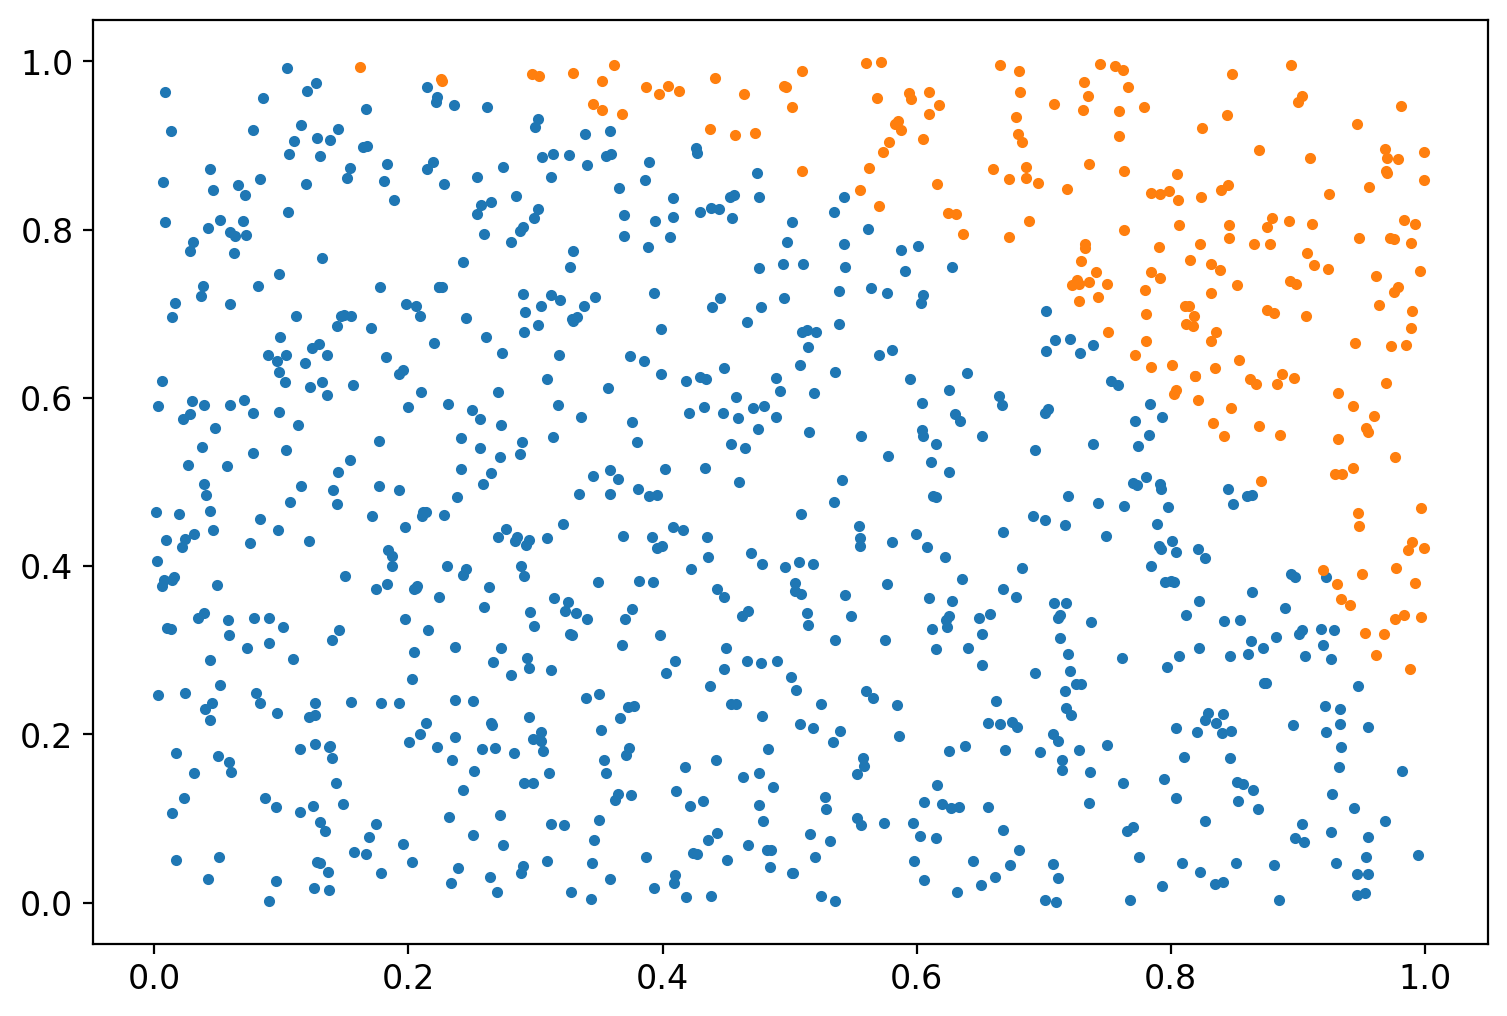

In [71]:
#First let's just compute the area of a quarter circle with radius 1
def quarterarea(iN):
    area=0
    lXin = np.array([])
    lYin = np.array([])
    lXout = np.array([])
    lYout = np.array([])
    for i0 in range(iN):
        #Sample X and Y
        pX = np.random.uniform(0,1)
        pY = np.random.uniform(0,1)
        #Check if its radius is in 1
        if np.sqrt(pX**2+pY**2) < 1:
            lXin = np.append(lXin,pX)
            lYin = np.append(lYin,pY)
            area += 1 # count it
        else:
            lXout = np.append(lXout,pX)
            lYout = np.append(lYout,pY)
    print(area)
    return (float(area)/float(iN)),lXin,lYin,lXout,lYout

#sample points
lN=1000
#lN=100000
a,lXin,lYin,lXout,lYout=quarterarea(lN)
print("Pi (4*area):",a*4,"+/-",4*a/math.sqrt(lN)) #gotta put an uncertainty
plt.plot(lXin,lYin,marker='.',linestyle = 'None')
plt.plot(lXout,lYout,marker='.',linestyle = 'None')
plt.show()

The idea with Monte Carlo integration is that we calculate an integral by evaluating the function. We don't actually have to compute the integral. This avoids what is potentially a very complicated step.  As you probably well know, computing integrals can be very hard, this way gets at our answer just through functional evaluation. 

Now, let's compute the integral of some arbitrary function $y=f(x)$. As we did with our circle, we can compute the integral by plotting this function over a range. Here we will do $-6 < x < 3$. From this, what we will do is sample over a 2D Gaussian distribution of width given by the x and y ranges and center given by the minimum x and y values. Why this distribution to sample? Because we can.

[ymin,ymax]: -803.3955308824272 -12.499898490291134


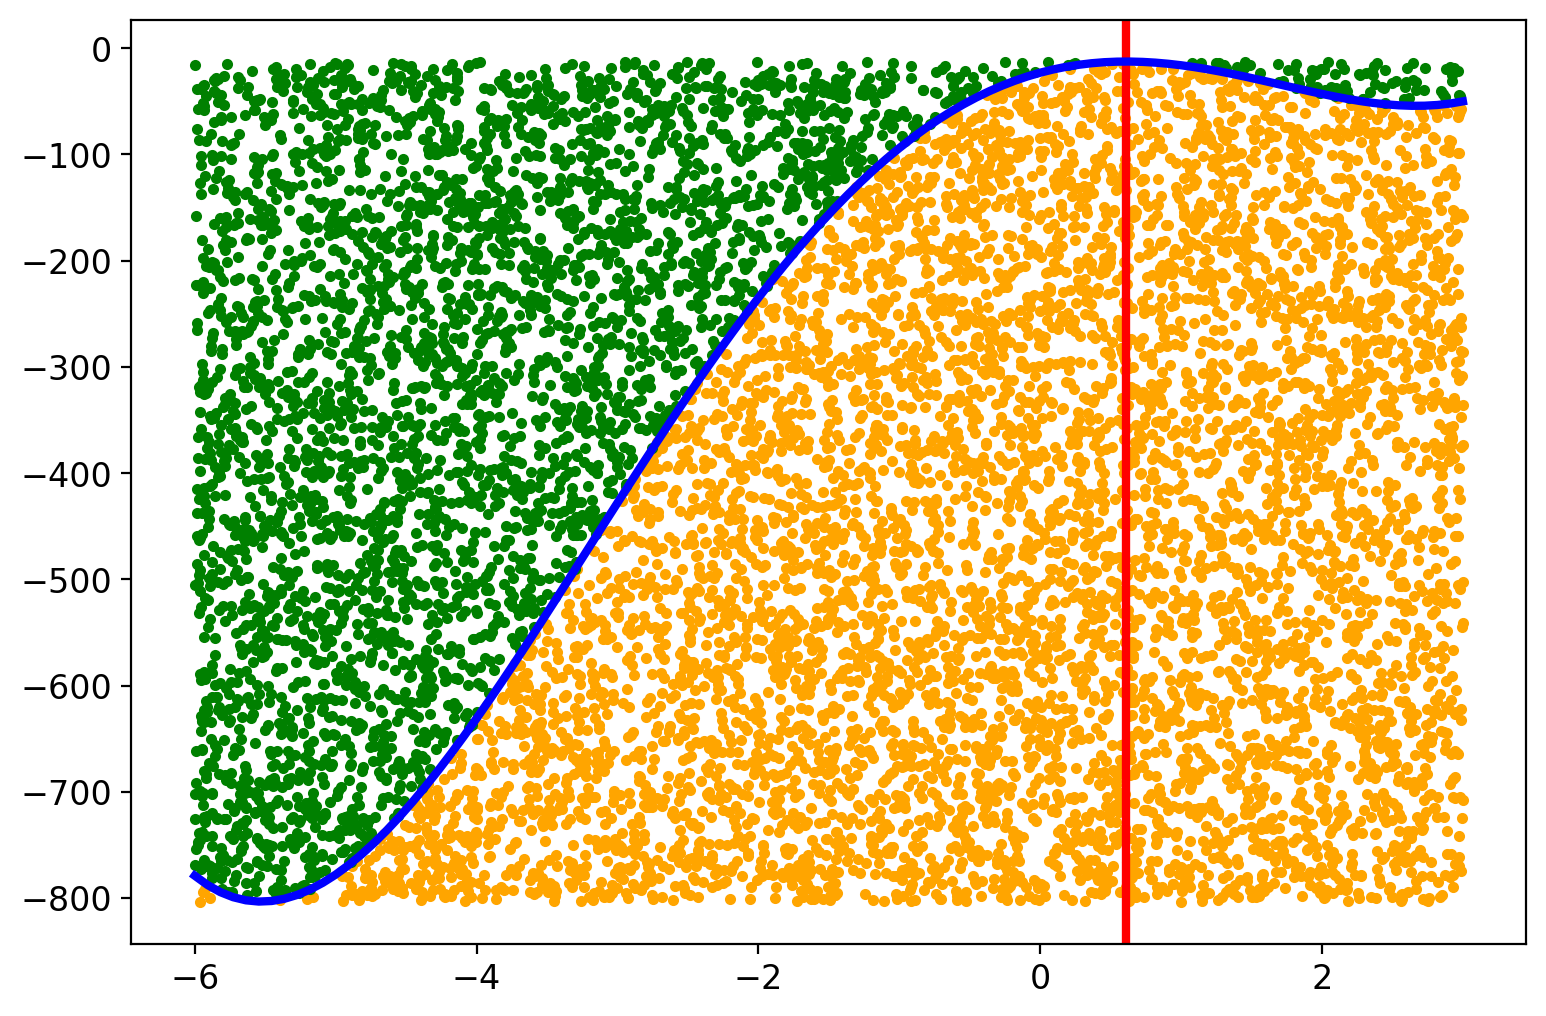

In [75]:
#>>>RUN: L6.5-runcell02


#use this random seed
np.random.seed(10)

#Now let's consider integrating some random function
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

#Now let's multiply it by -1 to make the range calculation fast
def fneg(x):
    return -1*(x**4 + 3*(x-2)**3 - 15*(x)**2 + 1)


#First thing is to define a range in x
xmin=-6
xmax=3
x = np.linspace(xmin, xmax, 100)
plt.plot(x, f(x));
#plt.show()

#Now we need to find a range in y
sol=opt.minimize_scalar(f,bounds=(xmin, xmax))#, method='Brent')
ymin=sol.fun
#y-max is to get the minimum of negative f
sol=opt.minimize_scalar(fneg,bounds=(xmin, xmax))#, method='Brent')
ymax=-1*sol.fun
print('[ymin,ymax]:', ymin, ymax)

lN=10000
#now, let's sample a 2D grid y-min and y-max and compute the integral
lXin = np.array([])
lYin = np.array([])
lXout = np.array([])
lYout = np.array([])
for i0 in range(lN):
    #Try a uniform distribution
    pX = abs(xmax-xmin)*np.random.uniform(0,1)+xmin
    pY = abs(ymax-ymin)*np.random.uniform(0,1)+ymin
    #Try a normal distribution
    #pX = abs(xmax-xmin)*np.random.normal(0,1)+xmin
    #pY = abs(ymax-ymin)*np.random.normal(0,1)+ymin
    pYMin = f(pX)
    if pY < pYMin:
        lXin = np.append(lXin,pX)
        lYin = np.append(lYin,pY)
    else:
        lXout = np.append(lXout,pX)
        lYout = np.append(lYout,pY)


plt.plot(lXin,lYin,marker='.',linestyle = 'None', color='orange')
plt.plot(lXout,lYout,marker='.',linestyle = 'None', color='green')
plt.axvline(sol.x, c='red', lw=3)
plt.plot(x, f(x), 'b-', lw=3)
#plt.ylim(-800,0)
#plt.xlim(-6,3)
plt.show();

From the above scenario, we can see that the orange points are below the line from roughly -800 to 0, and the green points are above the line. We can make a histogram of this.

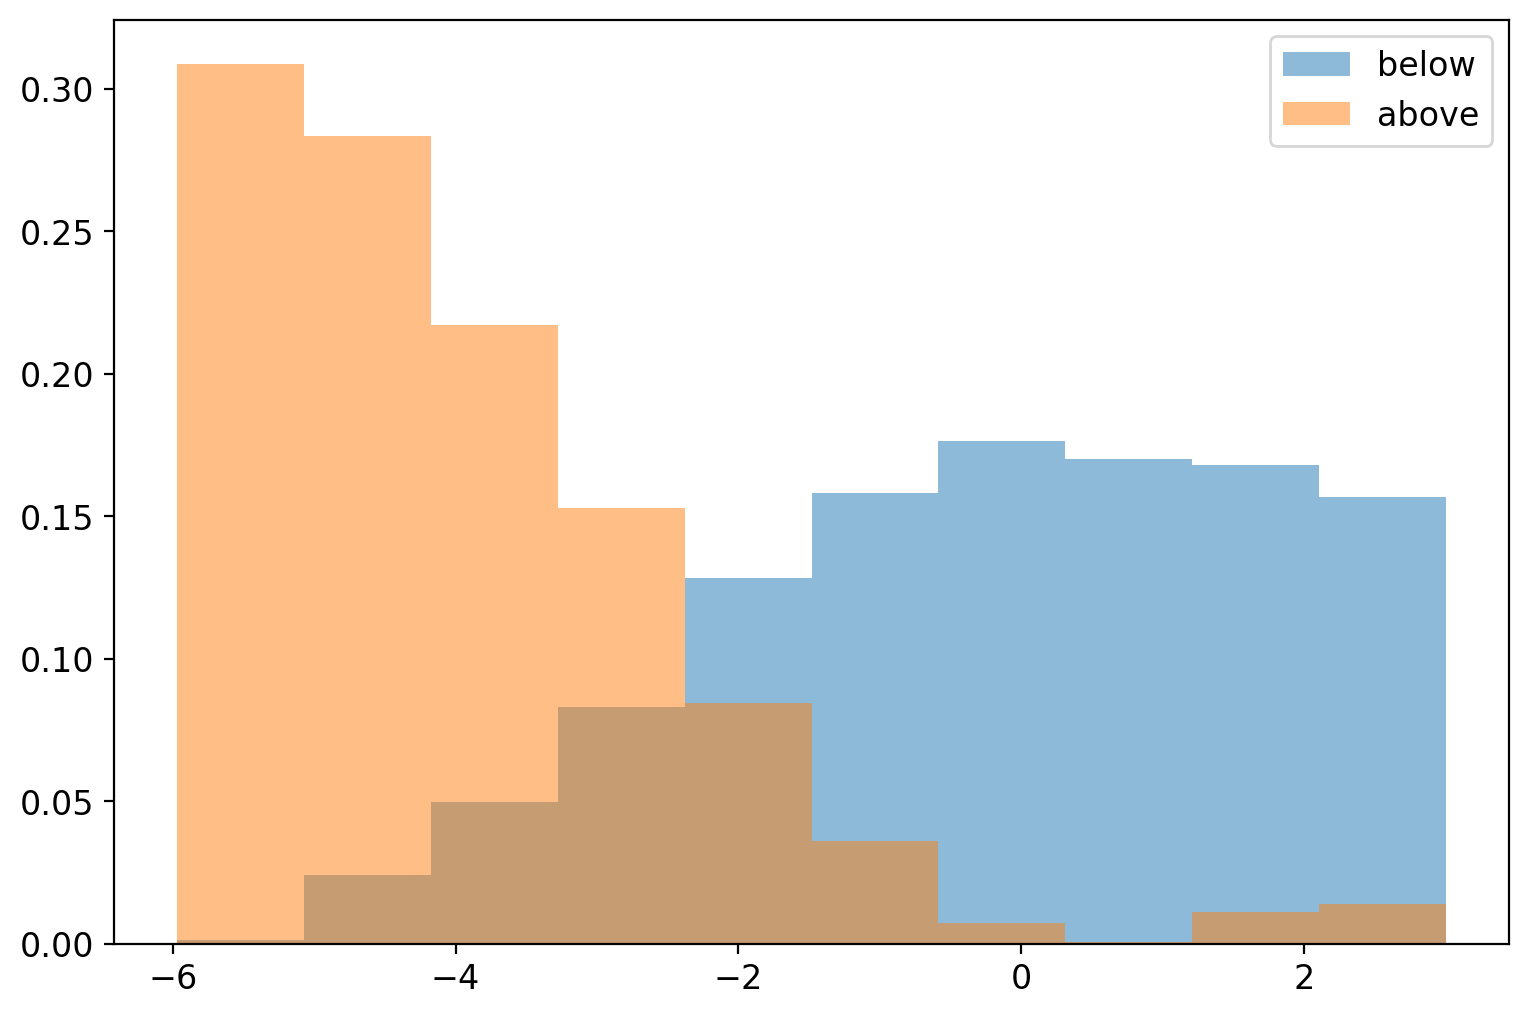

number below: 6395 number above: 3605


In [76]:
#>>>RUN: L6.5-runcell03

_,bins,_=plt.hist(lXin,bins=10,alpha=0.5,density=True, label='below')
plt.hist(lXout,alpha=0.5,bins=bins,density=True, label='above')
#plt.xlim(-6,3)
plt.legend(loc=1)
plt.show();

print("number below:",len(lXin),"number above:",len(lXout))
#Note, these numbers will be slightly different for each run
#due to random generation of data

From the above scenario, we can see that the orange points are below the line from roughly -800 to 0, and the green points are above the line. We can make a histogram of this.We have to be careful with the above integral if we are sampling a Gaussian distribution. In that case, our sampling is biased, not uniform, which means our integral will not be correct, and it will be biased towards the Gaussian we chose. We can write this out as the product of our function times the phase space we are sampling. In this case, the phase space is given by the Hessian of a 2D Gaussian $\frac{\partial^{2} G(x,y) }{\partial x \partial y} $

$\mathcal{I}=\int_{\rm space} f(x,y) \frac{\partial^{2} G(x,y) }{\partial x \partial y} dx dy$

This procedure is known as "Area-based" sampling, and is considered a method of Monte-Carlo Integration. Monte-Carlo integration is a rich field. All high energy physics simulations are based on it. Basically, the function we sample from starts with a collision and computing the probability that this could be any other collision. We then proceed to put this single collision through a point by point simulation, of each particle going through all the detectors. Finally we aggregate our distributions based on this. You will see the usefulness of Monte Carlo Simulation later on. 


<a name='exercises_6_5'></a>     

| [Top](#section_6_0) | [Restart Section](#section_6_5) | [Next Section](#section_6_6) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-17.1.1</span>

How would you compute the integral of this function over the range `[-6,3]`? Select the correct answer below:

- The integral is equal to the number of points above the line defined by our function.
- The integral is equal to the number of points between zero and the line defined by our function.
- The integral is equal to the fraction of points that we calculated, times the area of the region that we defined.
- The integral is equal to the fraction of points between zero and our function, times the area of the region where the simulation is carried out, which must use `0` as an upper bound.


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
The integral is equal to the fraction of points between zero and our function, times the area of the region where the simulation is carried out, which must use `0` as an upper bound.
</pre>
        
**EXPLANATION:**

The integral is defined as the area under the function, relative to zero. If we include zero as a bound in our simulation, then we can simply multiple the fraction of points between our curve and zero by the total area of the simulation region.
    
</div>


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-17.1.2 </span>

Calculate the integral numerically. Remember to correctly apply a negative sign, if applicable.

How does your numerically calculated value compare to the expected value? You can explicitly solve the integral mathematically, or use a built-in `scipy` integration method to compare to your Monte Carlo integration.

In [14]:
#>>>SOLUTION

#Monte Carlo solution
area=(ymax-ymin)*(xmax-xmin)
adjust = abs(ymax)*(xmax-xmin)

lN=100000
print('Monte Carlo integration:', -area*len(lXout)/lN + adjust)


#COMPARE TO INTEGRAL
# call quad to integrate f from -6 to 3
res, err = quad(f, -6, 3)
print('numerical integration:', res)

Monte Carlo integration: -2431.9940689883315


NameError: name 'quad' is not defined

<a name='section_18_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.2 Monte Carlo Diffusion</h2>  




A good place to start with any Monte Carlo system is a system of random walks. To start with lets consider a simple diffusion model. This works by considering a particle moving along with velocity $\vec{v}$ in a specfic direction. For an distance $\ell$ it will move and scatter. The scatter will cause an angular spread in a random direction, which is given by the energy of the atmosphere. 

To build a simple model, lets consider just brownian motion, where we simulate each timestep, we give it a random kick corresponding to a collision for a single particle, we can thus write this as randomly choosing a angle every time step, and simulating the particle motion. 

For each particle, we will step the particle 100 times. Furthermore, to show some intelligent thought about parallel computing, we are going to do this simultaneously for 1000 particles at a time. That means we will make an array of 1000 particles and run our simulation simultaneously. 

Note, in the last little bit of the code, we will make a rotation matrix that we tile. Then we apply the roatoin matrix to our velocities using the following Einstein summation notation. 

$$
v^{u}_{j} =  R^{u}_{\theta,ij} \left(v^{u}_{i}\right)
$$


mean distance form center 2.16526002710091
stdard deviaition in x: 1.7247568385171765 y: 1.7236340957671237
velocity 1.2464160881223671


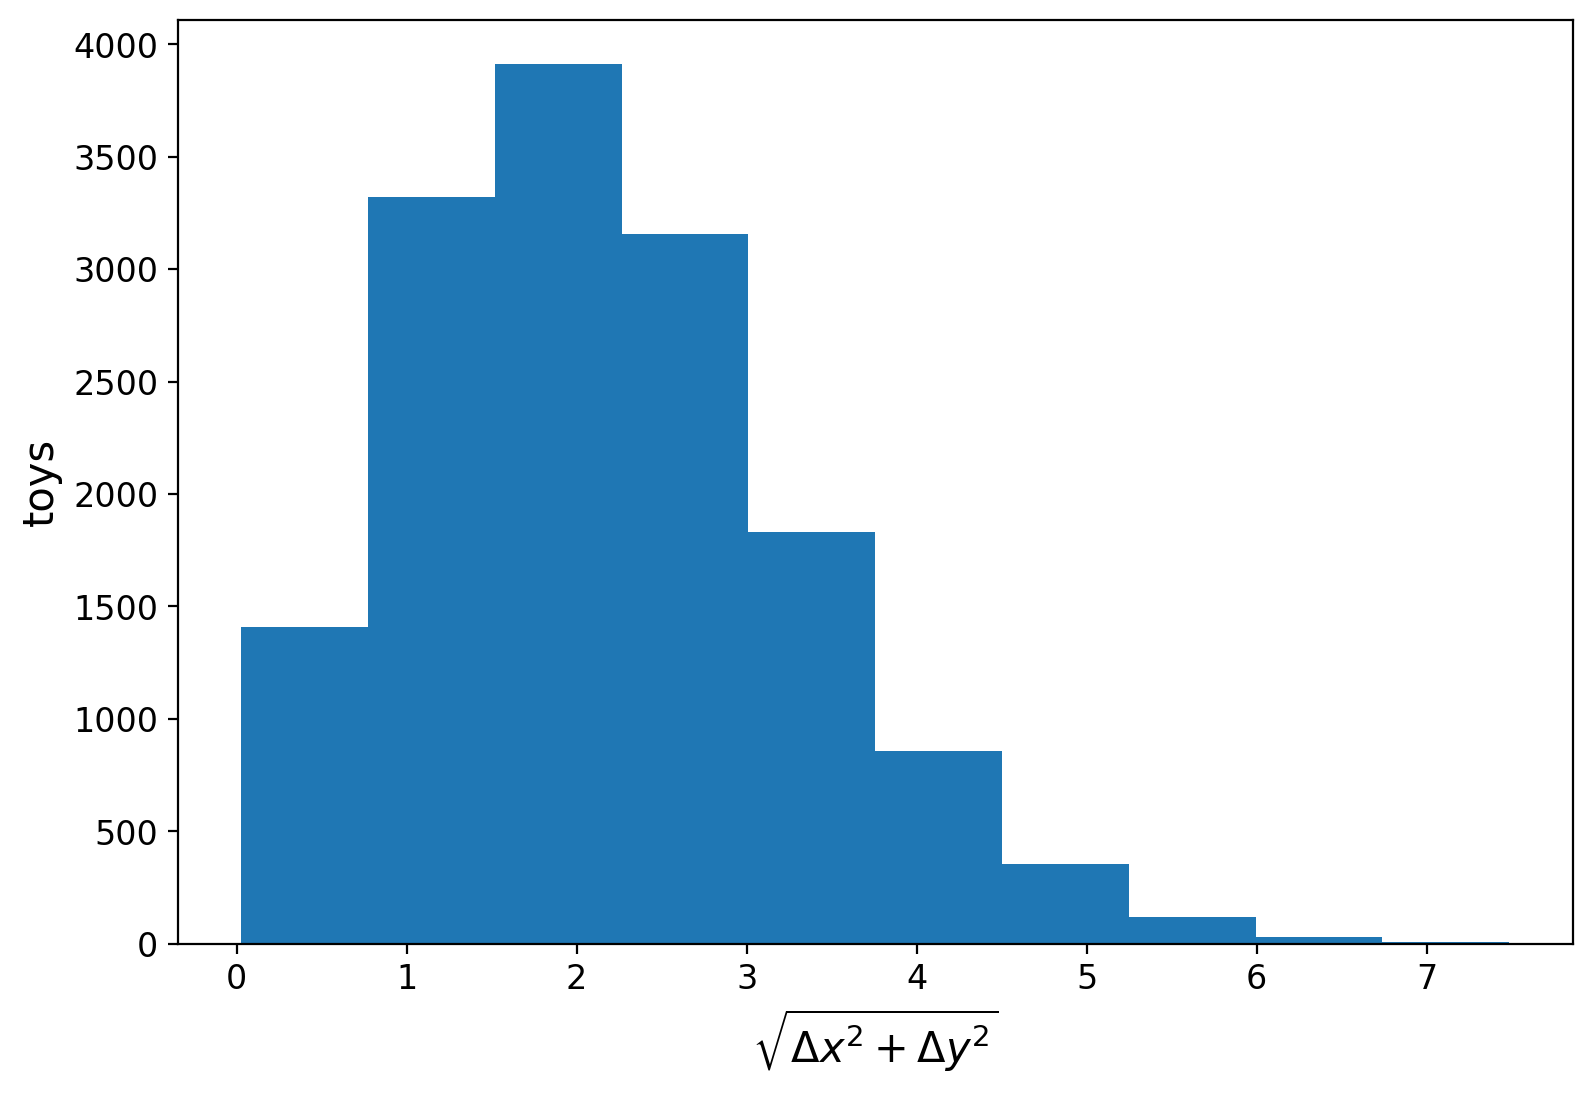

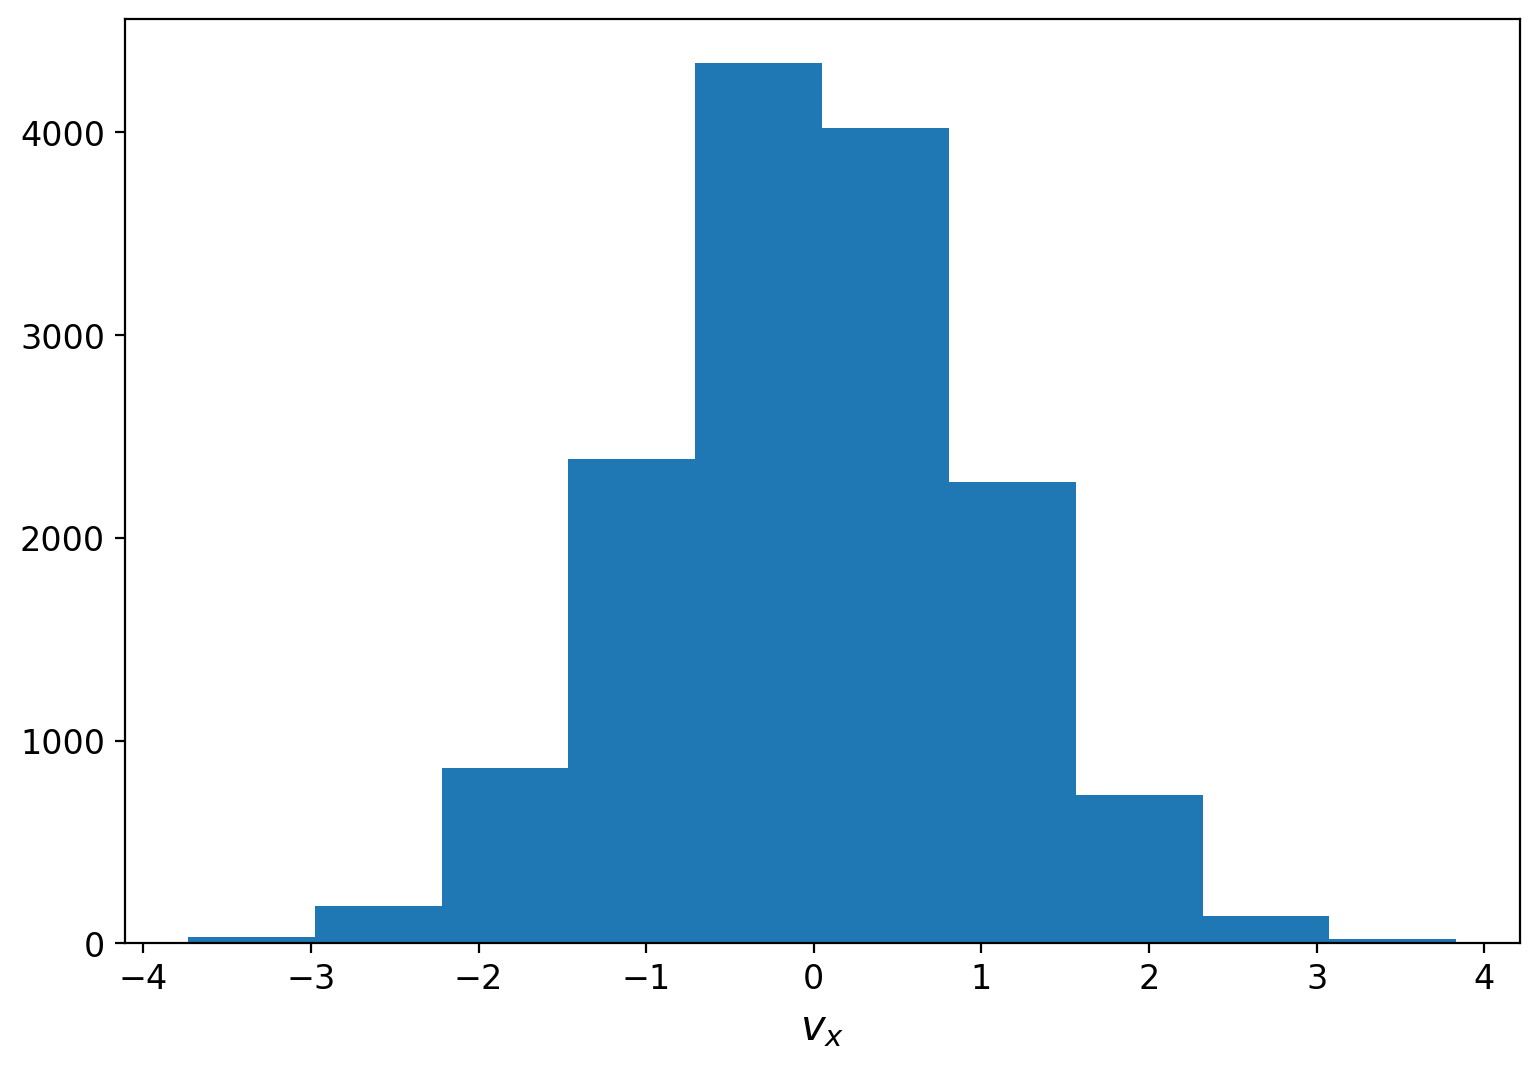

In [90]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2)) #lets assume all particles are randomly distributed
    for t0 in range(nsteps):
        partpos += partvel*dt
        #now at each step we will assume the particle collides with another
        opartvel = np.random.normal(0,1,(ntoys,2)) #Sample the "other" particles momentum
        comvel   = 0.5*(partvel + opartvel) #Now compute the comvoing velocities in the COM frame
        difvel   = 0.5*(partvel - opartvel) #Now compute the collision velocity in the COM frame
        theta = np.random.uniform(0,2.*np.pi,ntoys)#elastic collisiosn in the COM equate to equal energy ad a theta rotation
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        #shape things so they are right
        RMat  = np.swapaxes(R,0,2)
        #RMat  = np.reshape((np.tile(R, ntoys)).T,(ntoys,2,2))#make the Rotation Matrix for all toys
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel) #Now rotate the colliding velocitiies over all toys
        partvel = comvel+tmp
    
    if iDump:
        plt.hist(np.sqrt(partpos[:,0]**2+partpos[:,1]**2))
        plt.xlabel("$\sqrt{\Delta x^2 + \Delta y^2}$")
        plt.ylabel("toys")
        print("mean distance form center",np.mean(np.sqrt(partpos[:,0]**2+partpos[:,1]**2)))
        print("stdard deviaition in x:",np.std(partpos[:,1]),"y:",np.std(partpos[:,0]))
        print("velocity",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
        plt.show()
        plt.hist(partvel[:,0])
        plt.xlabel("$v_{x}$")
        plt.show()
MCSim()


Now, we can reconcile these numbers with our knowledge of Brownian motion, noting how things diffuse. We can write this, we would like to confirm our measurement of the RMS $x_{\rm rms}=\sqrt{\langle \bar{x}^2 \rangle}$

We can think of this as the width of the distribution after $N$ collisions with a collision length of $\ell$. For a time $t$ and a velocity $v$ the number collisions will be $N=\frac{vt}{\ell}$ or in otherwods

$$
x_{\rm rms} = \sqrt{N}\ell = \sqrt{vt\ell} 
$$

Other ways of thinking this are in terms the velocity

$$
\frac{d}{dt}\langle \bar{x}^2 \rangle = 2x\cdot\frac{d \bar{x}}{dt} = 2\langle \bar{x}\cdot\bar{v} \rangle\approx2\langle v^2\rangle t
$$
From Brownian motion (see section 5 [here](https://scholar.harvard.edu/files/schwartz/files/2-diffusion.pdf)). What this means is we can predict the rate of diffusion exactly analytically here and compare. 

To that, lets just do some quick computations to check our simulation. 

First, the average total velocity in two dimensions can be defined as $\langle\sqrt{v_{x}^2+v_{y}^2}\rangle$ since $v_{x}$ and $v_{y}$ are both gaussian distributions with width $1$, the sum of these distributions is known as a [Rayleigh distribution](https://en.wikipedia.org/wiki/Rayleigh_distribution) ($f(x,\sigma)$), which is  just a $\chi^{2}_{2}$ distribution of 2 degrees of freedom with an additional scale term.  

$$
\langle\sqrt{v_{x}^2+v_{y}^2}\rangle = \langle f(x,\sigma) \rangle = \sigma_{v_{i}}\sqrt{\frac{\pi}{2}}
$$

From the above, we can immediately calculate the average RMS of $x$ for a single collision noting that our simulatino forces the length to a collision as $\ell=2vdt$ since both particles are moving at each other

$$
\langle \ell \rangle =  2 v dt \\
x_{\rm rms} = \sqrt{N}\ell= \sqrt{N}\sqrt{2\langle v^2\rangle} dt = \sqrt{N2\frac{\pi}{2}}dt
$$


For $\sigma_{v_{i}}=1$ as in this case, we have then that the 

$$
x_{\rm rms} = \sqrt{2\sigma^{2}_{v_{i}}\frac{\pi}{2}}\sqrt{N}dt
$$

We can compute this below

In [88]:
print("Rayleigh",np.sqrt(np.pi/2))
print("Rayleigh dt sqrt(N)",np.sqrt(np.pi/2)*np.sqrt(2)*0.01*np.sqrt(10000))
print("Expected mean distance form center: ",np.sqrt(np.pi/2)*np.sqrt(2)*0.01*np.sqrt(10000)*np.sqrt(np.pi/2))
#

Rayleigh 1.2533141373155001
Rayleigh dt sqrt(N) 1.772453850905516
Expected mean distance form center:  2.221441469079183


This agrees well with our standard deviation of the position $x$ above which is $x_{rms}$=1.7

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-18.2.1</span>

Show that the velocity distribution remains the same as we run our simulation over time? 

In [91]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2))
    print("velocity Before:",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,1,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        partvel = comvel+tmp
   
    print("velocity After:",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
MCSim()


velocity Before: 1.25571516625718
velocity After: 1.2508572135585645


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
No change
</pre>
        
**EXPLANATION:**
    
This is one of the remarkable things about these systems is that at high level, we can observe conserved quantities with these simulations even though we are only looking at the motion of a few particles at a time. Very amazing. 
    
</div>

<a name='section_18_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.3 Adding Elements of Realism</h2>  



Now, given our Monte Carlo simulation, we can start to add element of realism, this will slow our monte carlo. Lets put a wall in our particle and a particle hits the wall, we need to invert the velocity. Which means we just flip our particle velocity as we go along. 

Let's go ahead and implement this. For this all, we need to do is if the x-position of our sample is $>$ the wall value (say $x=2$) then we flip the velocity and not simulate an elastic collision. 

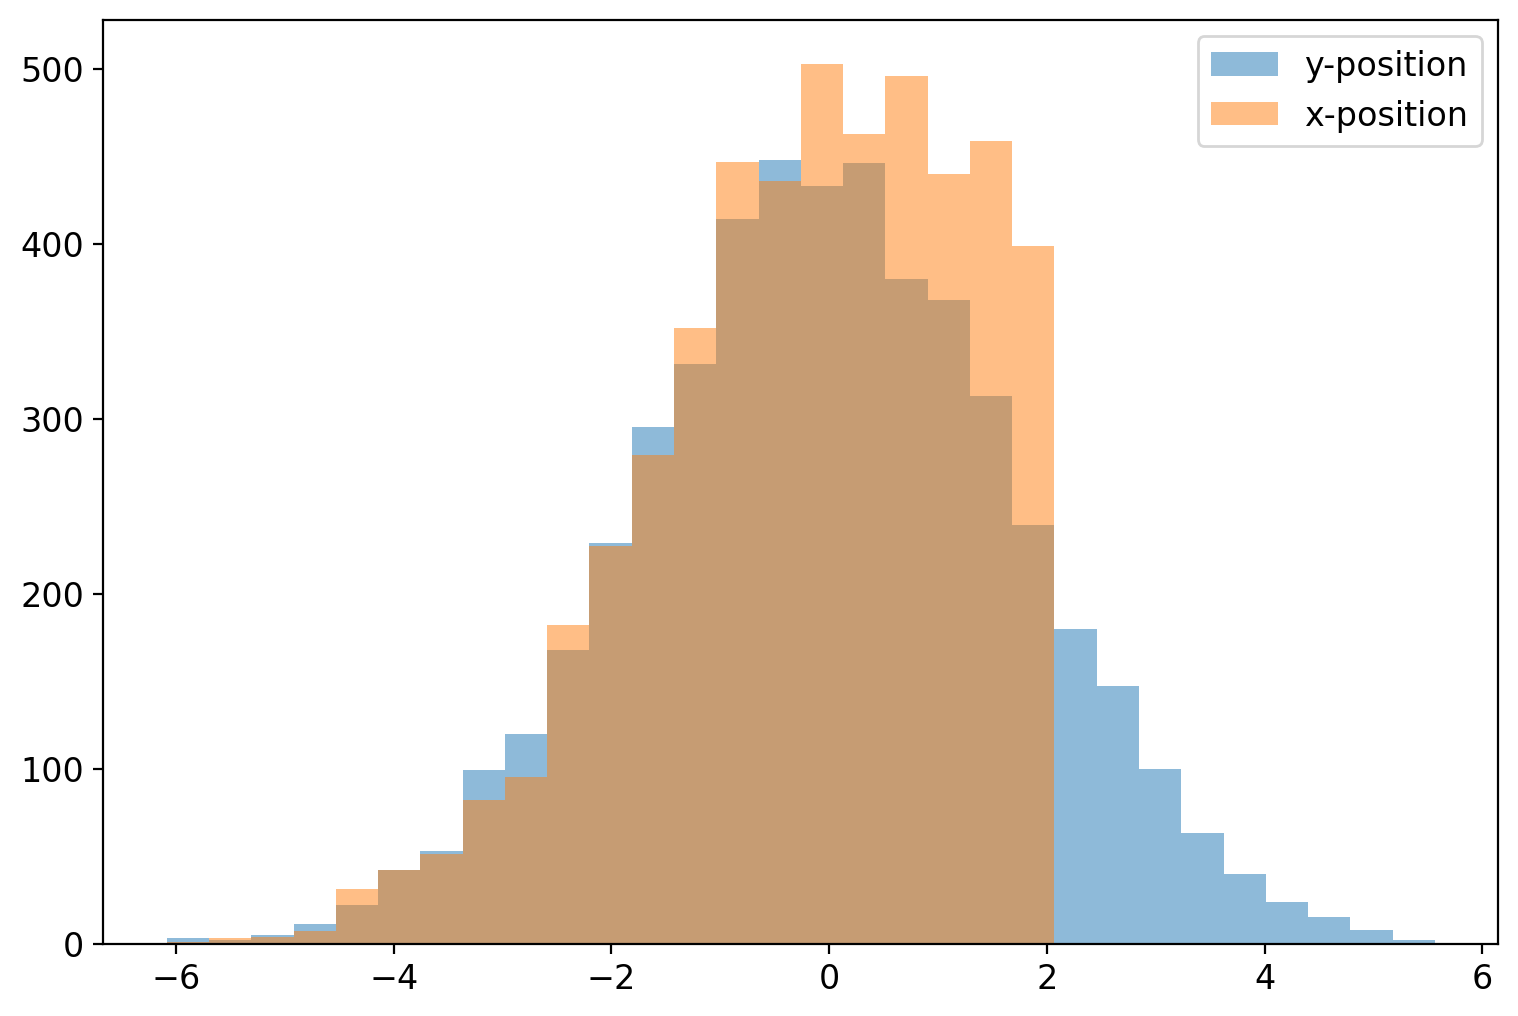

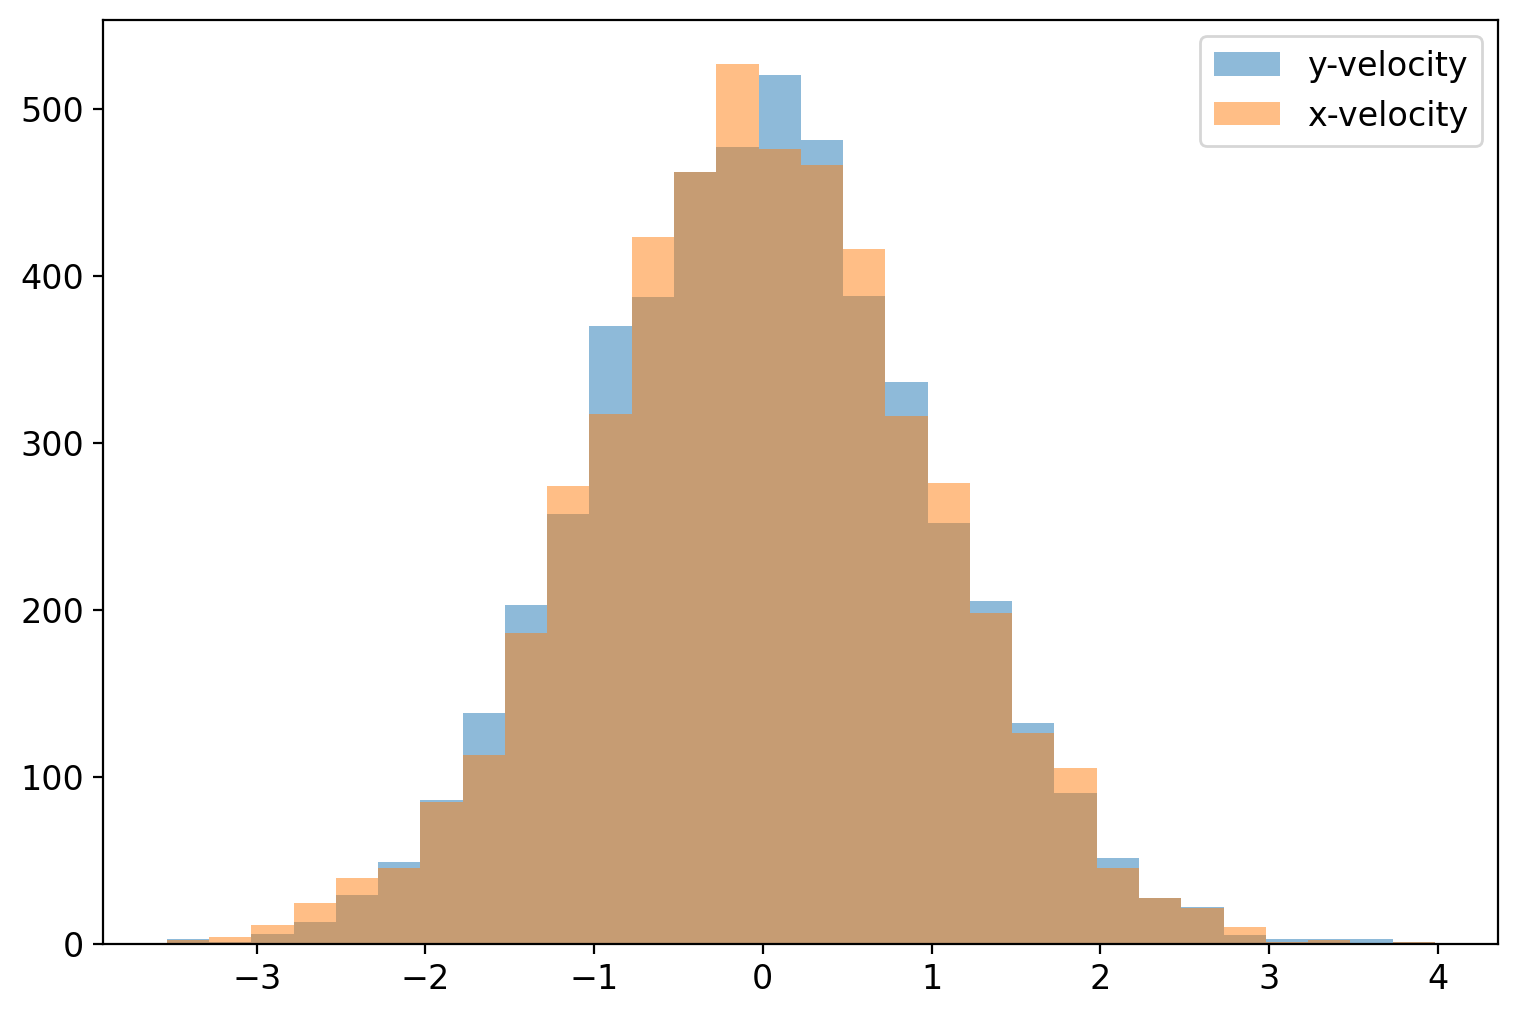

In [92]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,1,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)        
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        #Now, lets add our velocity if its not at the well
        partvel[partpos[:,0] < 2] = comvel[partpos[:,0] < 2]+tmp[partpos[:,0] < 2]
        #And lets flip it if it is at the wall
        partvel[partpos[:,0] > 2] = -partvel[partpos[:,0] > 2]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

Now, we could do some thing even more complicated by imagining that we have a tube and we are looking at the Brownian motion within the tube. Particles, which hit the tube will then have their velocity reflected in the opposite direction. In other words, we have 

$$
v_{i} = - v_{i} \forall i {\rm~ where~} r_{i}=\sqrt{x_{i}^2+y_{i}^2} > r_{\rm tube}
$$

or reflecting particles that try to escape the tube. Let's make a tube of radius $2$, lets go ahead and do it!

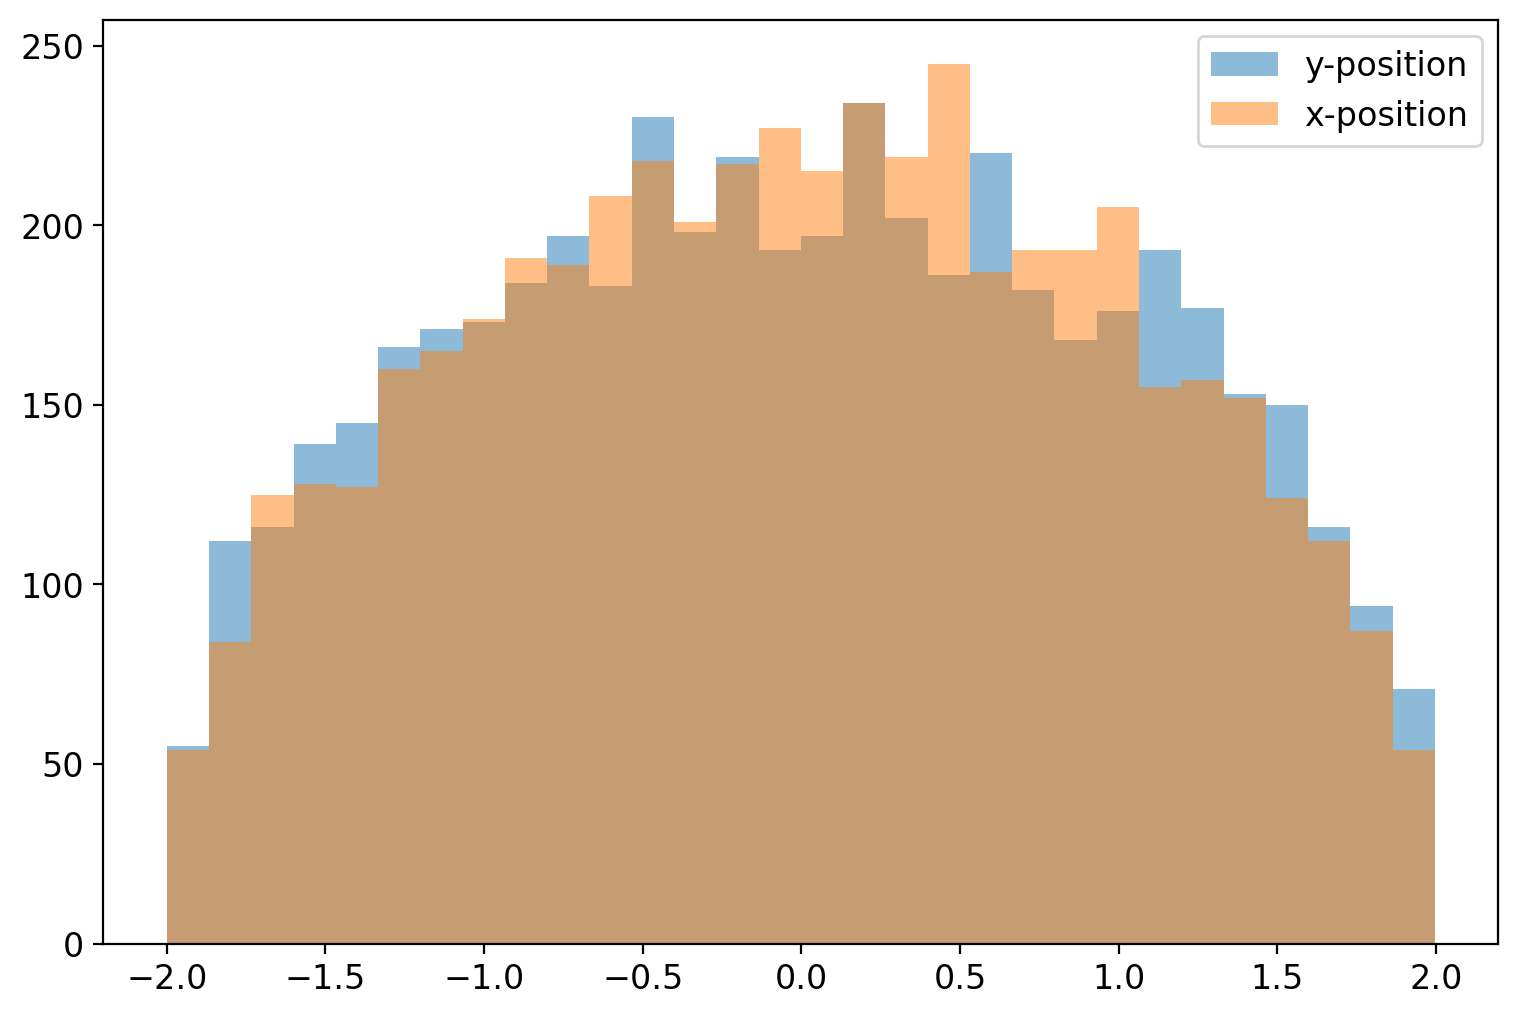

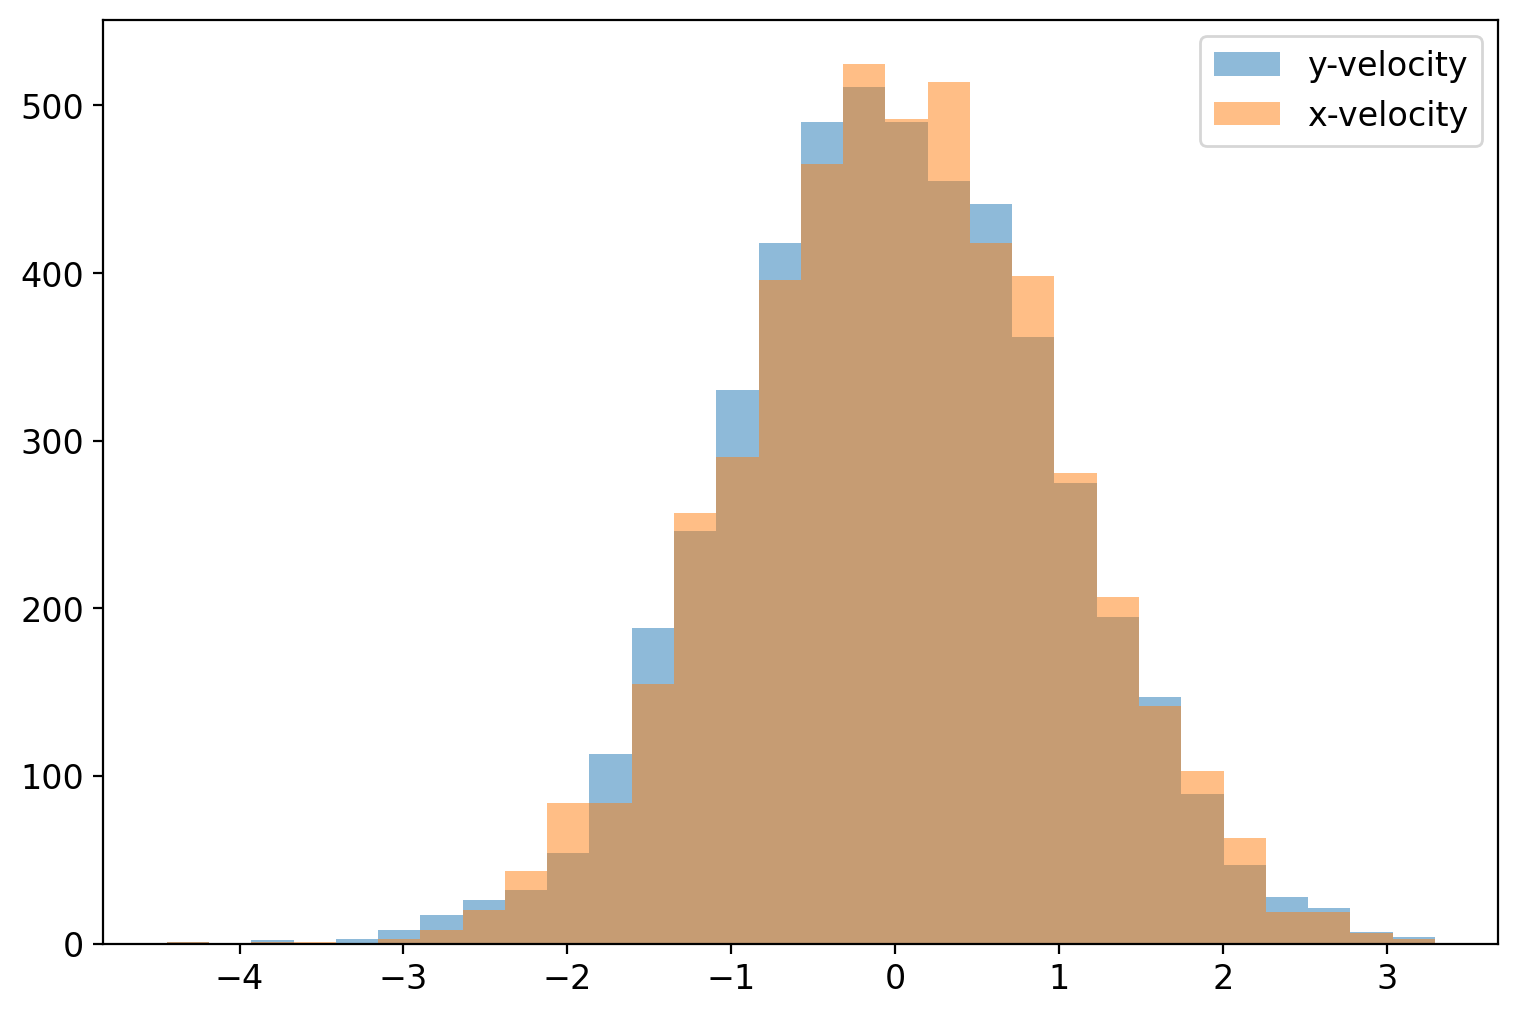

In [93]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,sigmav,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,sigmav,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        #Now define inside the tube
        intube  = partpos[:,0]**2+partpos[:,1]**2 < 4
        partvel[intube]  = comvel[intube]+tmp[intube]
        partvel[~intube] = -partvel[~intube]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

We can quickly do many more complicated things, the nice thing is that all of this really just needs us to program it in. Its important also here, to note that we are taking advantage of the numpy scheme to parallelize everything. This allows us to simulate 1000s of particles at the same time, and makes everything nice and fast. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-18.3.1</span>

How does the distribution of the particles change if we increase the velocity spread of the particles? 

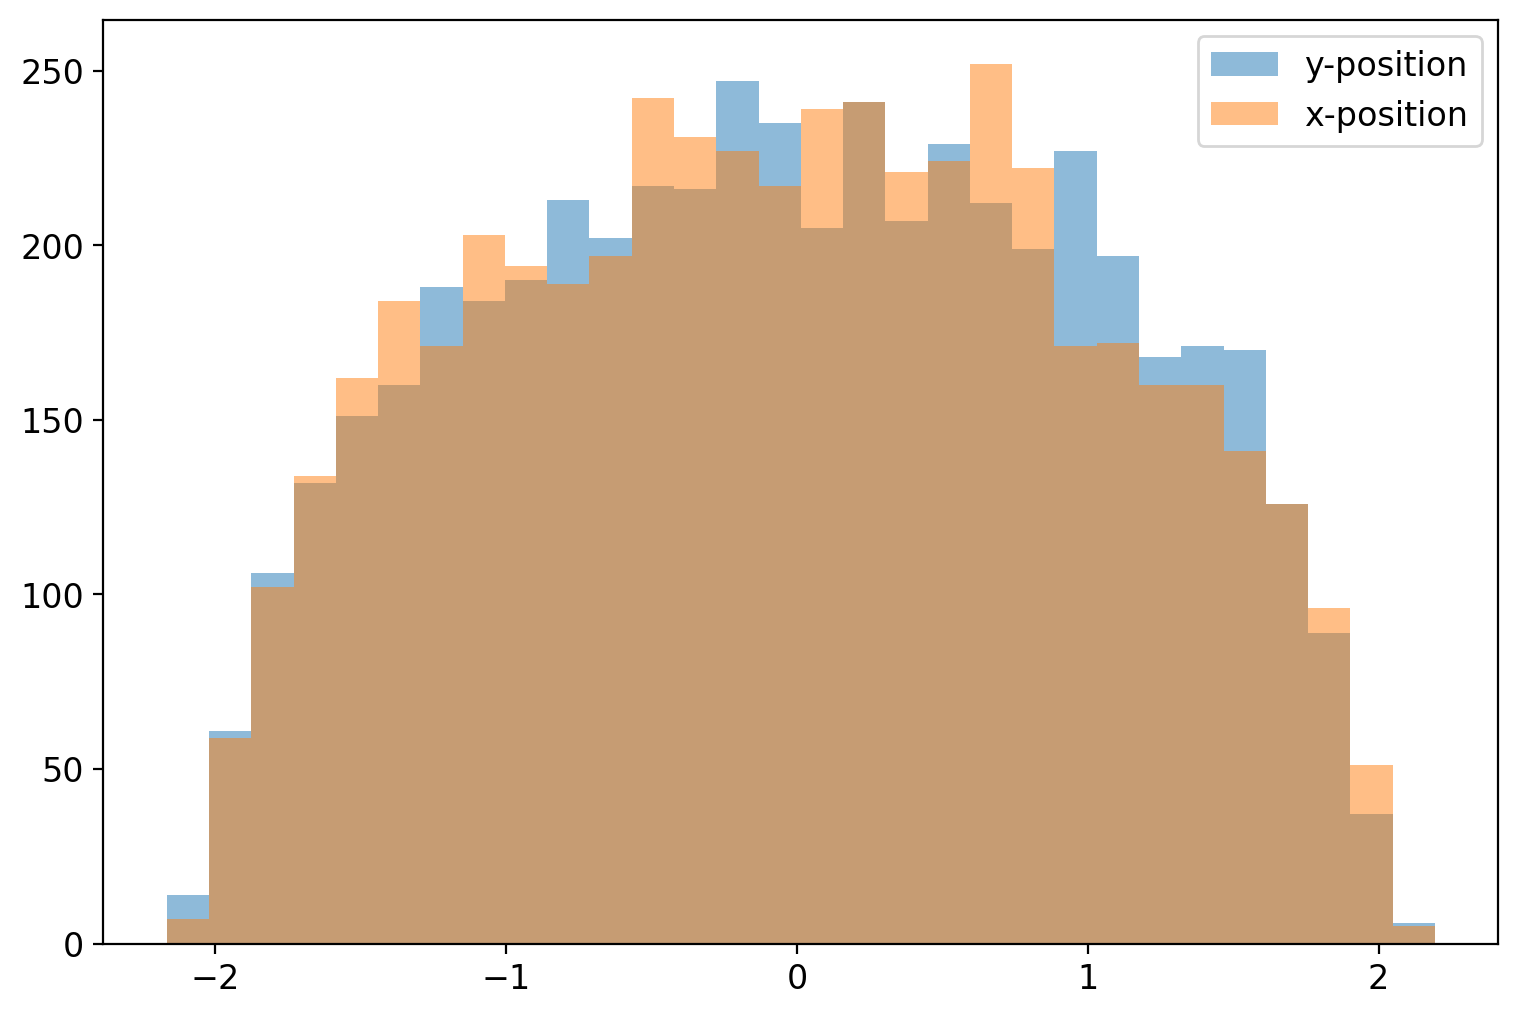

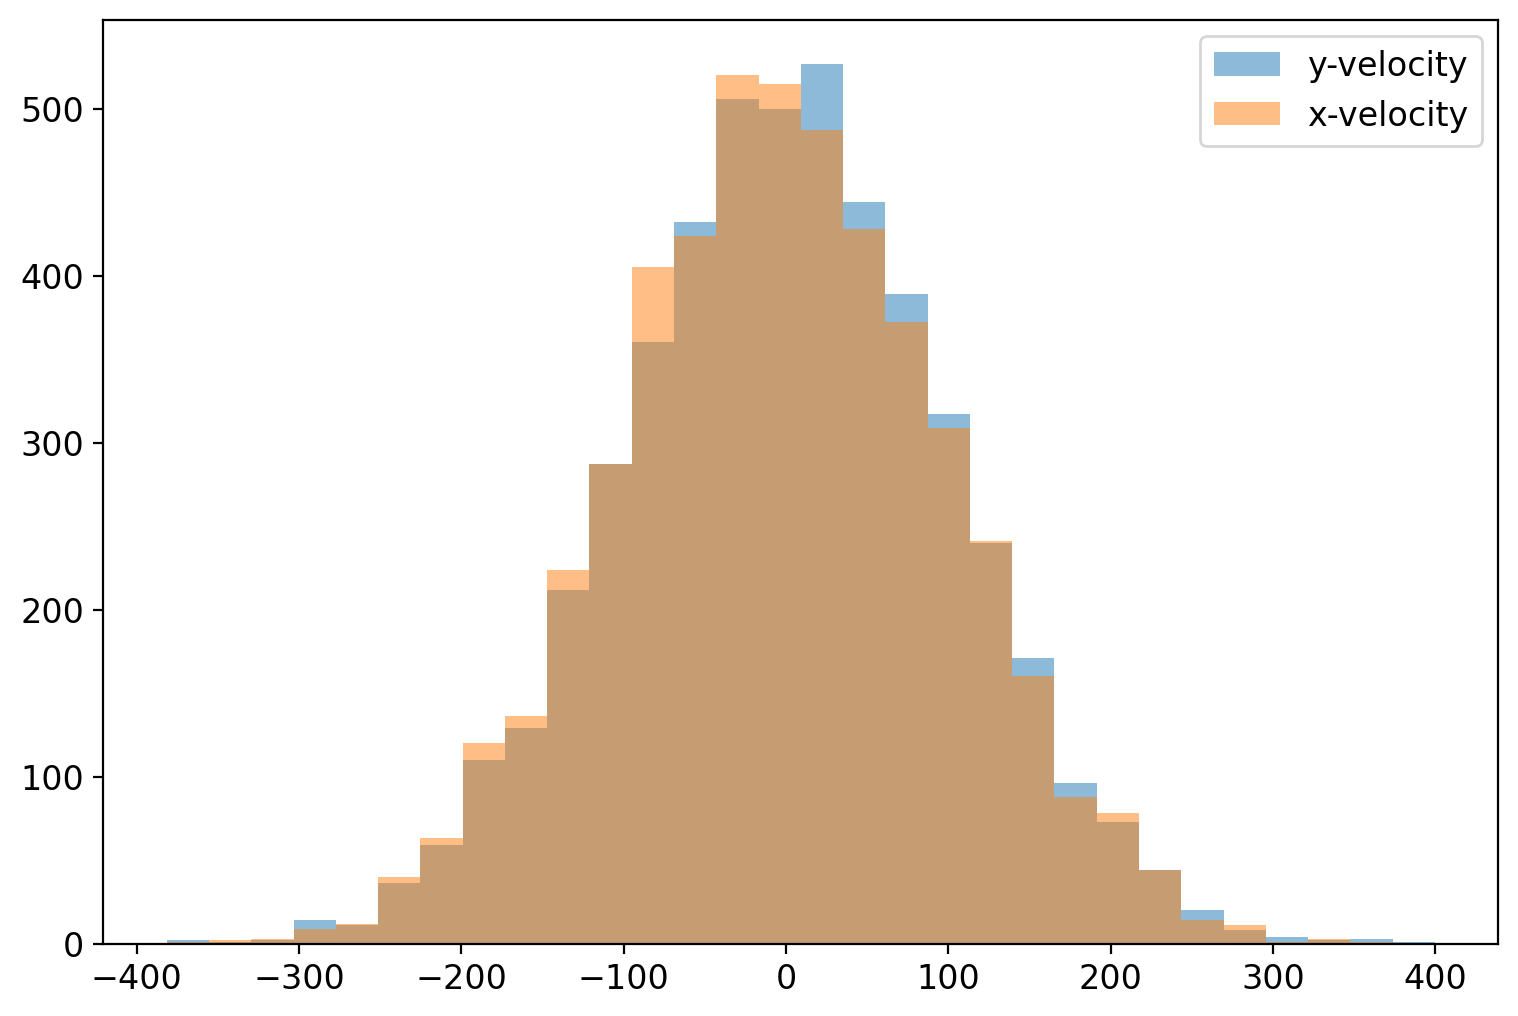

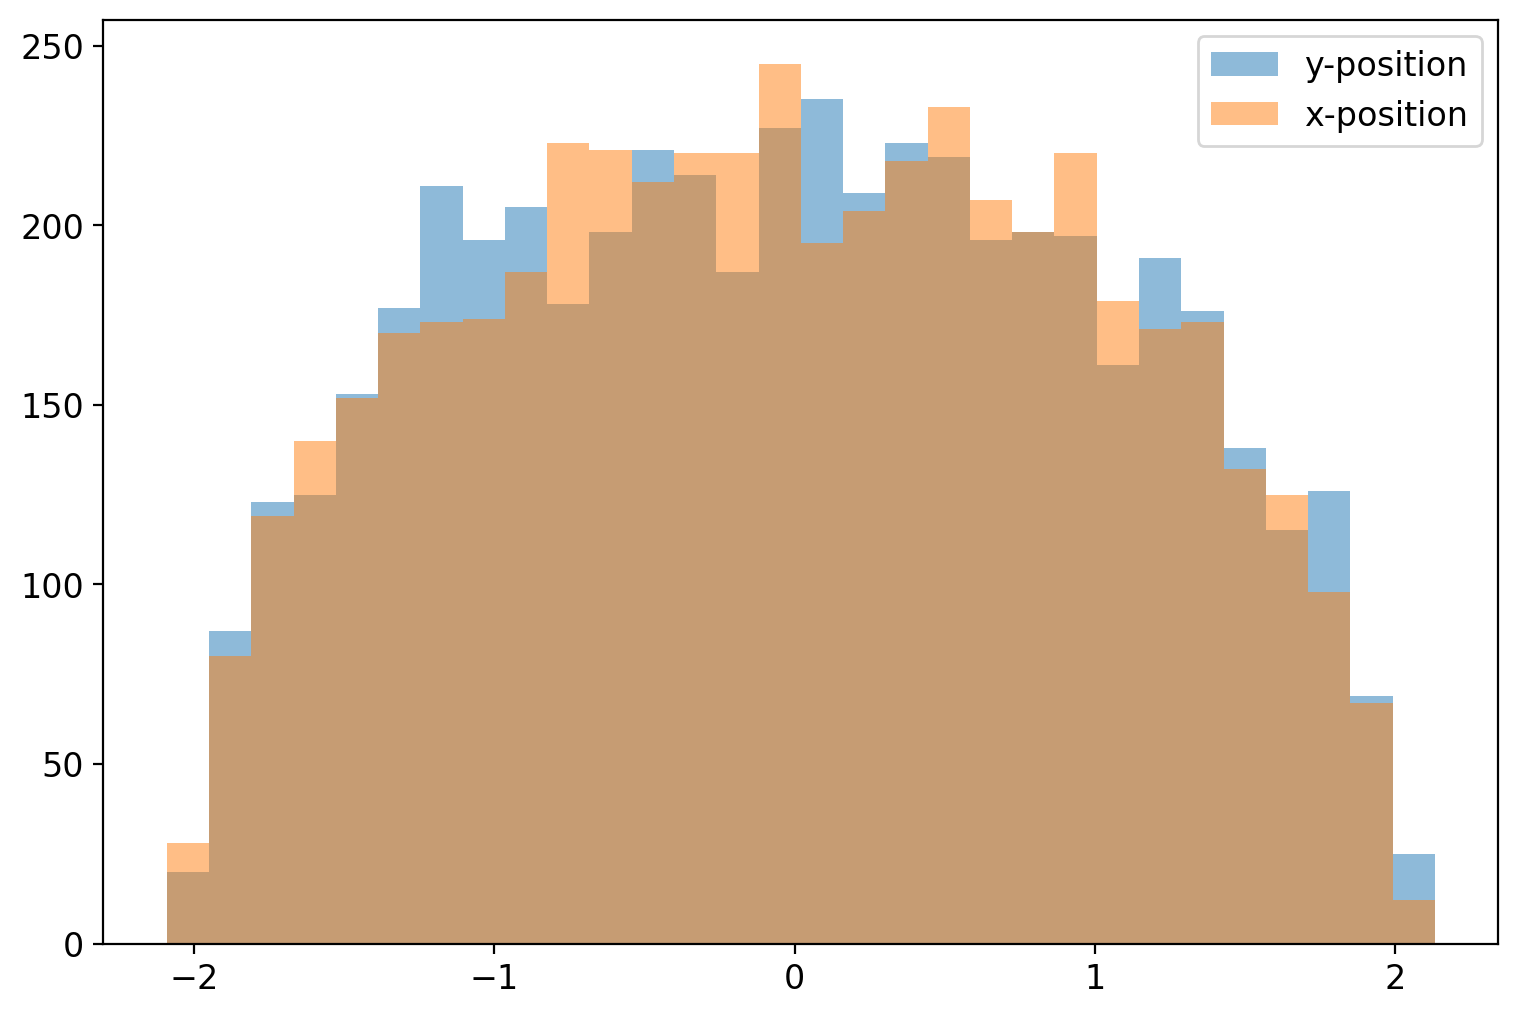

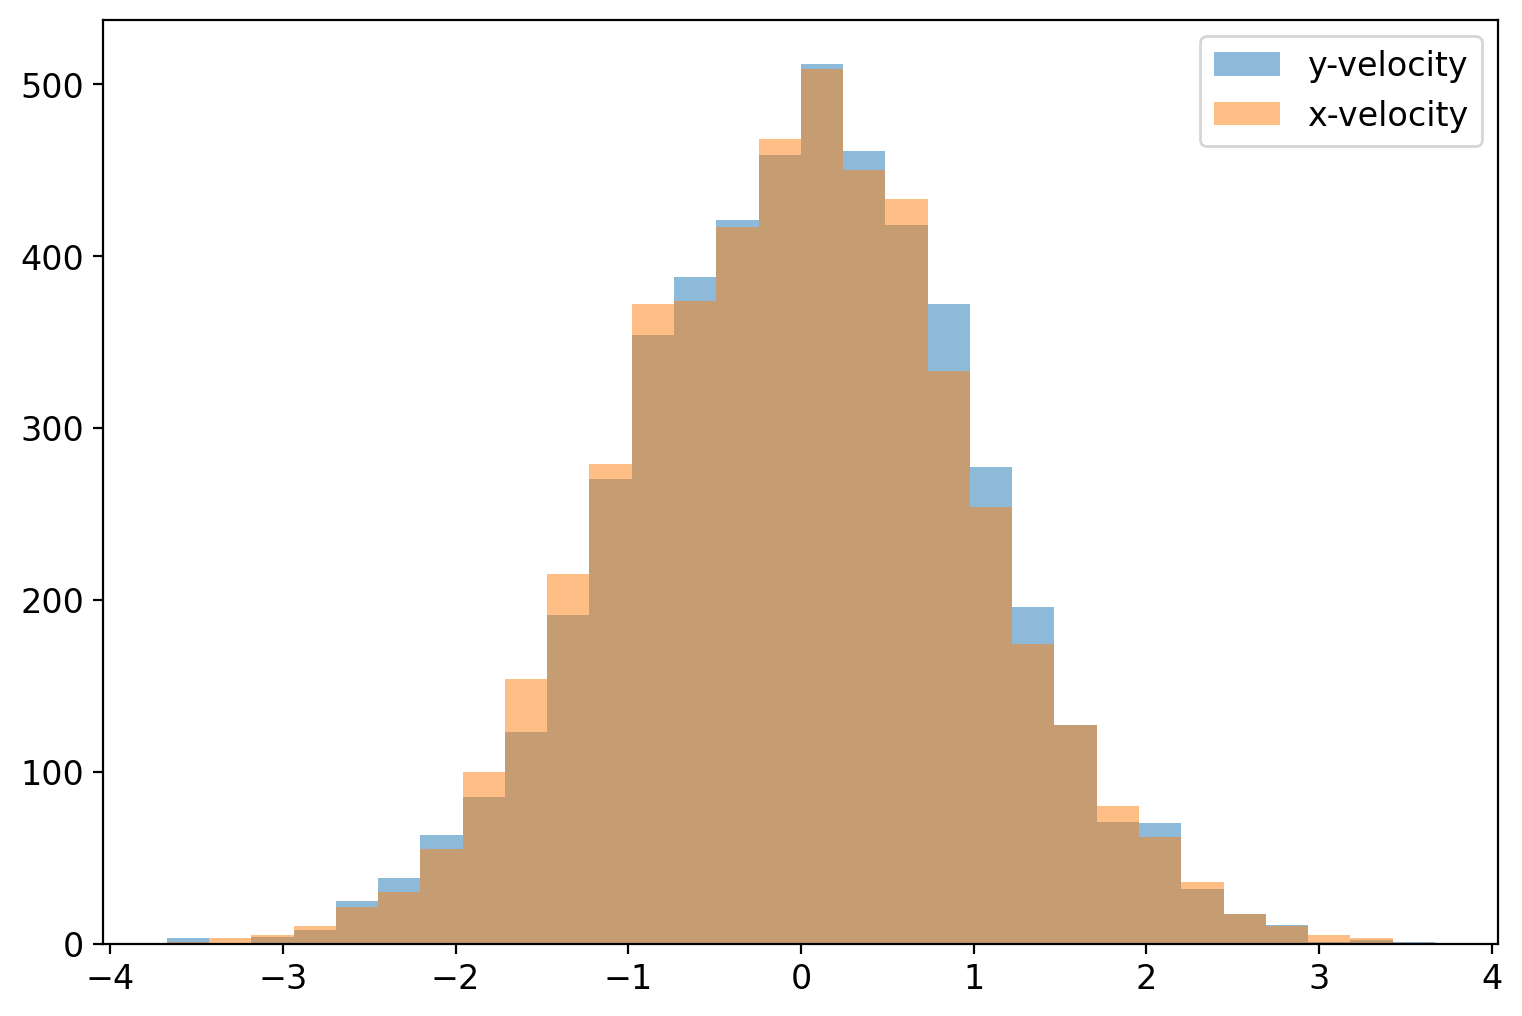

In [94]:

MCSim(sigmav=100,dt=0.001,nsteps=100000,ntoys=5000)
MCSim(sigmav=1,dt=0.1,nsteps=100000,ntoys=5000)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-18.3.2</span>

What would the distribution of the particles look like if you had a box distribution in $x$ and $y$ with edge of 2?

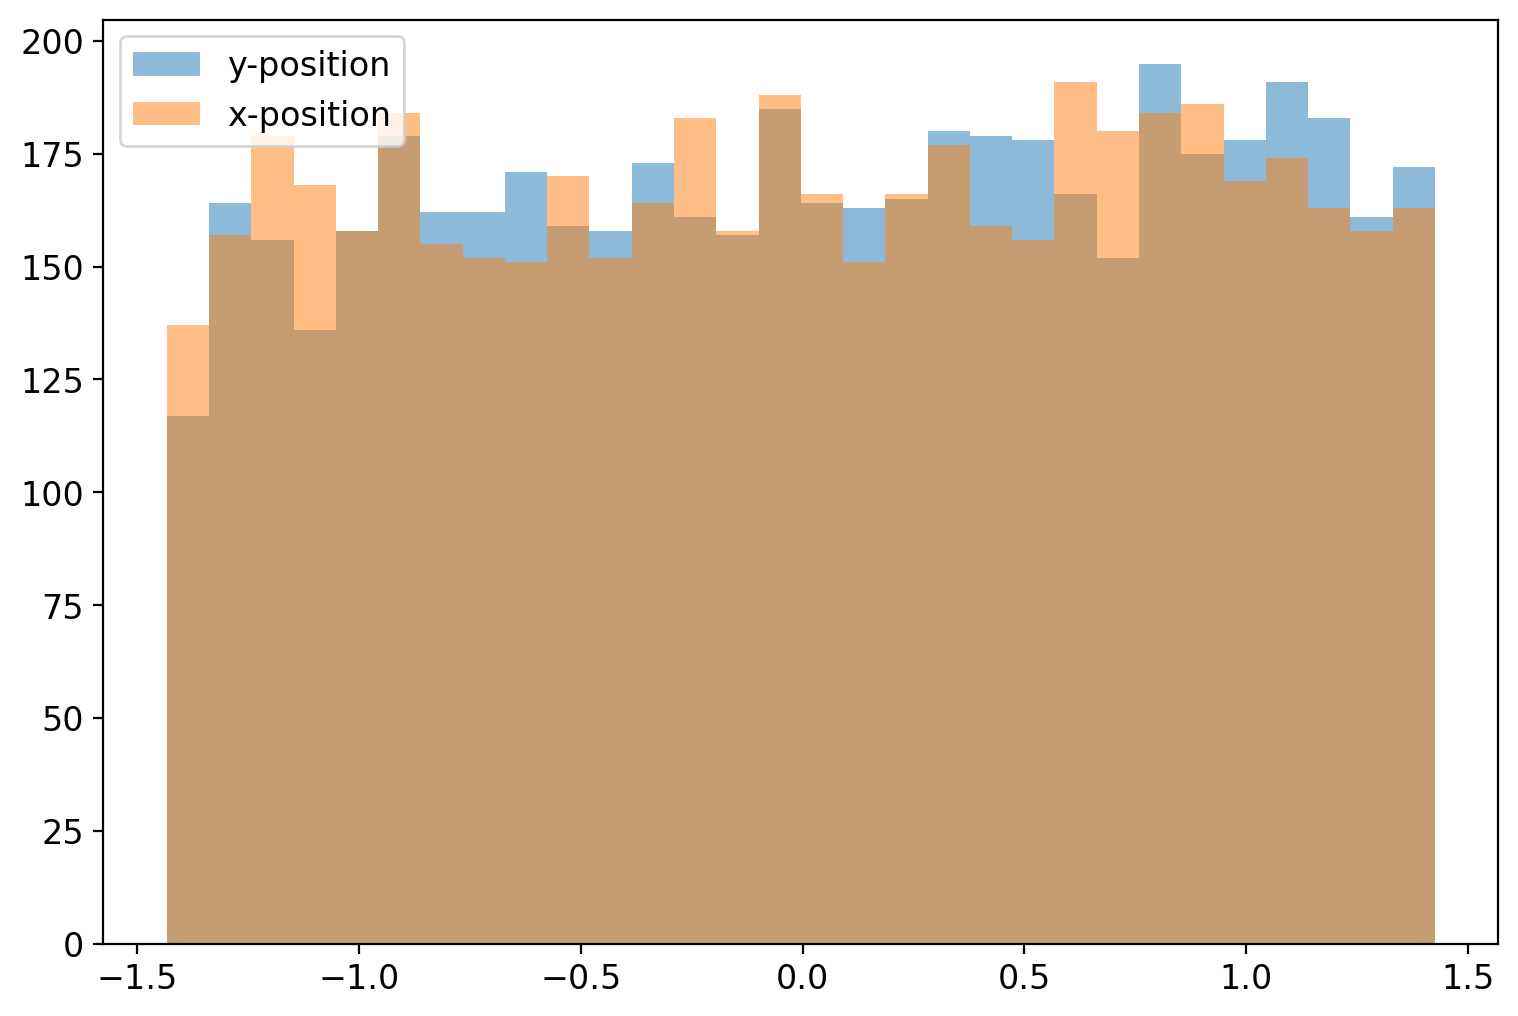

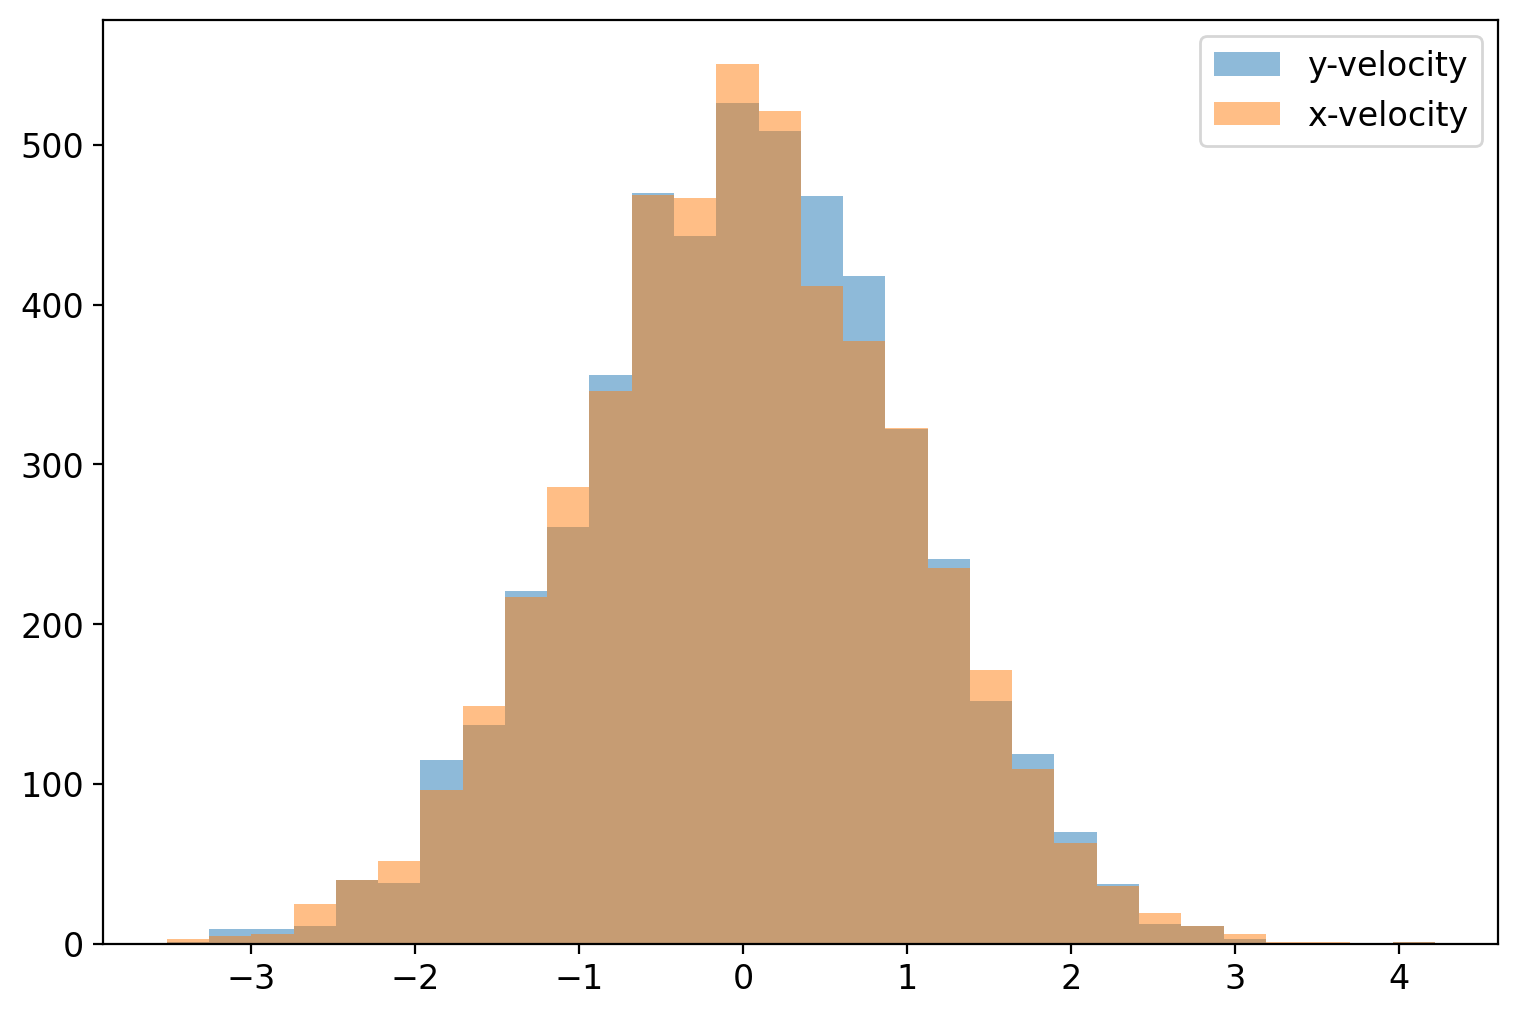

In [95]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,sigmav,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,sigmav,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)#elastic collisiosn in the COM equate to equal energy ad a theta rotation
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        inbox  = (partpos[:,0]**2 < 4)  & (partpos[:,1]**2 < 4)
        partvel[inbox]  = comvel[inbox]+tmp[inbox]
        partvel[~inbox] = -partvel[~inbox]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

<a name='section_18_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.4 Modelling Physics Observables : Bragg Scattering for Proton Therapy </h2>  



There are a broad range of physics processes that we can use Monte Carlo to simulate. They typically involve scenarios where we don't have a good understanding of the analytic for of the whole system, but we understand how it works. 

We can embed all of our knowledge into understanding how the system works into a simulation. A simulation that relies on sampling of events, and modelling the effects in an event by event way is deemed a Monte-Carlo simulation, there are a huge number of Monte Carlo simulations. 

Lets start by simulating a particle passing through matter. This is one of the most common simulations, because we understand all the different sub processes well, but when we put them all together they are rather complicated.

We will do this in the context of proton therapy data. Proton therapy is a way to treat cancerous cells through a non invasive approach whereby we fire energetic proton beams to various body parts. These beams are precisely controled to deliver a dose of radiation at just the right spot. Let's go ahead and do a simple simulation. 

What we are going to do first, is model the energy loss in matter, given by 

$$
-\frac{dE}{dx} = \frac{4\pi nz^2}{m_{e}c^{2}\beta^{2}}\left(\frac{e^{2}}{4\pi\epsilon_{0}}\right)^{2}\left(\log\left(\frac{2\gamma^{2}m_{e}c^{2}\beta^{2}T_{\rm max}}{I(1-\beta)^{2}}\right)-\beta^{2}-\frac{\delta(\beta\gamma)}{2}\right)
$$

Now to get this to work completely we need to compute the Ionization energy. The ionization energy is stored in a bunch of places. In particular, you can find it in [figure 34.5](https://pdg.lbl.gov/2022/reviews/rpp2022-rev-passage-particles-matter.pdf), this depends on the nuclear stucture, but is roughly flat as a function of the nuclear charge as you get to higher elements. For our purposes, we will will just parameterize this as as table. 

In addition, we also need the atomic masses $A$ of all the objects, we can again take this from an online source. For people familiar, we are taking this from the particle simulation code Geant in Fortran. Let's plot them below. 

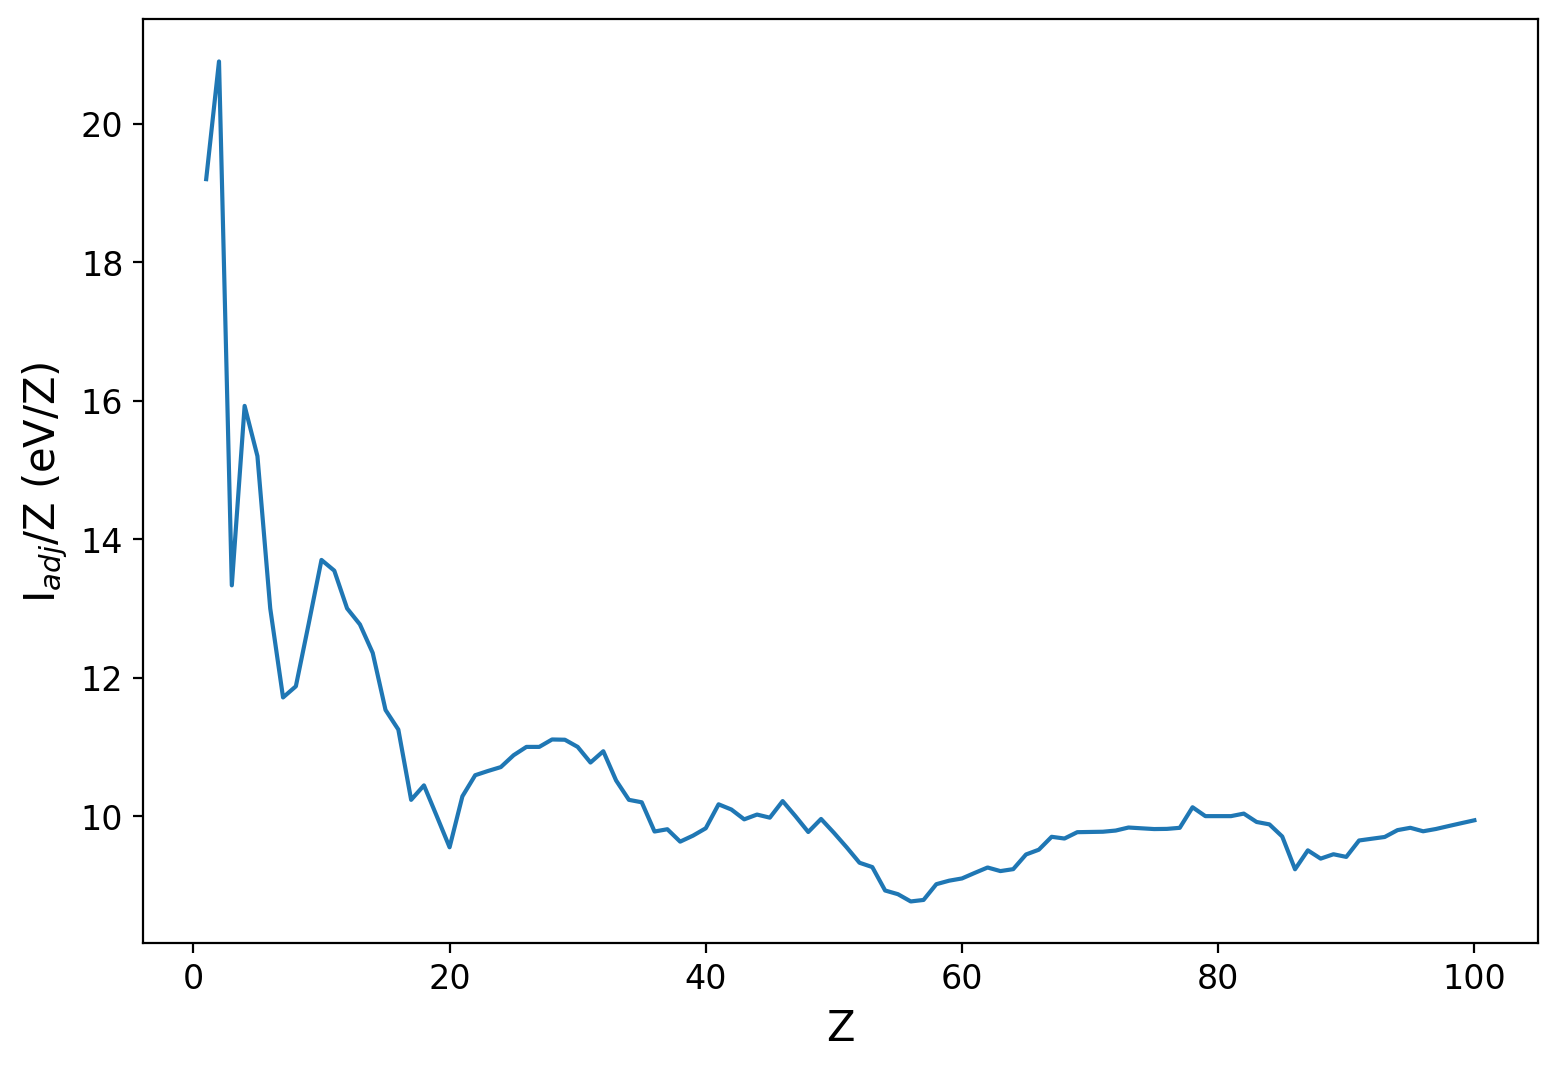

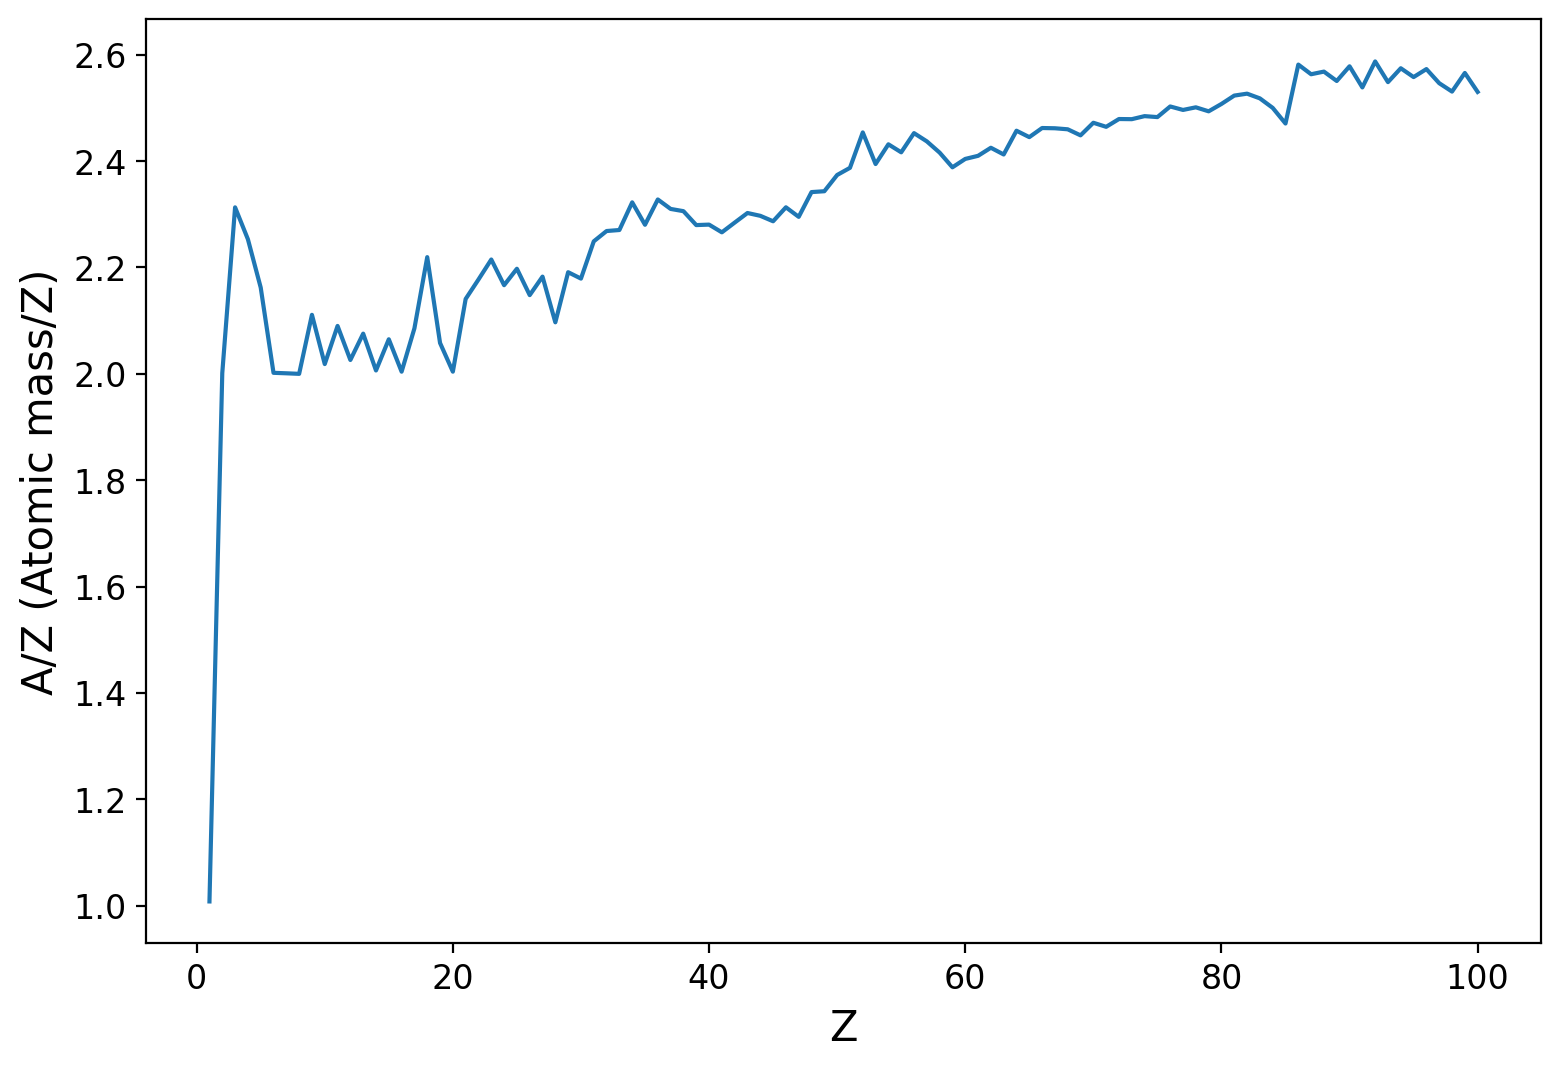

In [96]:
#values
def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV
def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.   
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]
lItmp=I(1,True)
lItmp=A(1,True)

Now we have all the elements to compute the Bethe-Bloch formula, and look at the charged particle energy loss over distance. For this part, we are going to focus on protons. However, this generally applies to a lot of different phenomena.  

Additionally, we will plot this for two atomic elements. Since we care about the human body, we will plot this for water (Oxygen) and just to show something heavy thats in a human (calcium). See this [page](https://en.wikipedia.org/wiki/Composition_of_the_human_body)

1.0056667694537882 0.10600907909112761


/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_27464/4122089377.py:31: RuntimeWarning: invalid value encountered in power
  f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))


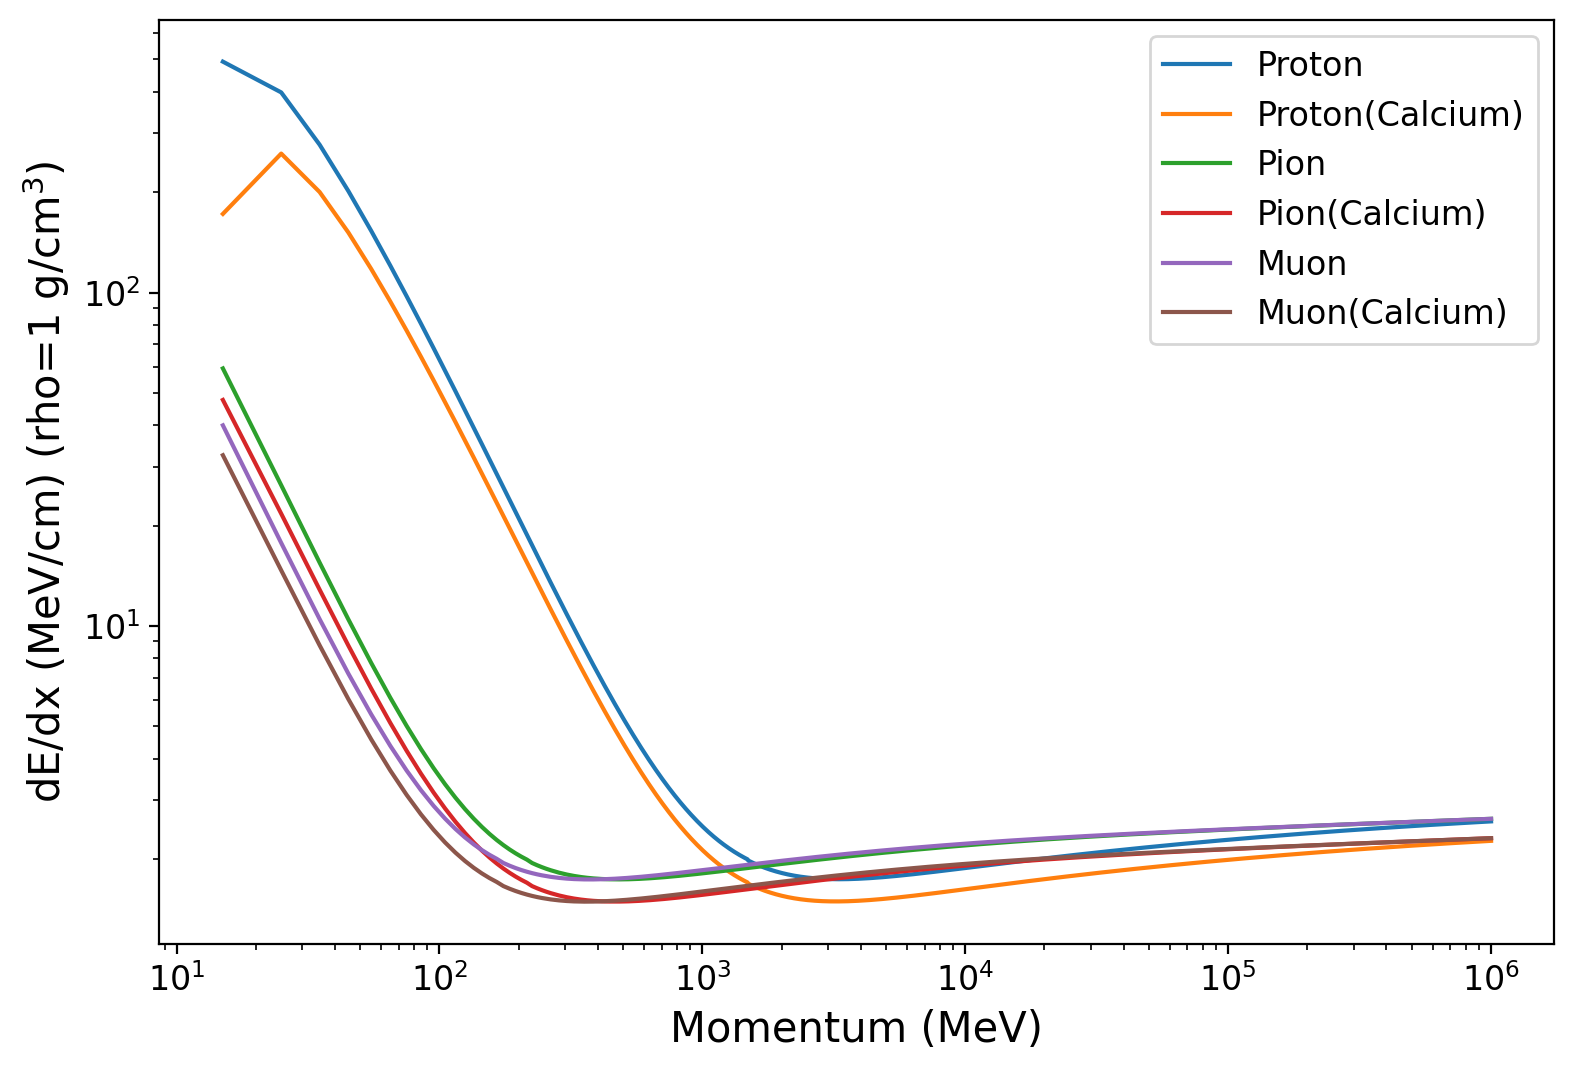

0.7059732966763472

In [99]:
#https://indico.cern.ch/event/753612/contributions/3121551/attachments/1974578/3285956/MC_2019.pdf
#https://www.nature.com/articles/s41598-017-10554-0

m_e = 0.511 # Mass of electron in MeV

def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def betagamma(ip,im):#p=bgm
    return ip/im

def Tmax(ip,im): # Maximum energy transfer in one collision in MeV
    return 2*m_e*(ip/im)**2/(1+2*gamma(ip,im)*m_e/im+(m_e/im)**2)

def TKinheavy(ip,im): #(T+M)^2=sqrt(p)+sqrt(m)
    return np.sqrt(np.sqrt(ip)+np.sqrt(um))-im

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0, 0, f2)
    delta_full = np.where(x < X1 ,delta_full, f3)
    return delta_full
        
def dEdxF(ip,im,iZ,zpart=1,rho=1.0,nodelta=False): #Bethe-Bloch equation
    K = 0.307075 # constant K in MeV cm mol^-1
    #rho = 2.336 # Density of material in g cm^-3 (here: silicon density)
    const   = zpart**2 * (K * rho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    logterm = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2) 
    dEdxV   =  const * (np.log(logterm)  - 2*(beta(ip,im))**2 - delta(ip,im))              
    if nodelta:
        print("delta:",delta(ip,im),dEdxV)
        dEdxV    =  const * (np.log(logterm) - 2*(beta(ip,im))**2)
    return dEdxV
    
mproton=938
mpion=135.4
mmuon=105.4
print(gamma(100,mproton),beta(100,mproton))
p=np.arange(15,1000000,10)
dEdxOut1p = dEdxF(p,mproton,8,1)
dEdxOut2p = dEdxF(p,mproton,18,1)
dEdxOut1pi = dEdxF(p,mpion,8,1)
dEdxOut2pi = dEdxF(p,mpion,18,1)
dEdxOut1mu = dEdxF(p,mmuon,8,1)
dEdxOut2mu = dEdxF(p,mmuon,18,1)

plt.plot(p,dEdxOut1p,label="Proton")
plt.plot(p,dEdxOut2p,label="Proton(Calcium)")

plt.plot(p,dEdxOut1pi,label="Pion")
plt.plot(p,dEdxOut2pi,label="Pion(Calcium)")

plt.plot(p,dEdxOut1mu,label="Muon")
plt.plot(p,dEdxOut2mu,label="Muon(Calcium)")

plt.xlabel('Momentum (MeV)')
plt.ylabel('dE/dx (MeV/cm) (rho=1 g/cm$^{3}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

beta(935,mproton)

Now, we can run a basic simulation of this already by considering a particle of a specific energy and then stepping it down by the energy loss. We could in fact do this analytically, but using the above formula makes it particulary nice and elegant. Let's go ahead and run our simulation for our proton energy beam. 

An important point to remember is that energy and momentum differ. In otherwords a 350 MeV proton will give a differnt momentum. Note that when we say a 350 MeV proton. We actually mean the kinetic energy is 350 MeV. This means our momentum is given by

$$
p^2 + m^2 = E_{\rm kin}^2 + m^2 \\
p^2 = (E_{kin} + m)^2 - m^2
$$

350 MeV Proton Momemtum: 882.6664149042944


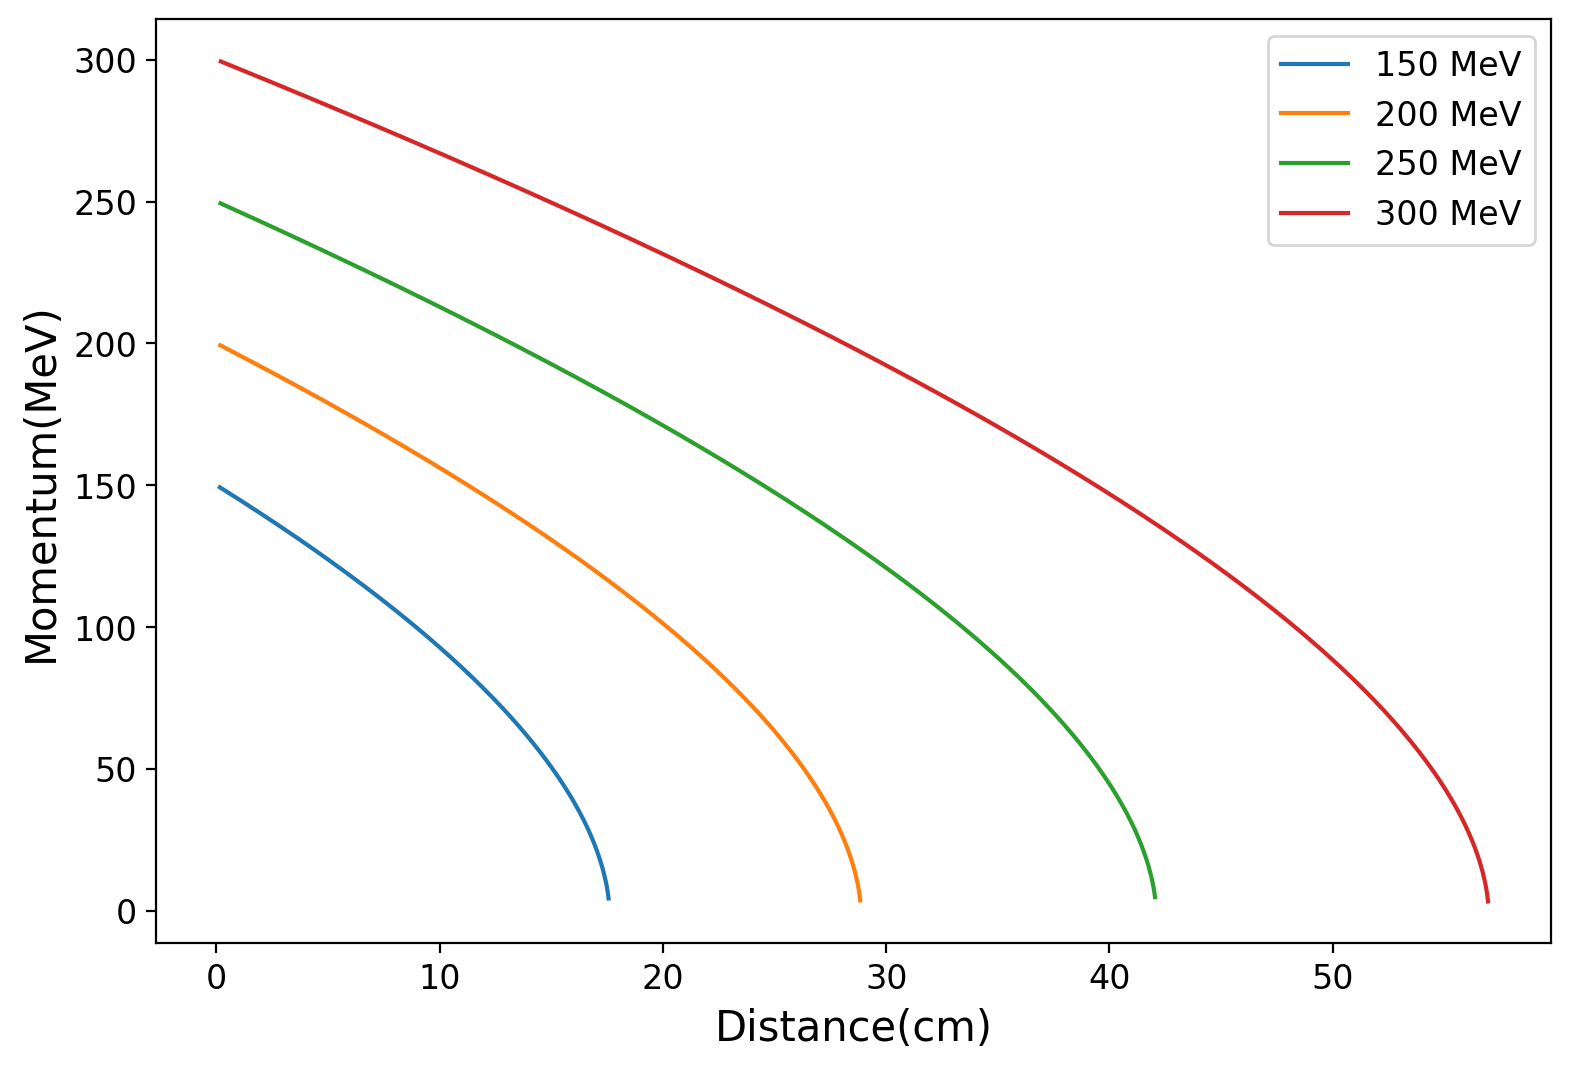

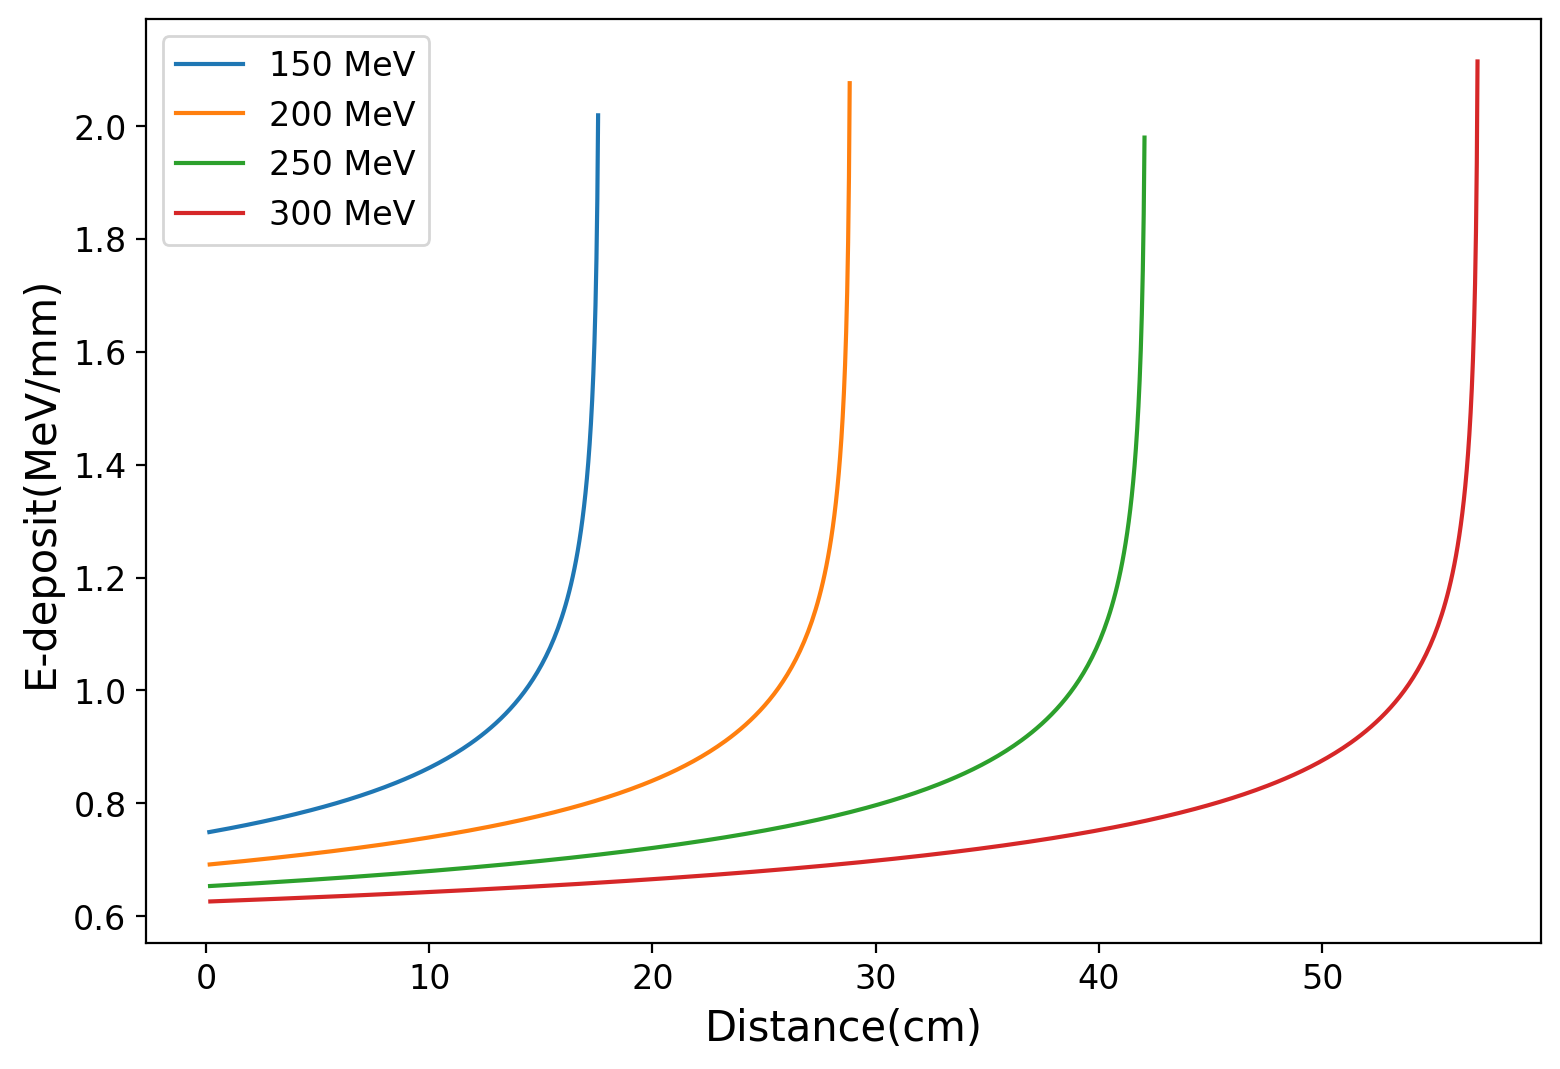

In [100]:
def dP(dE,ip,im): #solving 
    #dp = ip - np.sqrt(dE**2+ip**2-2*dE*np.sqrt(ip**2+im**2))
    #E=p^2/2m=> p=\sqrt(2mE)=>dp=sqrt(2m)/sqrt(E) dE
    #return dE*(np.sqrt(ip**2+im**2)/ip)*gamma(ip,im)
    return dE#*(ip/im)

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

def sim(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e > 5:
        p = eToP(e,im)
        dEdxS  = dEdxF(p,im,iZ=iZ,rho=1.06)
        #print(dEdxS)
        dx     = beta(p,im)*c*idt#speed of light
        #print(dEdxS,dP(dEdxS*dx,p,im))
        e      -= dEdxS*dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dEdxS*dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep
    
print("350 MeV Proton Momemtum:",eToP(350,mproton))
xstep150,pstep150,estep150 = sim(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = sim(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = sim(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = sim(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()

#sim(60,dt=1e-12)

Now what you can see above is that we get a very sharp energy deposit at a very specific region. As a result, we can use proton beams to deposit a huge amount of energy in the body for cancer thereapy. This peak is known as the Bragg peak. You can see that various energy beams get us various ranges in the body. Let's go one step further and make our simulation even more realistic.  

There are three ways to do this: 
1. Sample the full energy profile interaction as we move along the decay 
2. Smear the initial beam energy by the input resolution
3. Add other effects, namely multiple scattering. 

Let's go ahead and start with the first since this is often the most illustrative.

Energy loss is actually governed by a Landau distribution. What that means is that the energy depositied is not a fixed amount per step, but is distribution. The full distribution follows the Landau form given by 

$$
p(x) = \frac{1}{\pi}\int_{0}^{\infty} e^{-t \log(t)-xt} \sin(\pi t) dt
$$

To model energy loss exactly, what we need to do is sample a landau distribution at every step and apply the sampled value to our calculation of $\frac{dE}{dx}$. Let's go ahead and plot the Landau and come up with a scheme to sample it. 

We will take a resolution of 1.5 percent following [here](https://indico.cern.ch/event/654712/contributions/2666034/attachments/1531773/2397743/SJ_STFCDetectors_ProCal_25-09-17.pdf). Additionally, we will stop our proton beam once we have < 15 MeV. 

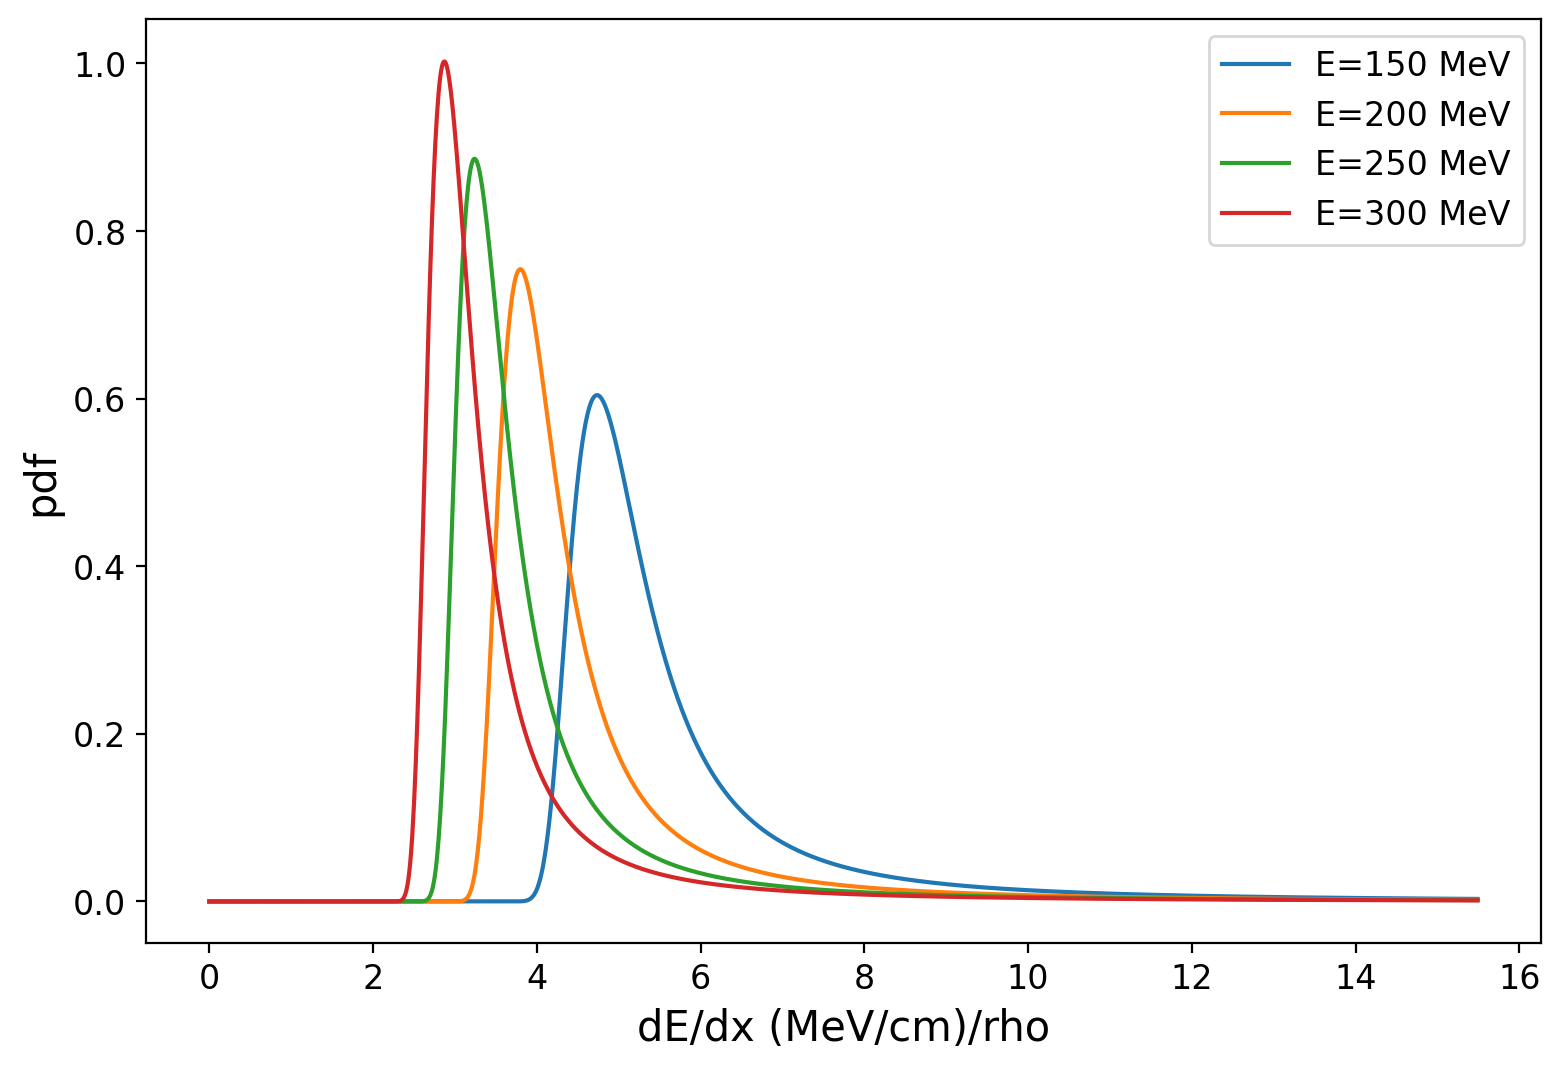

In [101]:
import pylandau
from landaupy import landau

def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2) 
    logterm1 = 2 * m_e *               ((ip/im)**2)/(I(iZ)) 
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2     - (beta(ip,im))**2 - delta(ip,im))       # 
    return dEdxV,const

def plotLandau(ip,im,idx,iZ=14,irho=1,zpart=1):
    lP=eToP(ip,im)
    lMPV,lWMPV = landauMPV(lP,im,iZ,irho,zpart)
    lMPV*=idx; lWMPV*=idx
    x=np.arange(0,15.5,0.01)
    landpy=landau.pdf(x,lMPV,lWMPV)
    return x,landpy

x,landZ150=plotLandau(150,mproton,1.0,iZ=8,irho=1.0)
x,landZ200=plotLandau(200,mproton,1.0,iZ=8,irho=1.0)
x,landZ250=plotLandau(250,mproton,1.0,iZ=8,irho=1.0)
x,landZ300=plotLandau(300,mproton,1.0,iZ=8,irho=1.0)

plt.plot(x,landZ150,label='E=150 MeV')
plt.plot(x,landZ200,label='E=200 MeV')
plt.plot(x,landZ250,label='E=250 MeV')
plt.plot(x,landZ300,label='E=300 MeV')
plt.xlabel("dE/dx (MeV/cm)/rho")
plt.ylabel("pdf")
plt.legend()
plt.show()


Now, what we can do to add some level of realisim as we move along our path of the proton going thorugh matter. Every time we step, we can sample the landau distribution pdf and step our energy loss. Given that we are sampling, it now makes sense to run this experiment a number of times. This now starts to give us some real Monte Carlo description.  

Sampling complicated distributions like this can often be slow. This code was implemented [here](https://github.com/SengerM/landaupy/blob/main/landaupy/samplers.py#L42). The strategy is to randomly sample a number from 0 to 1, this a p-value, then you can get the x-value by inverting the CDF since we know that 

$$
\rm{cdf}(x)=\int_{-\infty}^{x} p(x^{\prime}) dx^{\prime} 
$$

so we treat the cdf as a 1 to 1 map the y-axis is probabilty and teh x-axis is the pdf value integrated up to $x$. By inverting the cdf, treating this as a lookup table we can ivert the function so that ${\rm cdf}^{-1}(y)=x$.  

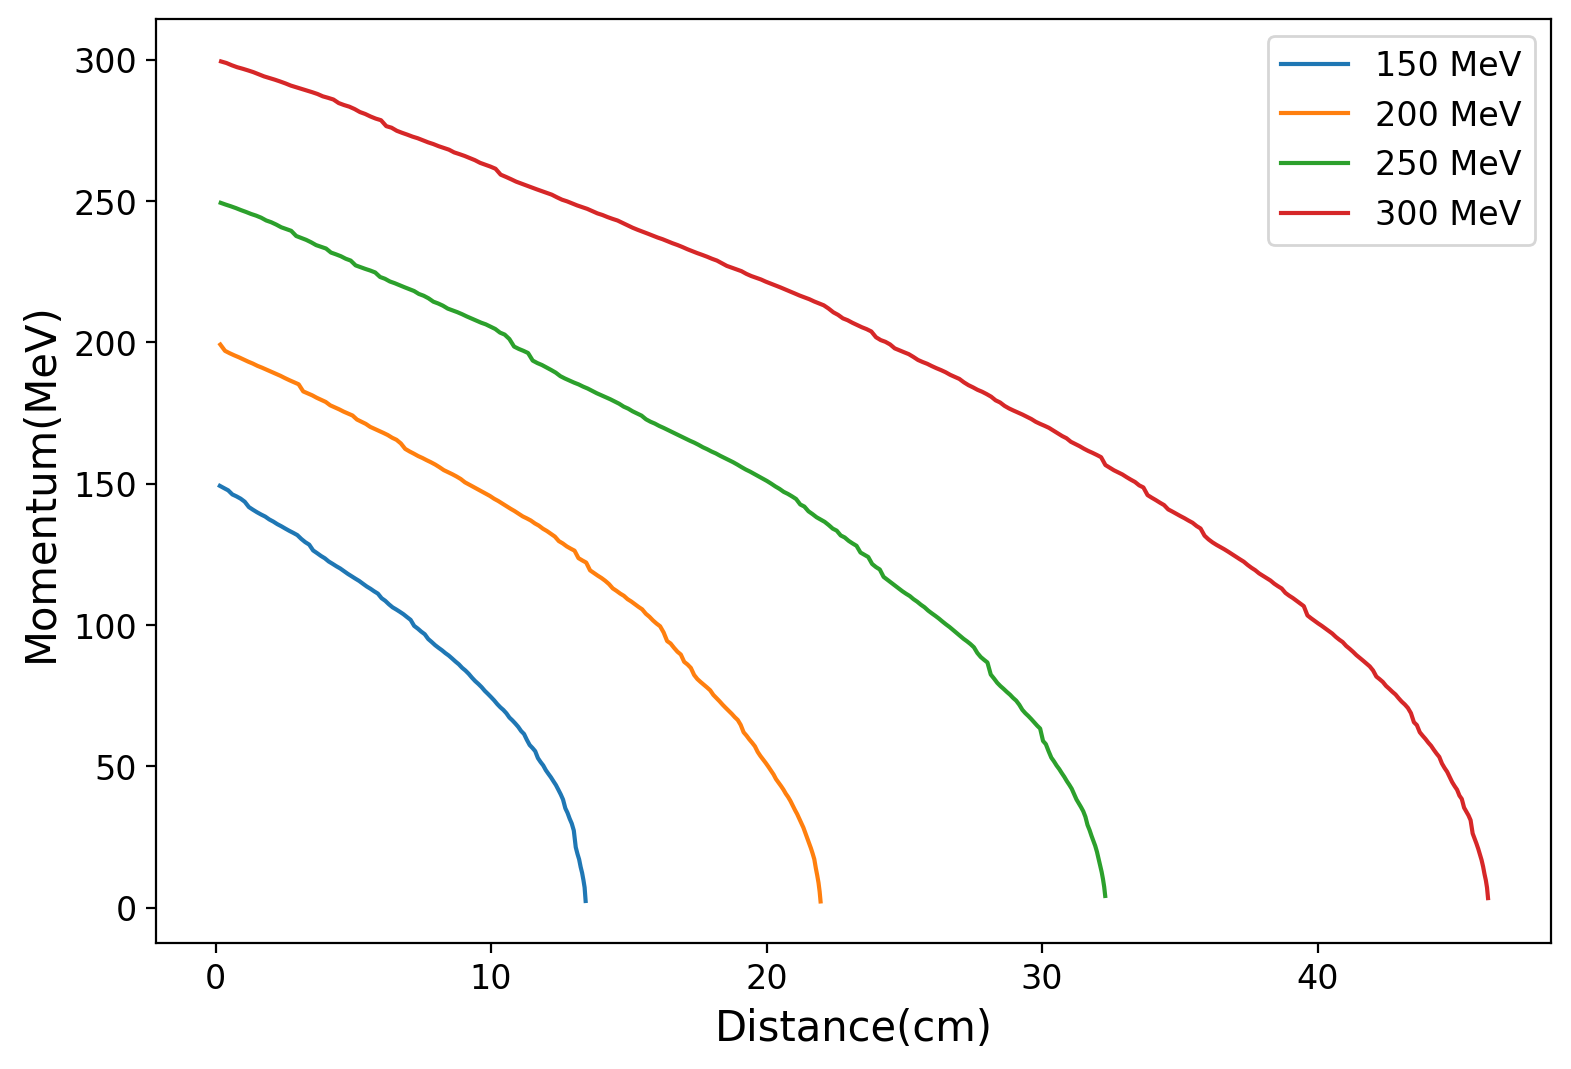

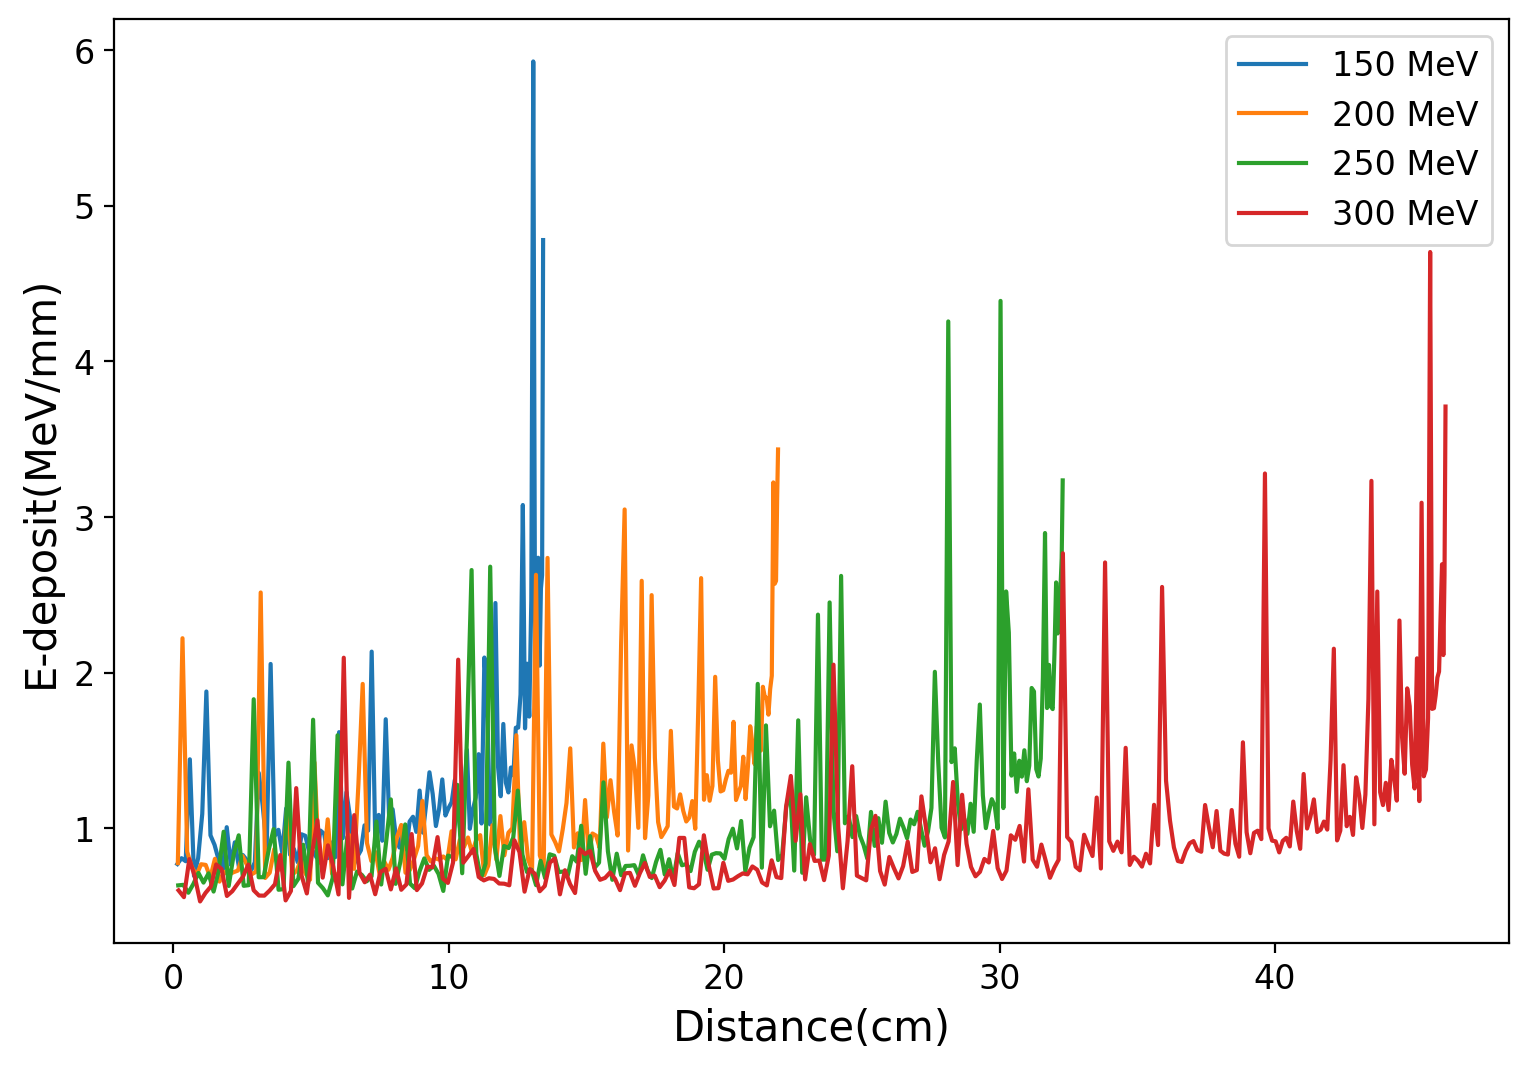

In [102]:
def simSample(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e > 5:
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE     = landau.sample(lMPV, lWMPV, 1)
        dx     = beta(p,im)*c*idt#speed of light
        e      -= dE*dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dE*dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep

xstep150,pstep150,estep150 = simSample(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = simSample(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = simSample(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = simSample(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()



Ok so now lets step through this guy and look at the distribution of energy deposited in our system. What we will do is our simulation above 100 times and see how much the energy deposit varies, and how much the length of propagation varies.

For this, we will define a few observables, lets look at the energy deposit in the last 3cm. Also, lets look at the energy deposit in the first 3 cm, for comparison. Also, we can look at the after distance the system went. 

0
25
50
75


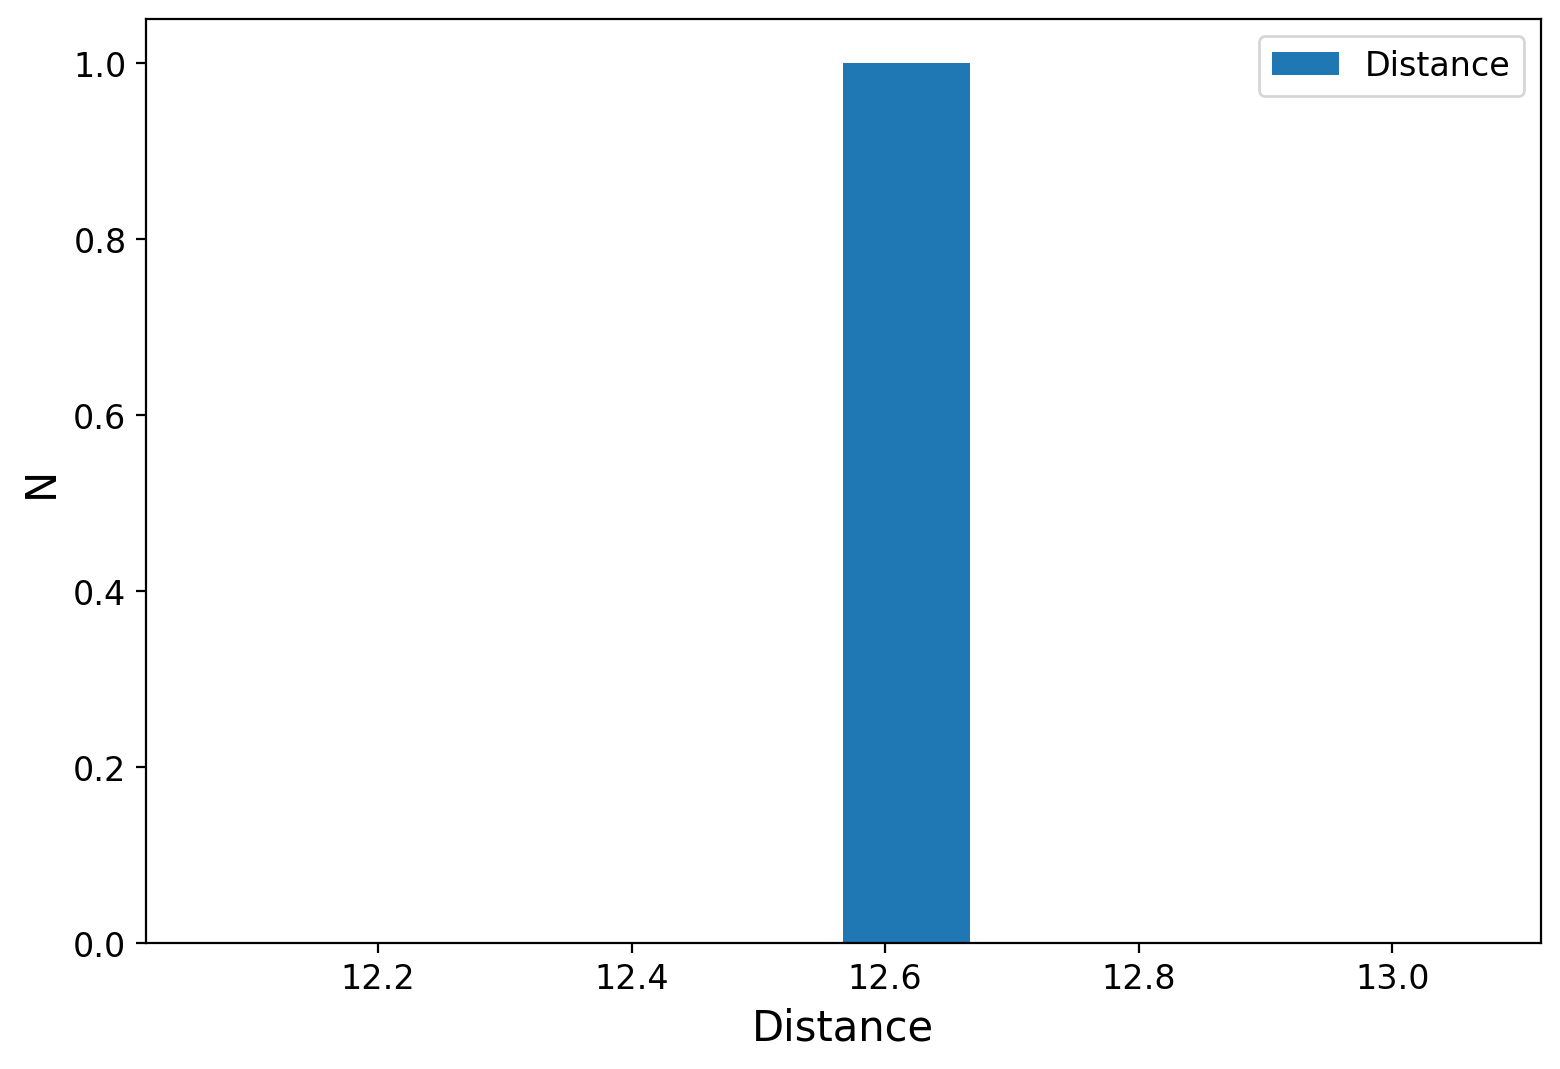

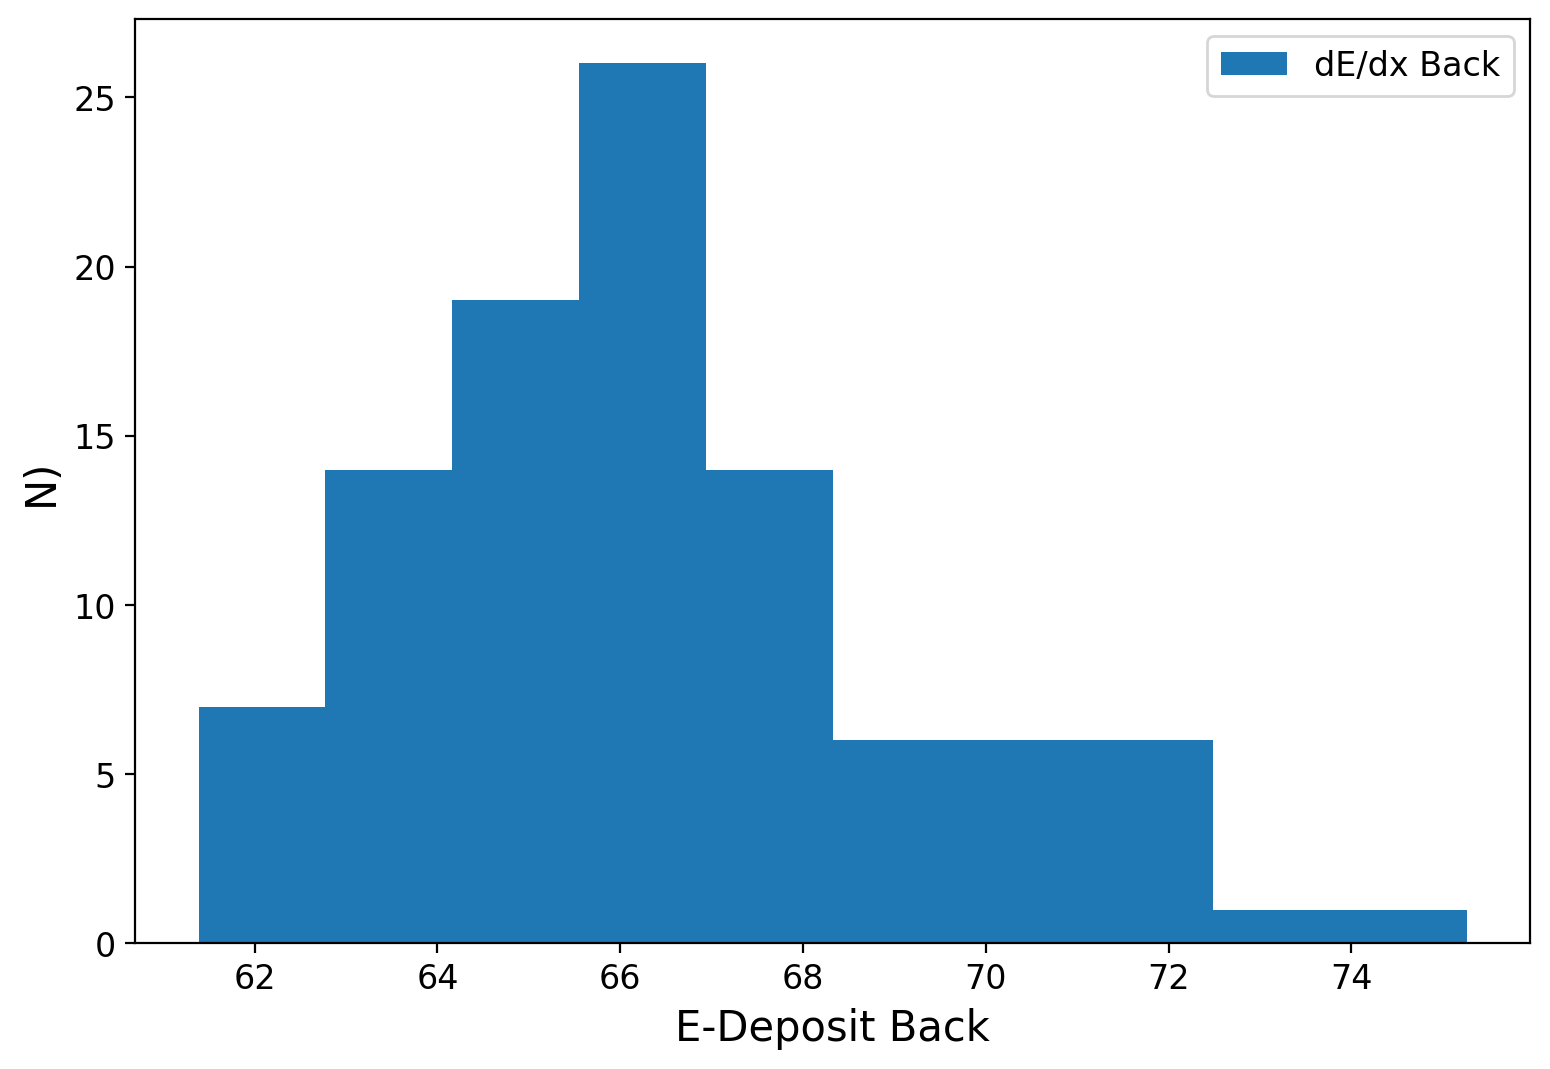

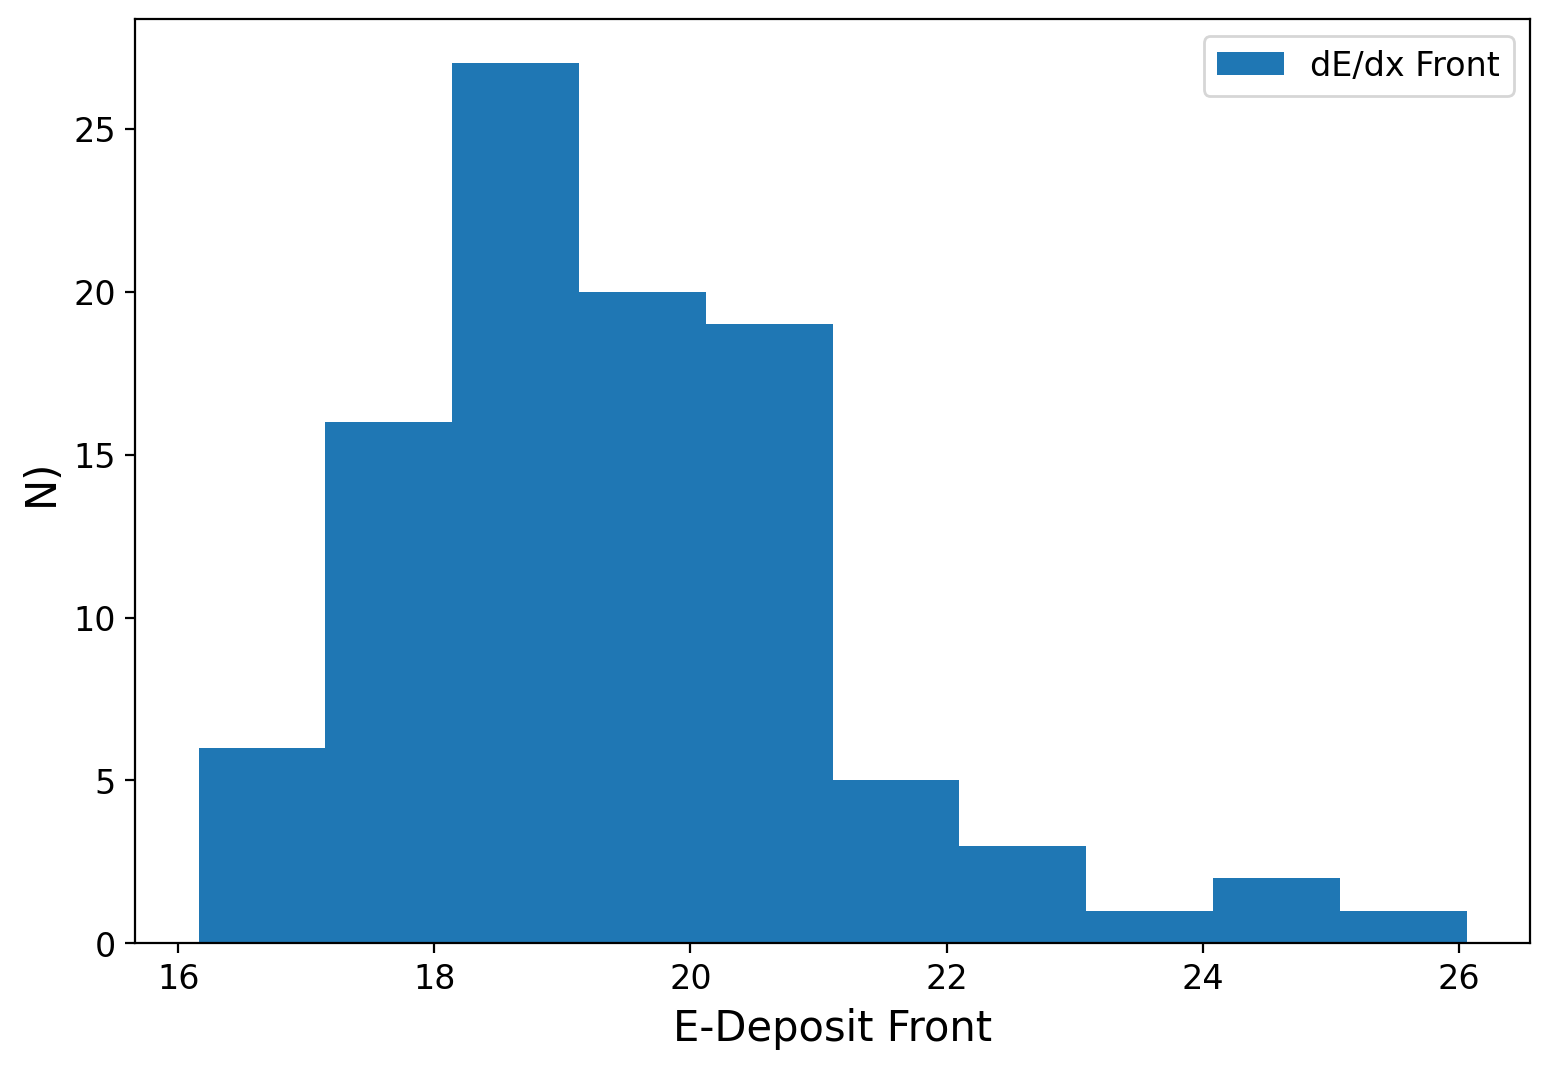

In [103]:
def observables(iXArr,iPArr,iEArr):
    lX=iXArr[-1]
    dEEnd=np.sum(iEArr[(iXArr > iXArr[-1]-3)])
    dEFrt=np.sum(iEArr[(iXArr < 3)])
    return lX,dEEnd,dEFrt  
    
def simNSamples(ie=150,im=mproton,iN=100,idt=1e-11,iZ=8):
    pXArr = np.array([])
    pdEBArr = np.array([])
    pdEFArr = np.array([])
    for i0 in range(iN):
        if i0 % 25 == 0:
            print(i0)
        pXstep,pPstep,pEstep = simSample(ie=ie,im=im,idt=idt,iZ=iZ)
        pX,pdEEnd,pdEFrt = observables(pXstep,pPstep,pEstep)
        pXArr   = np.append(pXArr,  pXstep)
        pdEBArr = np.append(pdEBArr,pdEEnd)
        pdEFArr = np.append(pdEFArr,pdEFrt)

    plt.hist(pX,label='Distance')
    plt.xlabel('Distance')
    plt.ylabel('N')
    plt.legend()
    plt.show()

    plt.hist(pdEBArr,label='dE/dx Back')
    plt.xlabel('E-Deposit Back')
    plt.ylabel('N)')
    plt.legend()
    plt.show()

    plt.hist(pdEFArr,label='dE/dx Front')
    plt.xlabel('E-Deposit Front')
    plt.ylabel('N)')
    plt.legend()
    plt.show()

#plt.plot(xstep150,estep150,label='150 MeV')
#plt.plot(xstep200,estep200,label='200 MeV')
#plt.plot(xstep250,estep250,label='250 MeV')
#plt.plot(xstep300,estep300,label='300 MeV')
#plt.xlabel('Distance(cm)')
#plt.ylabel('E-deposit(MeV/mm)')
#plt.legend()
#plt.show()

simNSamples()


Now that was kind of slow can we speed up this process? 

The way we will do this is we will step through 500 simulations all the same time in parallel. The one thing that is tricky is that parallel support for sampling the Landau is not supported, so we will have to add a for loop to do that bit. Anyway, otherwise, we can run everything else in parallel. 

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


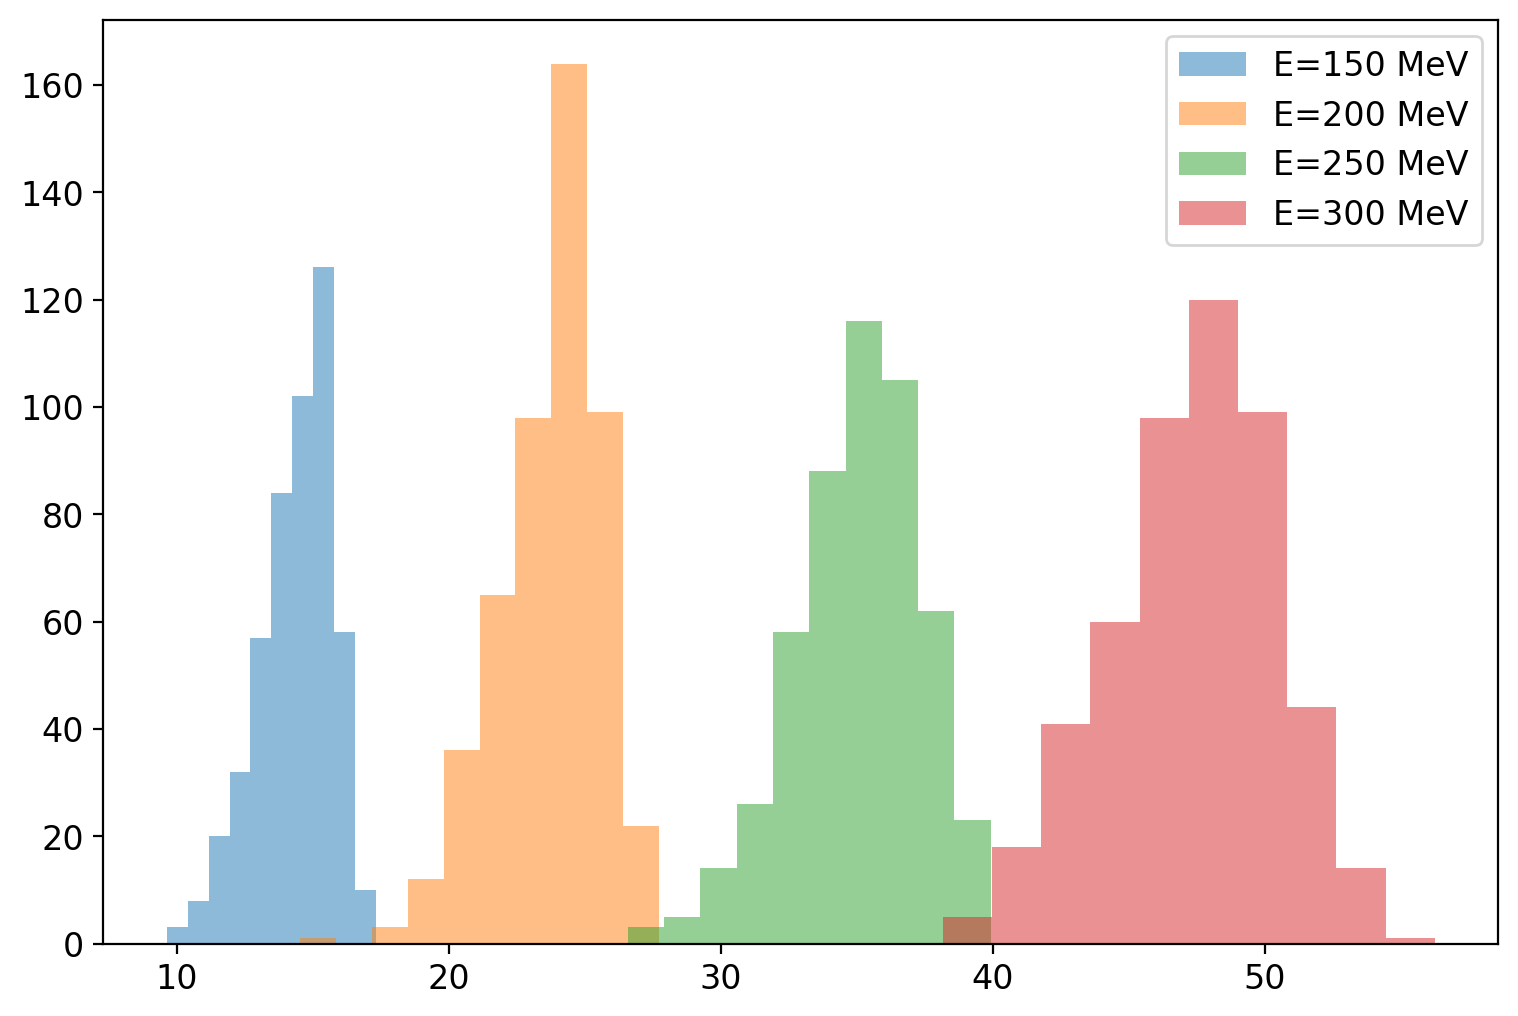

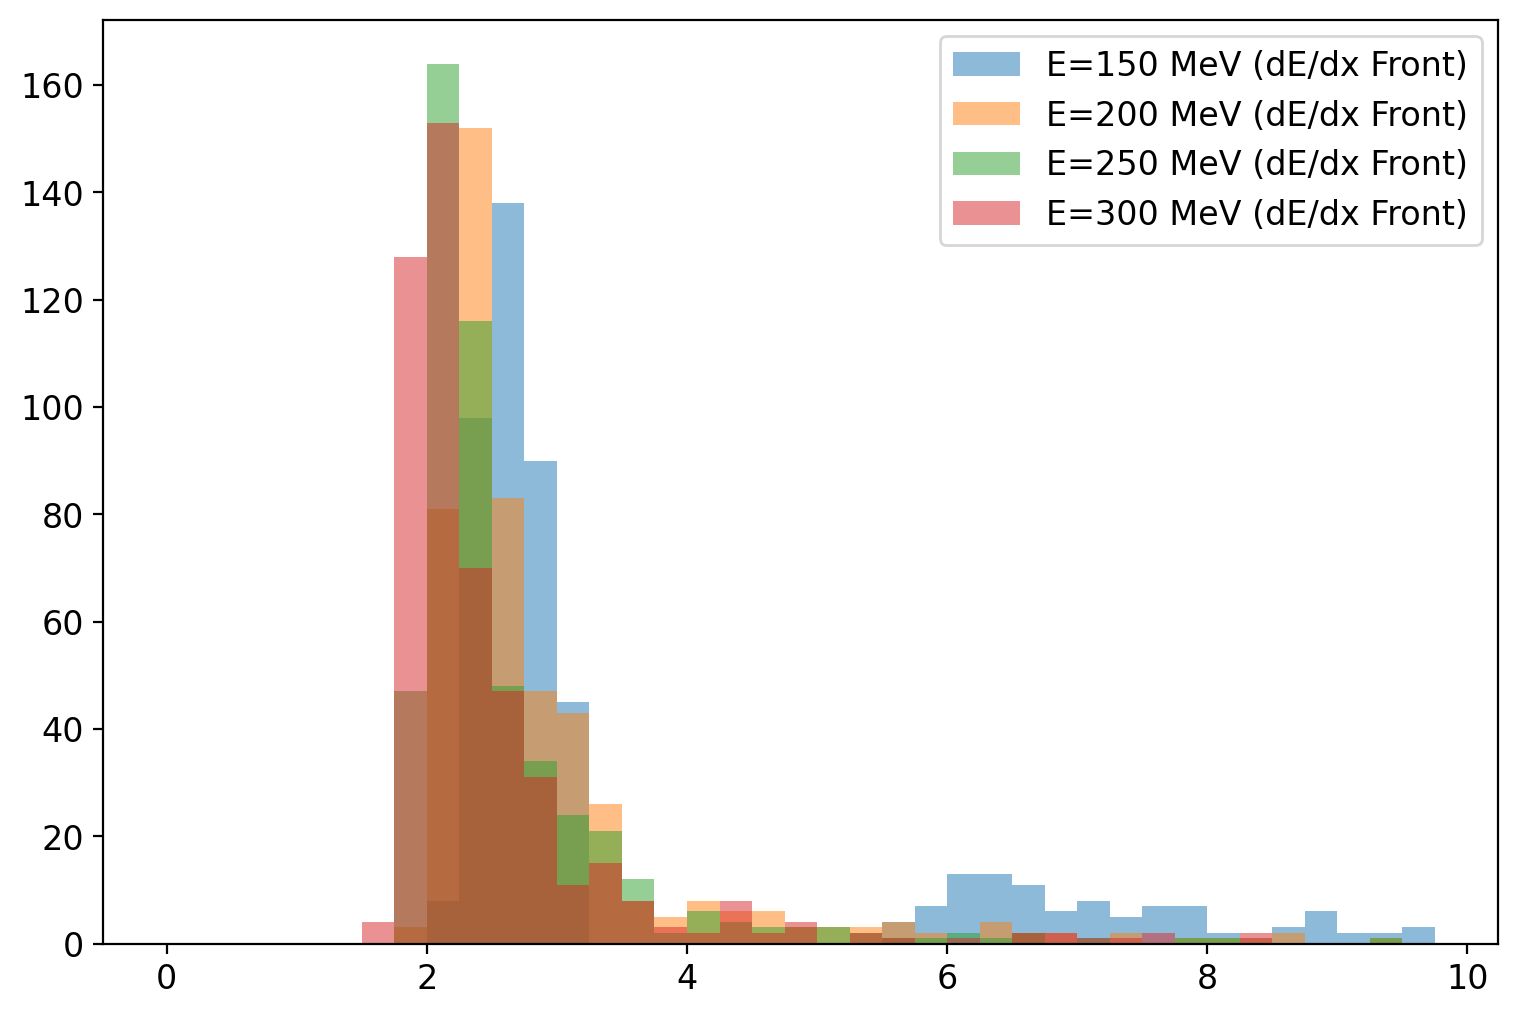

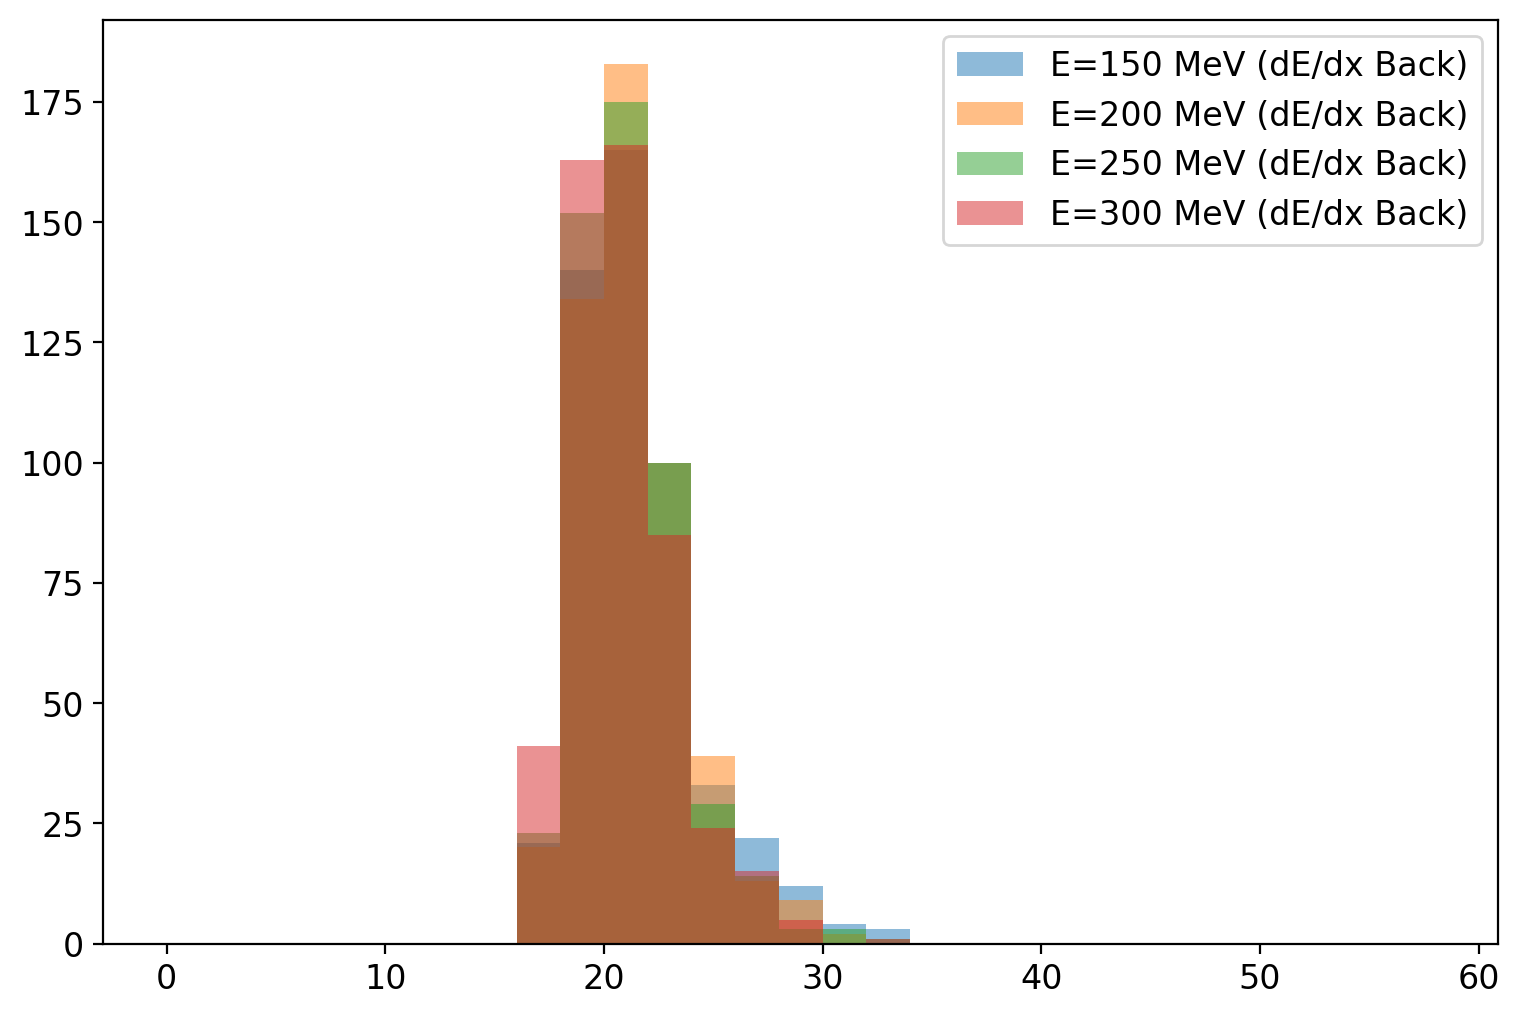

In [108]:
def simNParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx
        xstep  = np.vstack((xstep,dist))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    return xstep,pstep,estep

def simNSamples(ie=100,im=mproton,iN=500,idt=5e-11,iZ=8):
    xstep,pstep,estep=simNParallelSample(iN,ie=ie,im=im,idt=idt,iZ=iZ)
    plt.hist(xstep[:,-1],alpha=0.5)
    plt.show()
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0]-3])/3.
    xrange=np.arange(0,150,2.5)
    _,bins,_=plt.hist(efront,bins=xrange,alpha=0.5,label='dE/dx Front')
    plt.hist(eback, bins=bins,alpha=0.5,label='dE/dx Back')
    plt.legend()
    plt.show()
    
def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

xstep150,pstep150,estep150=simNParallelSample(ie=150,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep200,pstep200,estep200=simNParallelSample(ie=200,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep250,pstep250,estep250=simNParallelSample(ie=250,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep300,pstep300,estep300=simNParallelSample(ie=300,im=mproton,iN=500,idt=1e-10,iZ=8)

plt.hist(xstep150[:,-1],alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,10,0.25)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.legend()
plt.show()


From these distributions, we can start to make interesting conclusions. The higher energy beams tend to go longer, deposit less in the front, but the same as everybody else in the back. Notice also the 150 MeV feature. This Monte Carlo, we have developed is pretty sophisticated, but we can do even better if we take in mind that our beam is a full 3D distribution.  


<a name='section_18_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.5 Modelling Physics Observables : Bragg Scattering for Proton Therapy in multiple dimensions </h2>  




Additionally, as the proton beam moves through the body. In addition to losing energy, it will scatter in different directions. The scatter occurs from the fact that the proton is charged, and the nuclei are charged and so we have coulomb scattering (aka Rutherford scattering) of the proton against the nuclei. This is an elastic process that will inevitably spread the beam further out. The scattering angle is often written as: 

$$
\sigma_{\theta} = \frac{13.6 \rm MeV}{\beta cp} z \sqrt{\frac{x}{X_{0}}}\left(1+0.038\log\left(\frac{xz^{2}}{X_{0}\beta^{2}}\right)\right)
$$

The actual scatter has been studied to give a parameteriztion split in two terms

$$
\sigma_{\Delta y} = z_{1} \Delta x \frac{\sigma_{\theta}}{\sqrt{12}} + \frac{z_{2} \Delta x\sigma_{\theta}}{2}\\
\sigma_{\Delta \theta}     = z_{2} \sigma_{\theta}
$$
Where we have $z_{1}$ and $z_{2}$ are two normal random sampled distributions that are idependent of one another.

6.36964816414323


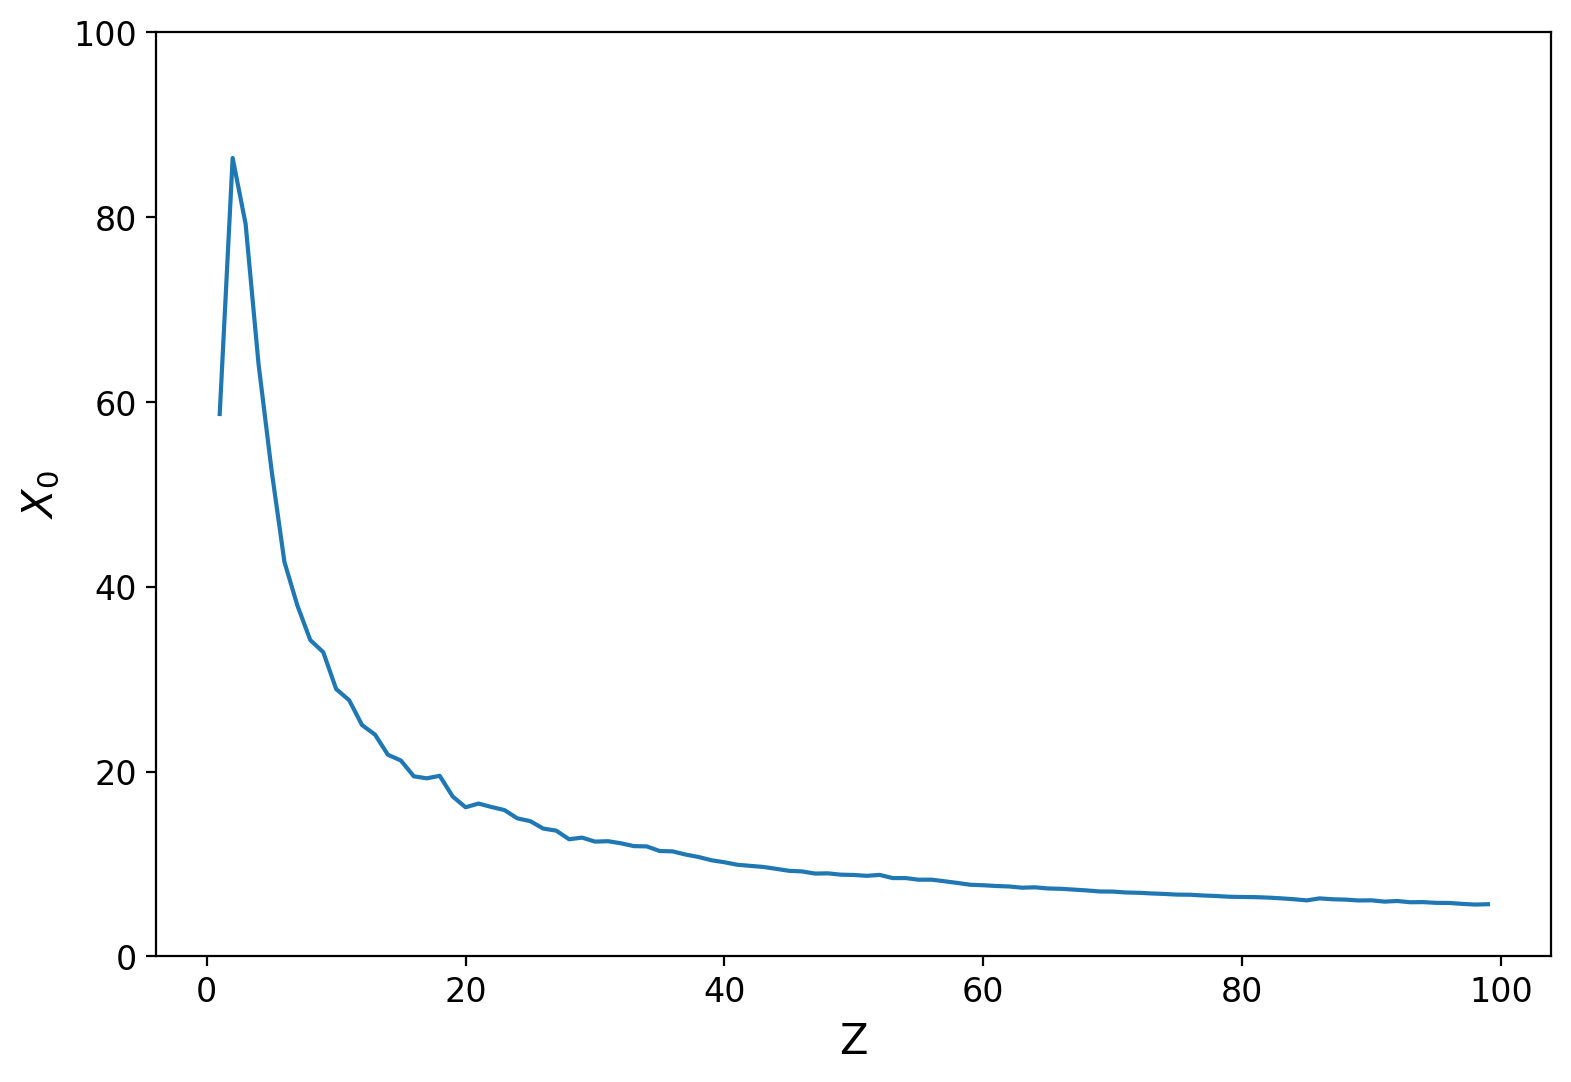

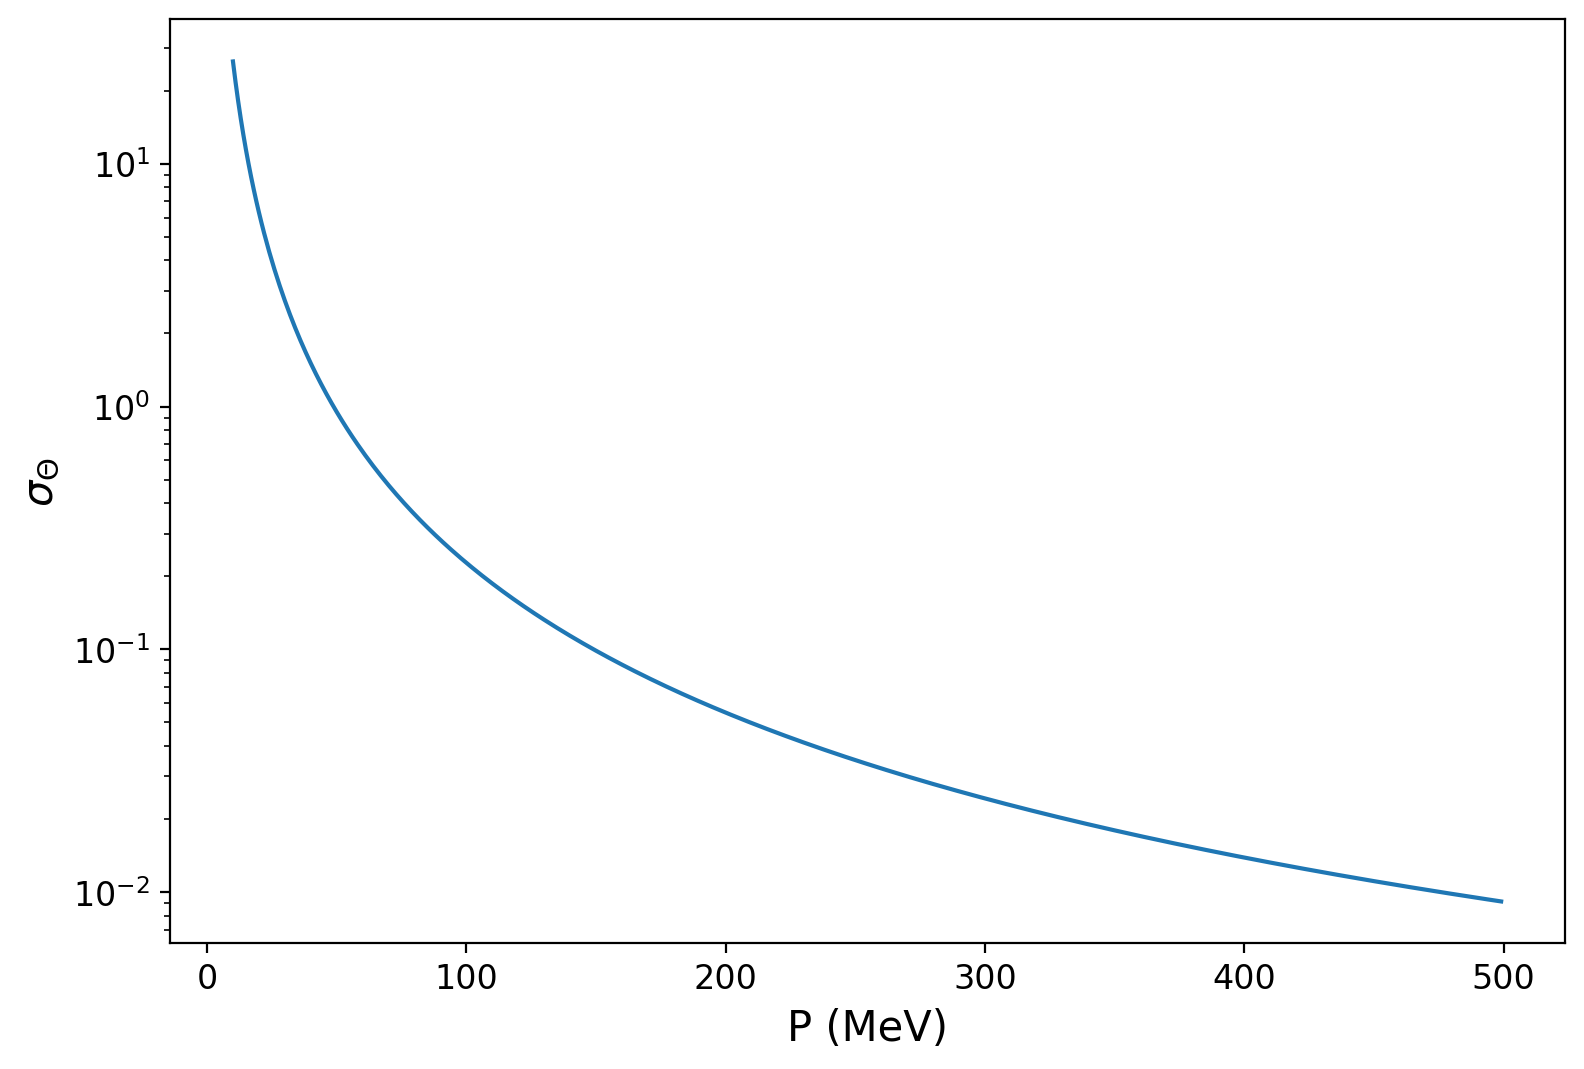

In [106]:
def X0(iZ):
    const=(716.408**-1)/A(iZ)
    a = iZ/137.
    Lrad =np.log(184.15*iZ**(-1./3.))
    Lradp=np.log(1194*iZ**(-2./3.))
    fZ = a**2*((1+a**2)**(-1)+0.20206-0.0369*a**2+0.0083*a**4-0.002*a**6)
    val=const*(iZ**2*(Lrad-fZ)+iZ*Lradp)
    return 1./val
    
def sigmaTheta(ip,im,iX0,idx=1.0,zpart=1):
    C=13.6
    X0=iX0
    dx=idx/iX0
    const=C/(beta(ip,im)*ip)*zpart*np.sqrt(dx)
    logterm=1+0.038*np.log(dx*zpart**2/beta(ip,im)**2)
    return const*logterm

def thetaScatter(ip,im,iX0,idx,zpart=1):
    z1=np.random.normal(0,1,ip.shape[0])
    z2=np.random.normal(0,1,ip.shape[0])
    stheta=sigmaTheta(ip,im,iX0,zpart)
    dy    =z1*idx*stheta/np.sqrt(12.) + z2*idx*stheta/2 
    dtheta=z2*stheta
    return dtheta,dy

lZ=np.arange(1,100,1)
lX0=np.zeros(len(lZ))
for pZ in lZ:
    lX0[pZ-1] = X0(pZ)
print(X0(82))
plt.plot(lZ,lX0)
plt.xlabel("Z")
plt.ylabel("$X_{0}$")
plt.ylim(0,100)
plt.show()

lP=np.arange(10,500,1)
lST = sigmaTheta(lP,mproton,X0(8))
plt.plot(lP,lST)
plt.yscale('log')
plt.xlabel('P (MeV)')
plt.ylabel('$\sigma_{\Theta}$')
plt.show()

What we see above is that for very low energy we have very large angles when we get to the low momenta. Basically, the proton can go anywhere, this can blur out our beam, and if we are using this for cancer therapy can cause more damage. 

One important thing to consider is that we need to make sure our angular scatter is physical, that means we should make sure that our angles are ok. 

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


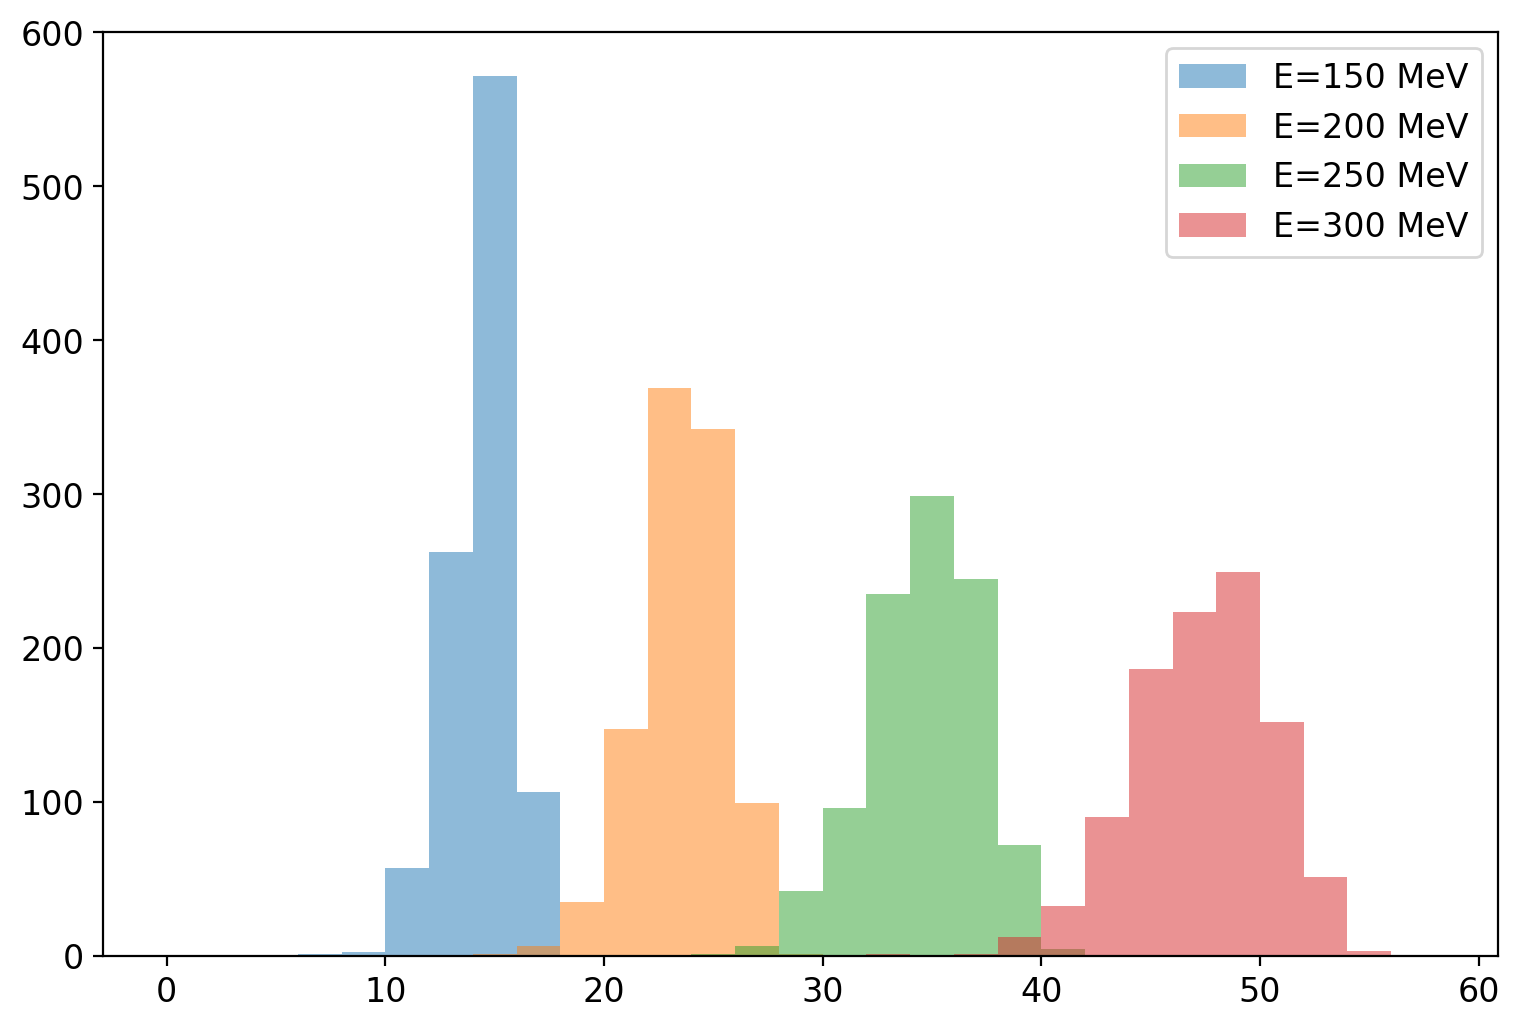

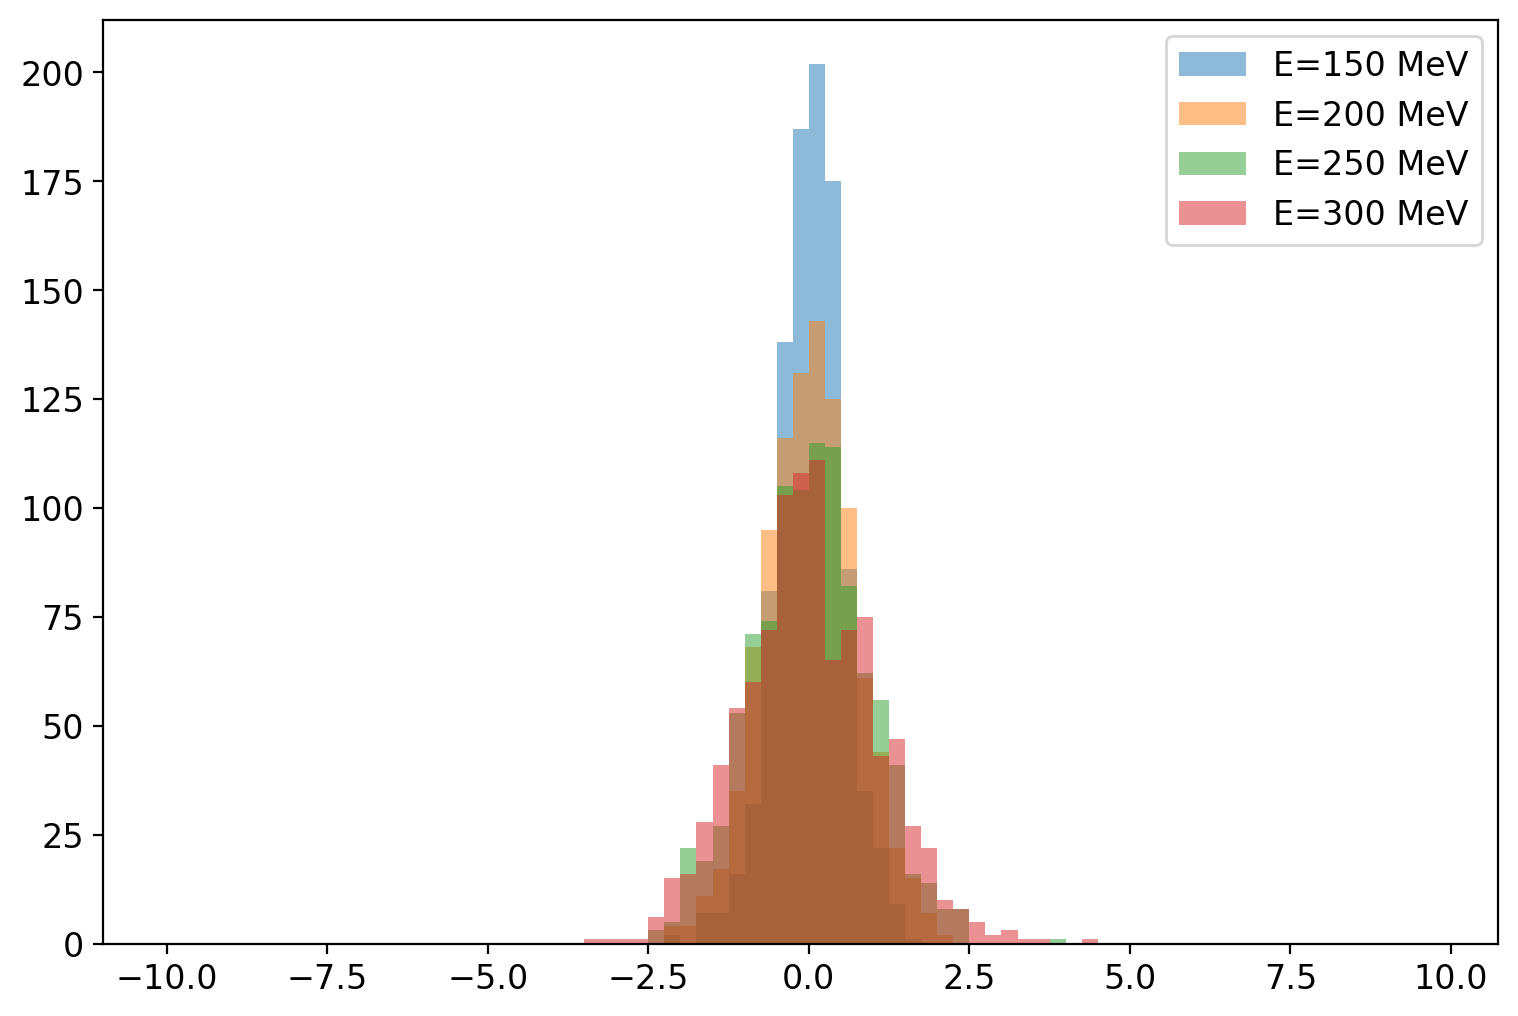

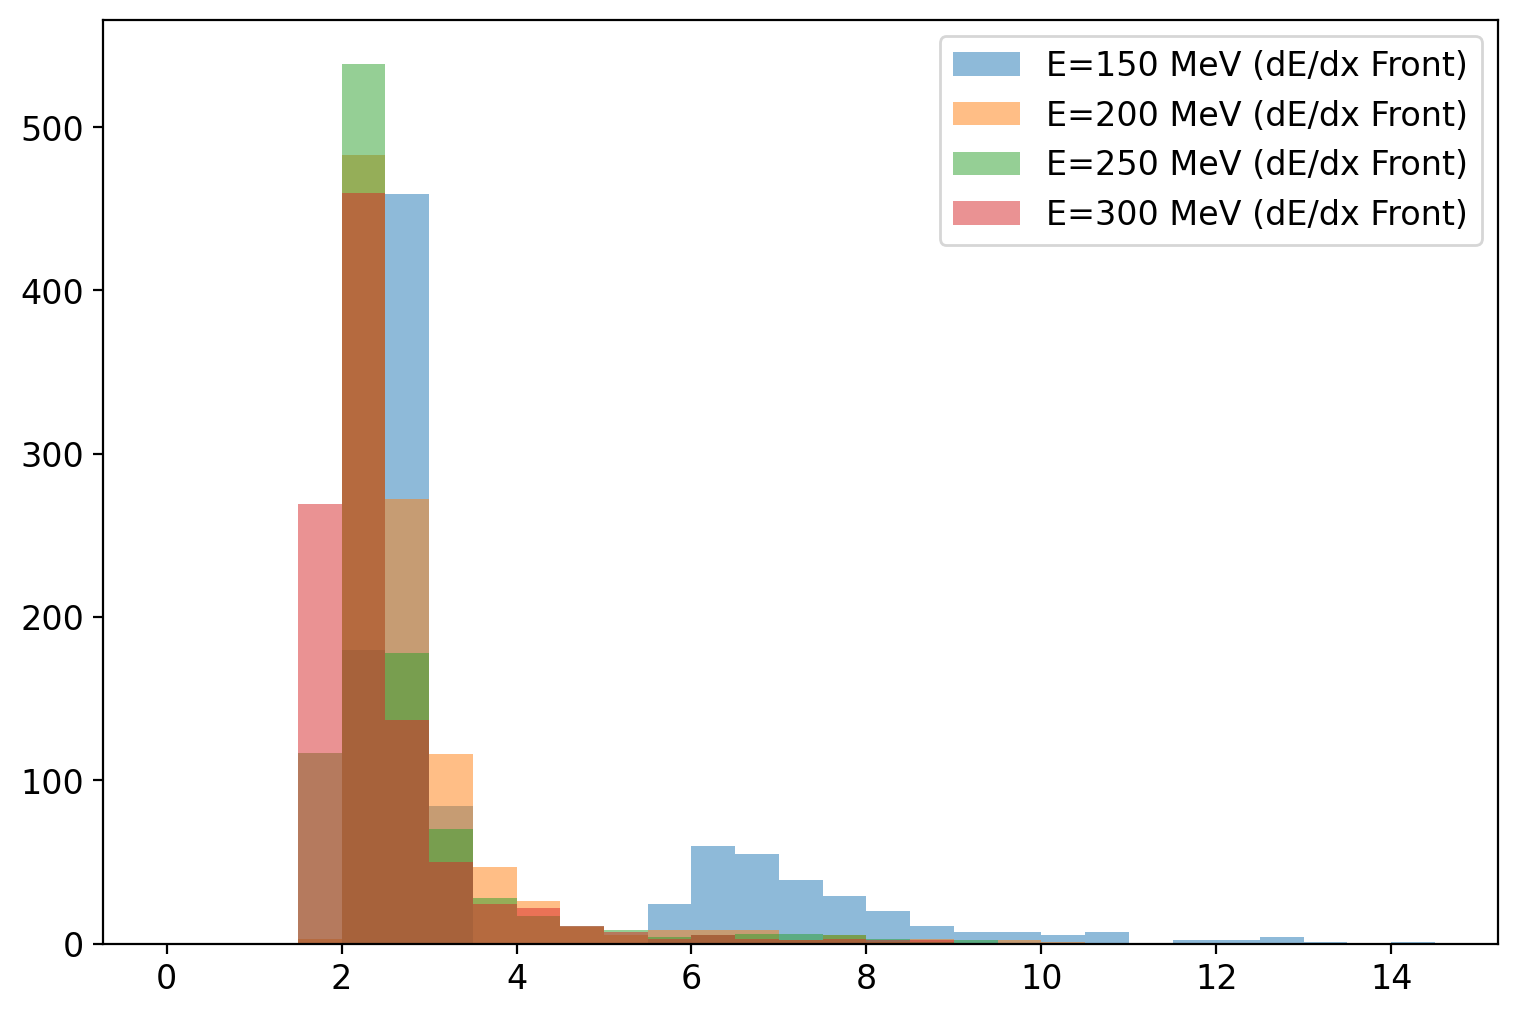

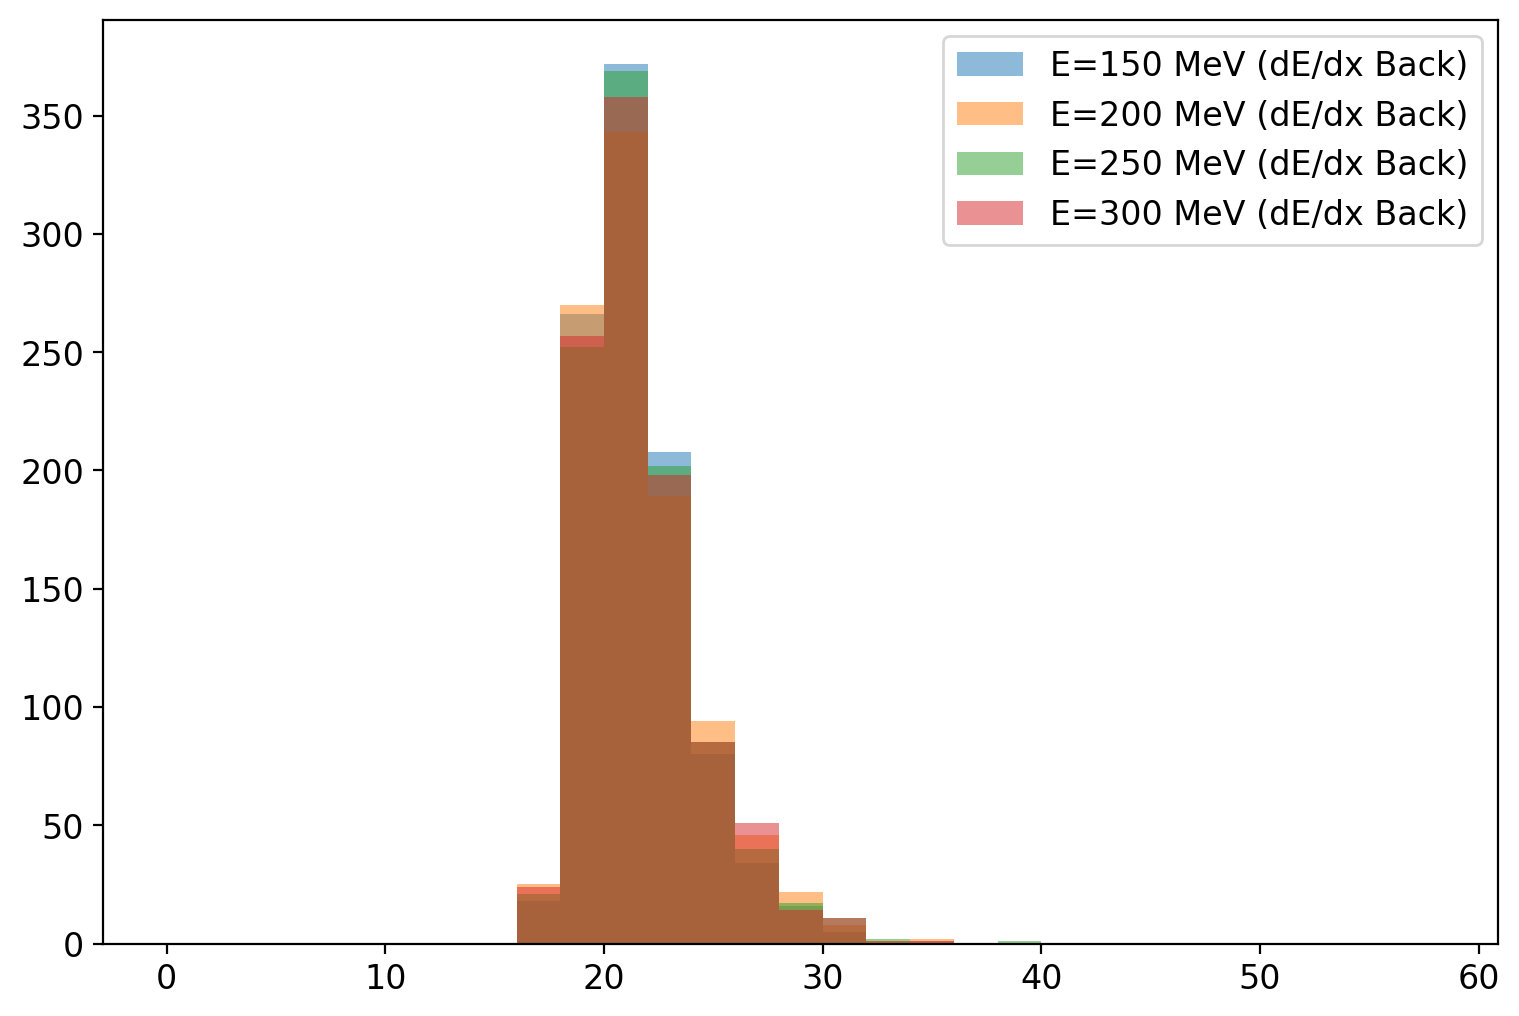

In [112]:
def simNYParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    ystep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    theta=0
    y=0
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    lX0 = X0(iZ)
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        dTheta,dy = thetaScatter(p,im,lX0,idx=dx,zpart=1)
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx*np.cos(theta)
        y      += dy + np.sin(theta)*dx
        theta  += dTheta
        xstep  = np.vstack((xstep,dist))
        ystep  = np.vstack((ystep,y))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))        
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    ystep = ystep.T
    return xstep,pstep,estep,ystep

xstep150,pstep150,estep150,ystep150=simNYParallelSample(ie=150,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep200,pstep200,estep200,ystep200=simNYParallelSample(ie=200,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep250,pstep250,estep250,ystep250=simNYParallelSample(ie=250,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep300,pstep300,estep300,ystep300=simNYParallelSample(ie=300,im=mproton,iN=1000,idt=1e-10,iZ=8)

xrange=np.arange(0,60,2)
plt.hist(xstep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

xrange=np.arange(-10,10,0.25)
plt.hist(ystep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(ystep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(ystep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(ystep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,15,0.5)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.legend()
plt.show()


## Constructing a likelihood

Now this is where things become really interesting. The simulation we made above models a very specific process, and the more and more elements of realism. However, this gets more complicated. That being said, we see in the end the distributions we model are fairly reasonable. 

What we can do is build a paramettric model for the behavior of what is going, this is often how we try to characterize things. 


In [111]:
def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now lets make a regular image 
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    print("A:",len(ixstep.flatten()),len(iystep.flatten()),len(iestep.flatten()))
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())  
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])  
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)  
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)

A: 7500 15000 7500


ValueError: x and y must have the same length.


<a name='section_18_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.6 Interlude : Variational Autoencoders for Monte Carlo based Event Generation </h2>  





Before we go down the path of using variational autencoders for simulation. Let's take a little bit of time to run one of the famous illustrative examples of variational autoencoders. I have to say, this got me hooked on their usefulness, and made me understand the advantage of using them. 

For this we are going to use the MNIST character dataset. The MNIST character dataset was one of the first ML datasets. This dataset has become the basis for testing and validating deep learning algorithms. It is so deeply embedded into pytorch that we can just load it from pytorch.

In [44]:
#!pip install torchvision

import pandas as pd 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])

test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Now, we need to define the neural network architecture. While this is not the focus of this lecture, lets take a few minutes to look at how we encode this. 

For this architecture we are going to take the MNIST input dataset, and encoder it into a large vector. The past 10 years of research on deep learning has shown that Convolutional Neural Networks (CNNs) are one of the most robust wasy to encode images. Our enconder will thus be 3 convolutional NN layers stringed together. Each one produces a smaller image from the previous image. Finally, once the image is small enough (3x3, but with 32 features), we take the image and linearize it to a single vector, which we then feed into normal Dense(Linear) layers. 

Finally because this is a variational autencoder, we need to output a mean and a sigma for each dimension in the latent space, once we have the mean dthe sigma, we can randomly sample a normal distribution with these features. 

In [51]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        #Now we need sample in phase space 
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear 
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z      

Now that we have encoded everything in a space, we can go ahead and decode it so that we can build a network that tries to generate the original image from the lower dimensional intermediate space. This decoder is the opposite of the encoer and starts from the vector in teh latent space and then expands out the image using the invers of CNNs, ConvTranspose2ds, this generates an image from a vector. Below, is our decder, which finally yields an image at the end. 

In [52]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Finally, we can go ahead and combine everything together to make our variational autoencoder. One last element that we need to understand for the variational autoencoder is how we can train this NN. The way we do this is we train for the inputs to be equal to the outputs. In otherwords, we try to minimize our loss given inputs $x_{i}$ and outputs $y_{i}$ each of size $N$, we can write

$$
\mathcal{L} = \sum^{N}_{i} (x_{i}-y_{i})^{2}
$$

Now from studies of the variational autoencoder with the above loss, we have come to add another nerm. This term, we refer to as the Kullback-Liebler(KL) divergence term for the latent space to approximate a Gaussian. 

What does this mean? 

KL divergence is a measure of how similar to probability distributions are from each other. It is defined as

$$
\mathcal{D}_{\rm KL}\left(P||Q\right)  = \int_{-\infty}^{\infty} p(x) \log\left(\frac{p(x)}{q(x)}\right) dx
$$

For two probability distributions $p(x)$ and $q(x)$. It is effectively the difference in log probabilities of two distrbiutions or some notion of the entropy. In the case of the VAE, we apply a KL diverence for the probability distribution of the latent space to approximate a Gaussian dsitriboution with width 1. This we can write as 

$$
\log\left(\mathcal{N}(\mu,\sigma)\right) = -\frac{1}{2}\log\left(2\pi\sigma^{2}\right)-\left(\frac{x-\mu}{2\sigma}\right)^{2} \\
\log\left(\mathcal{N}(\mu,\sigma)\right) - \log\left(\mathcal{N}(\mu=0,\sigma=1)\right) = 
-\frac{1}{2}\log\left(2\pi\sigma^{2}\right)-\left(\frac{x-\mu}{2\sigma}\right)^{2}+\frac{1}{2}\log\left(2\pi\right)+\frac{x^2}{2}\\
\int_{-\infty}^{\infty} p(x) \log\left(\frac{p(x)}{q(x)}\right) dx = 
-\frac{1}{2}\log\left(\sigma^{2}\right) - \frac{1}{4}  + \frac{\sigma^2}{2} + \frac{\mu^2}{2}
\\
\mathcal{D}_{\rm KL}\left(\mathcal{N}(\mu,\sigma)||\mathcal{N}(\mu=0,\sigma=1)\right) = 
-\frac{1}{2}\log\left(\sigma^{2}\right) - \frac{1}{4}  + \frac{\sigma^2}{2} + \frac{\mu^2}{2}
$$

In [53]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.kl      = 0
        
    def forward(self, x):
        z = self.encoder(x)
        kl = self.encoder.kl
        return self.decoder(z)

Now let's train this and embed it into 2 latent dimensions! With that we can see what is going on. 

In [54]:
### Set the random seed for reproducible results
torch.manual_seed(0)
d = 2
vae = VariationalAutoencoder(latent_dims=d)
lr = 1e-3 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


 EPOCH 1/10 	 train loss 154.819 	 val loss 82.903


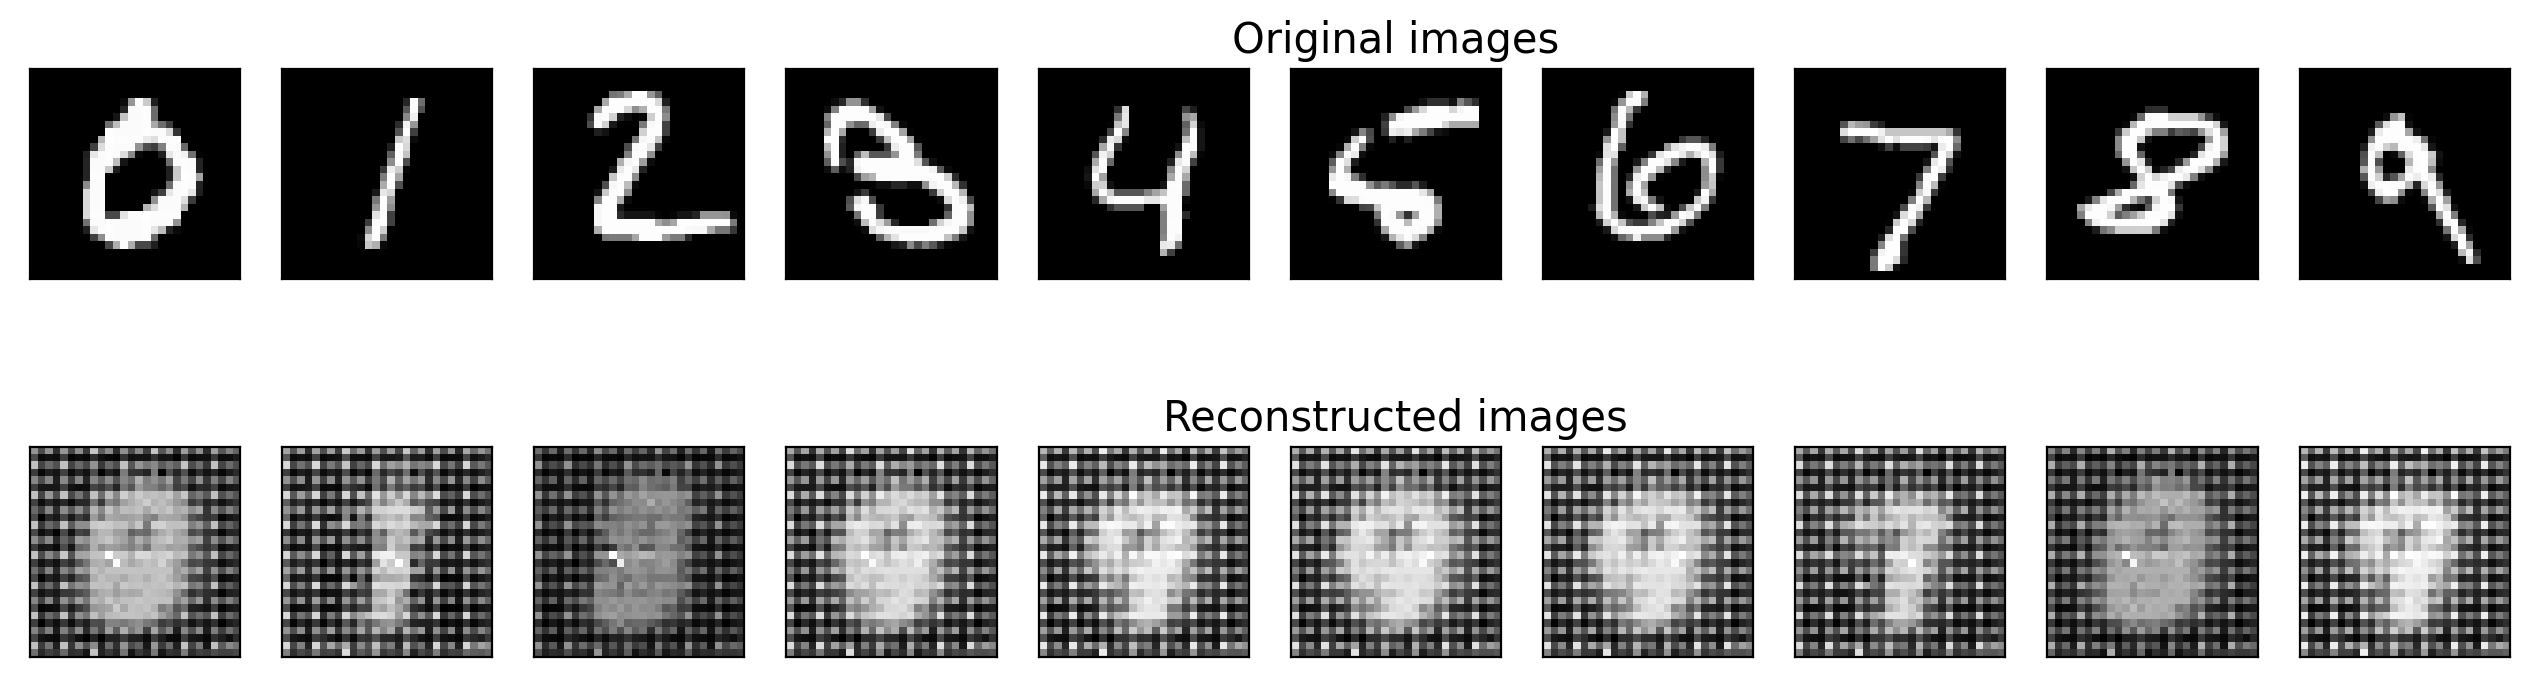


 EPOCH 2/10 	 train loss 62.361 	 val loss 48.808


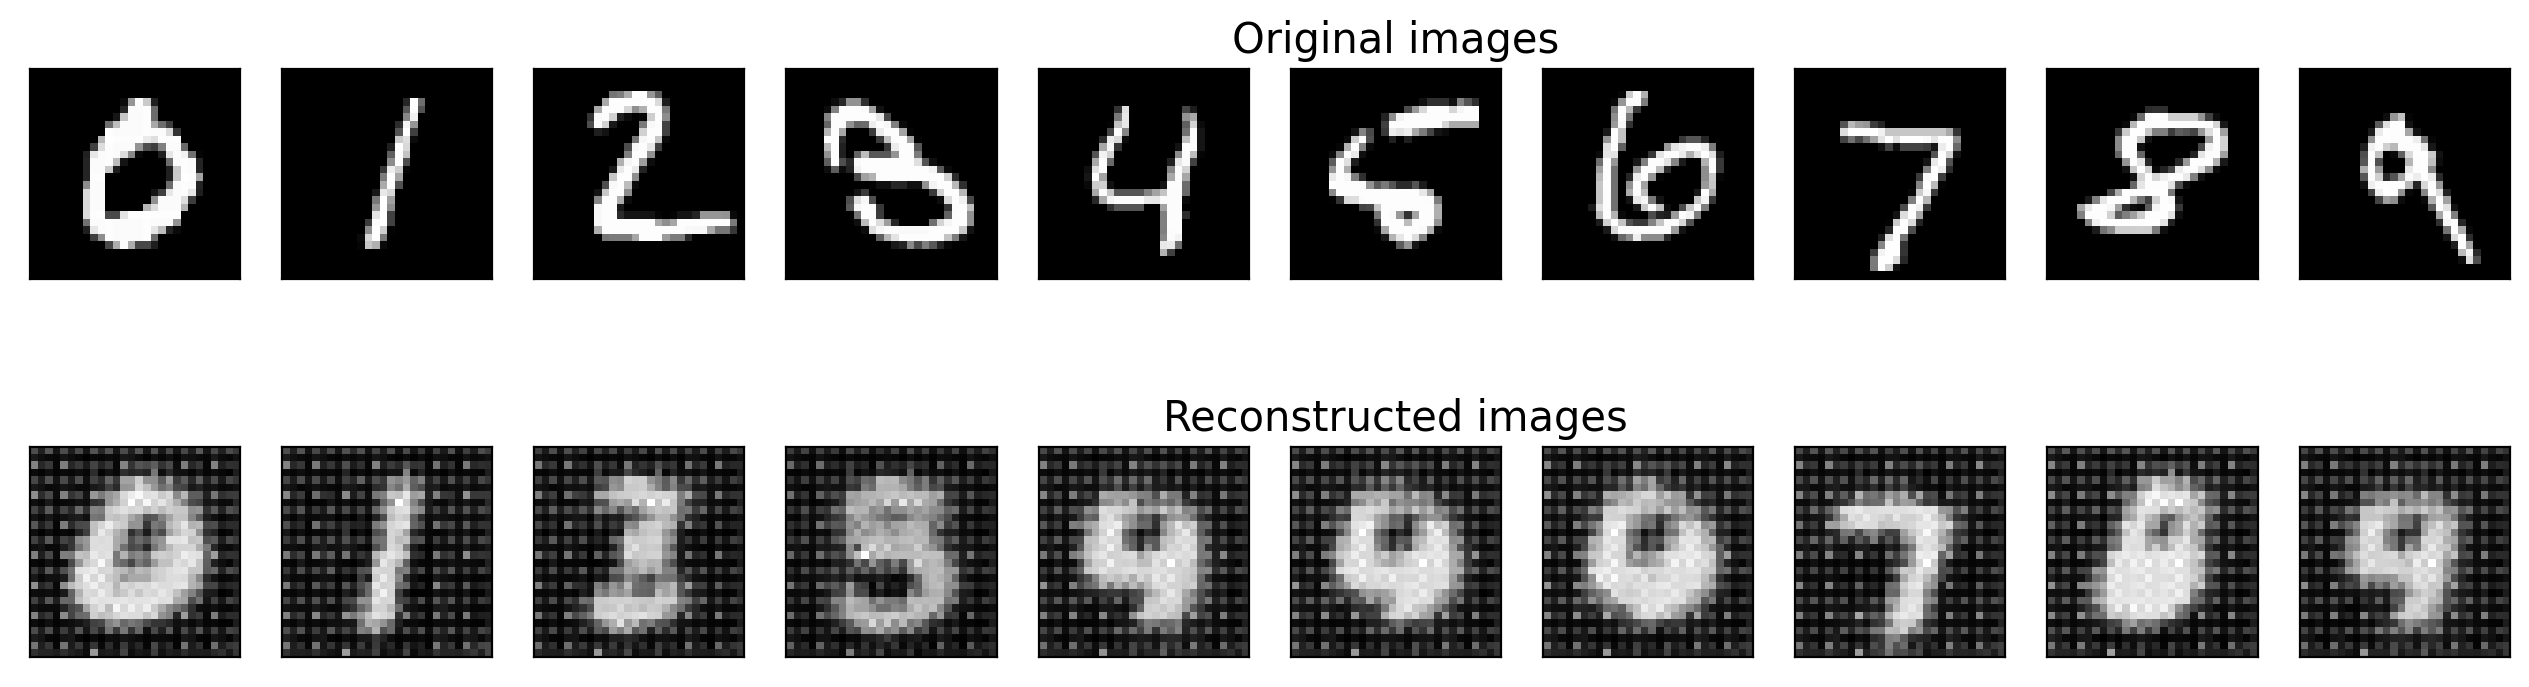


 EPOCH 3/10 	 train loss 42.865 	 val loss 39.135


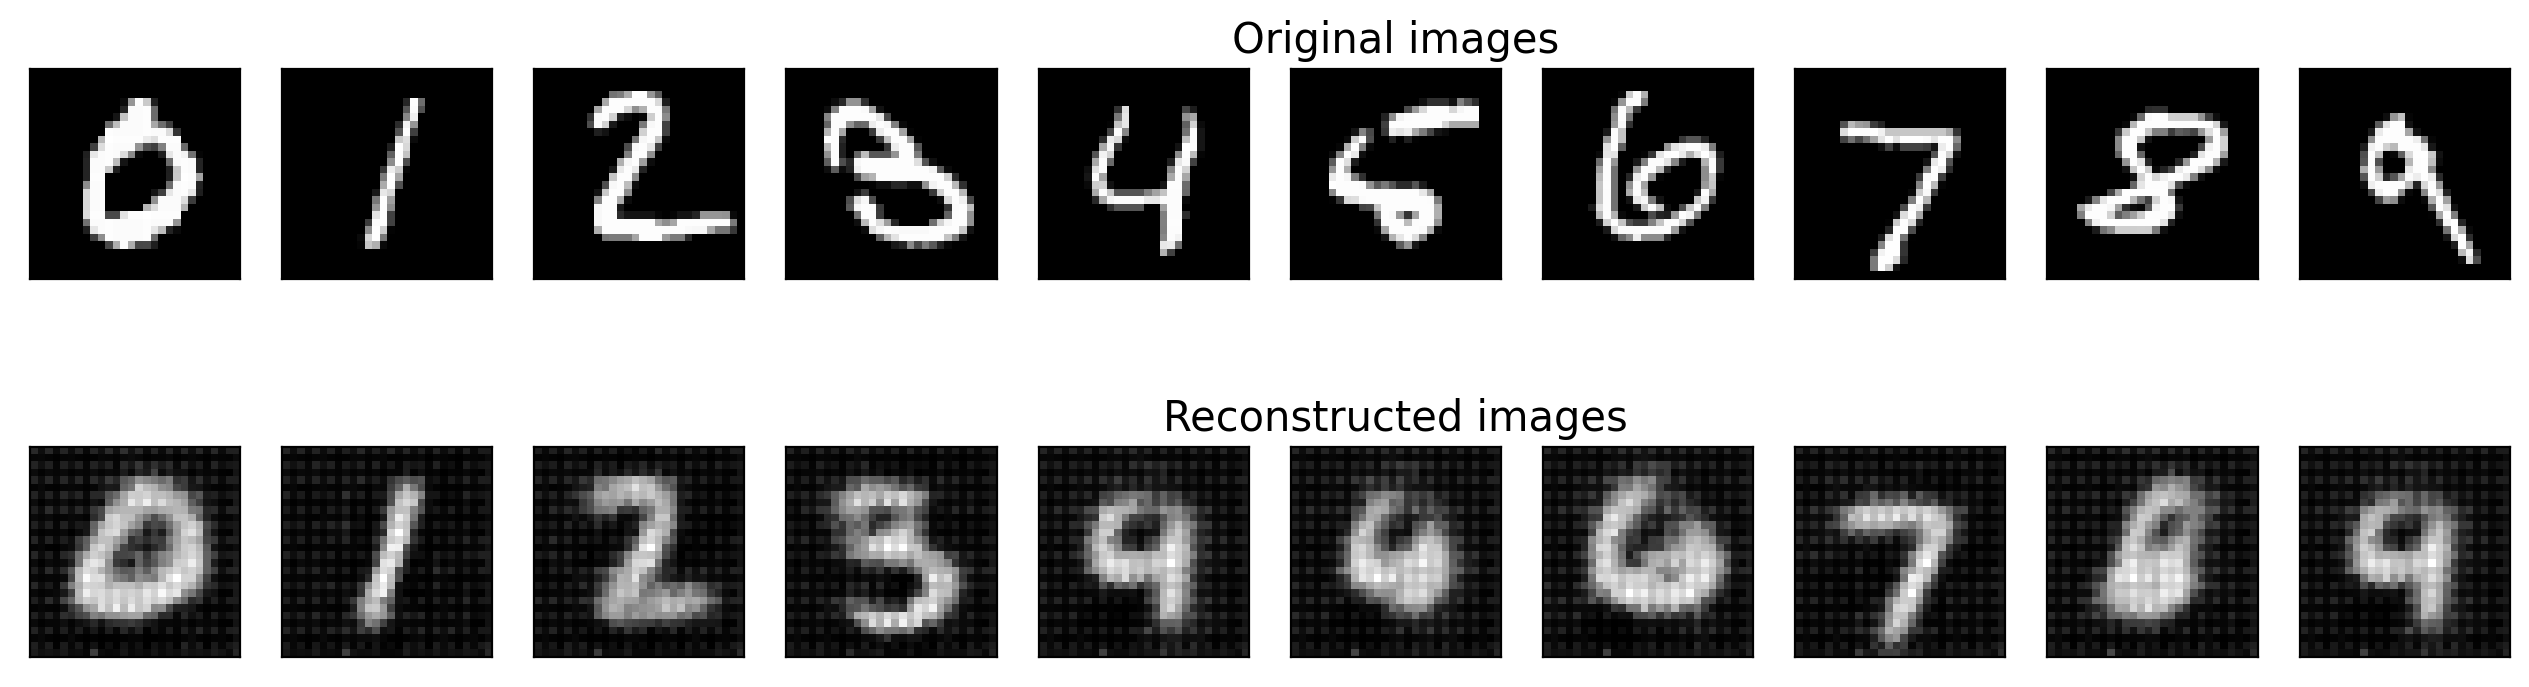


 EPOCH 4/10 	 train loss 37.316 	 val loss 35.769


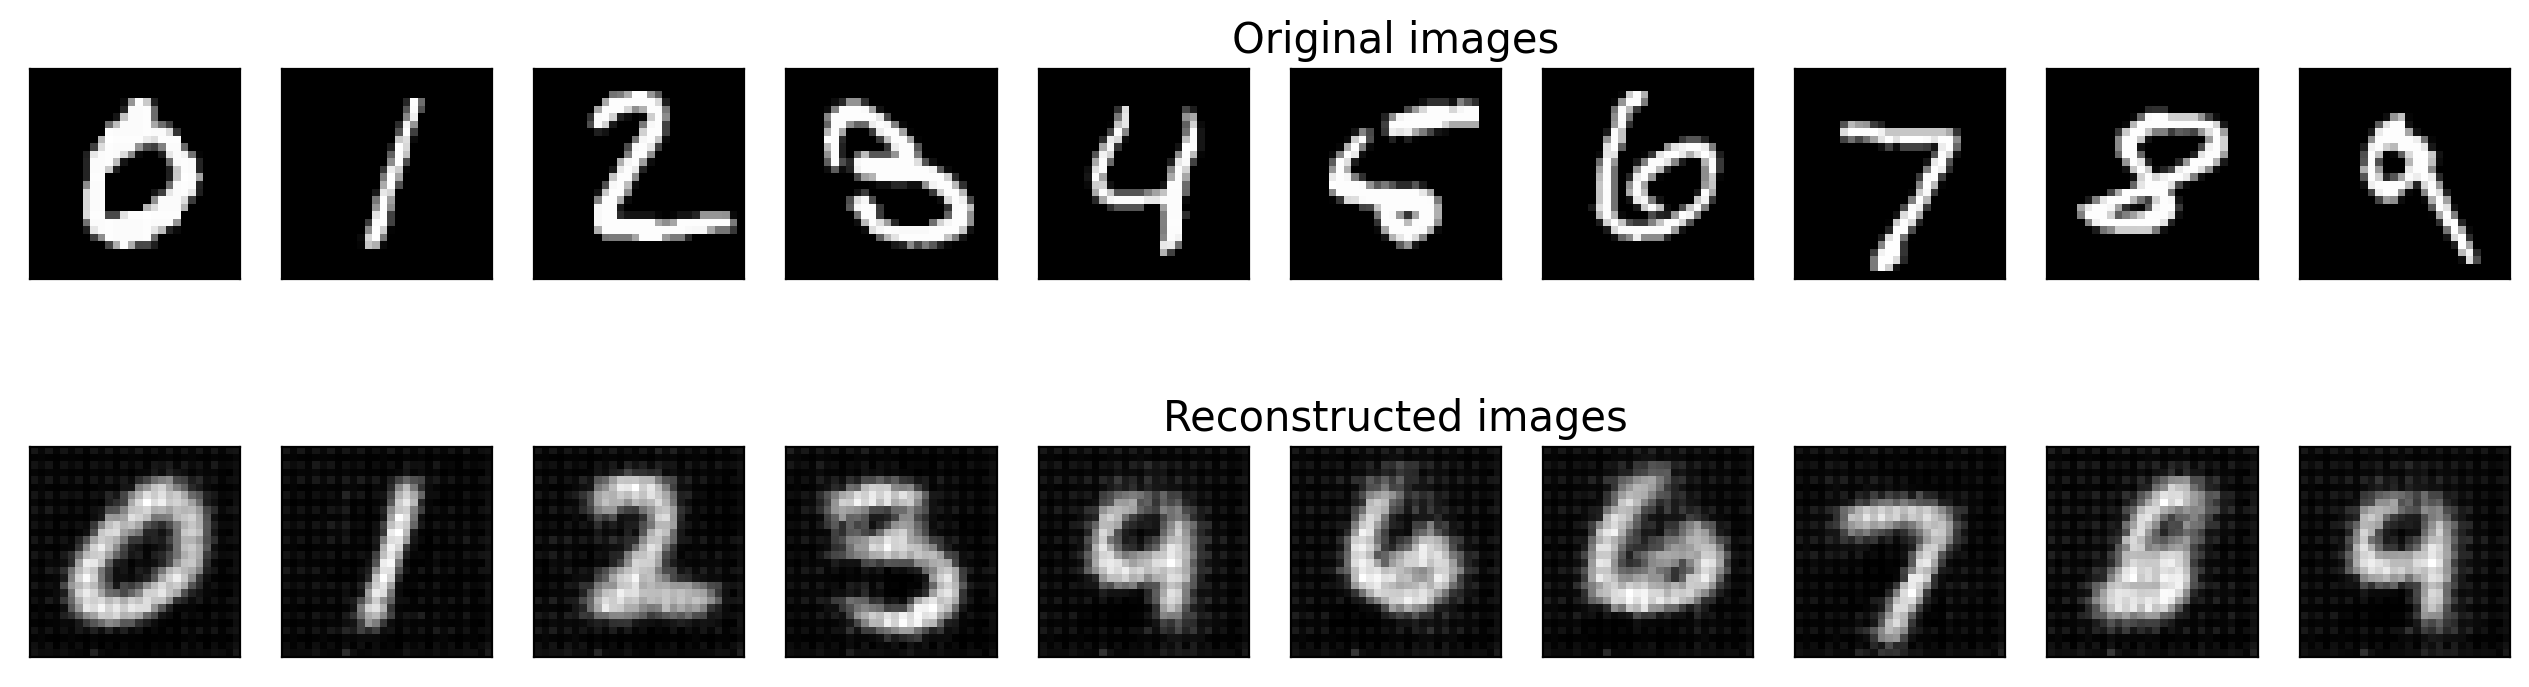


 EPOCH 5/10 	 train loss 34.955 	 val loss 34.154


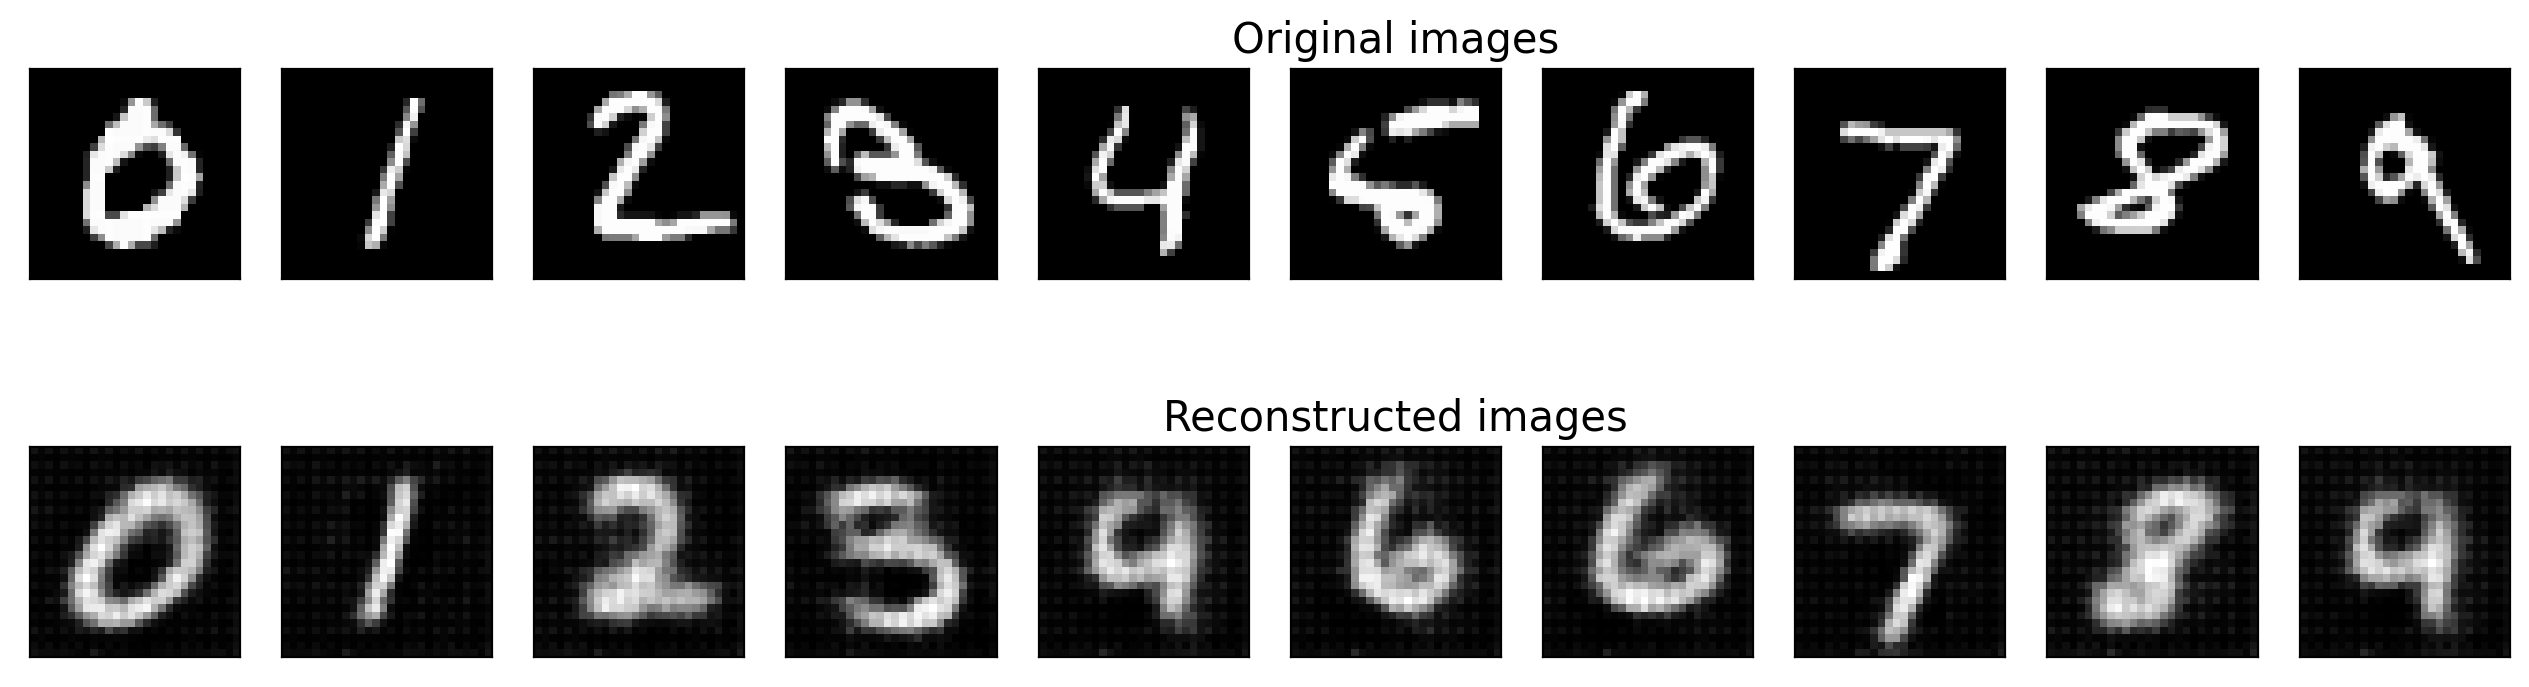


 EPOCH 6/10 	 train loss 33.527 	 val loss 33.044


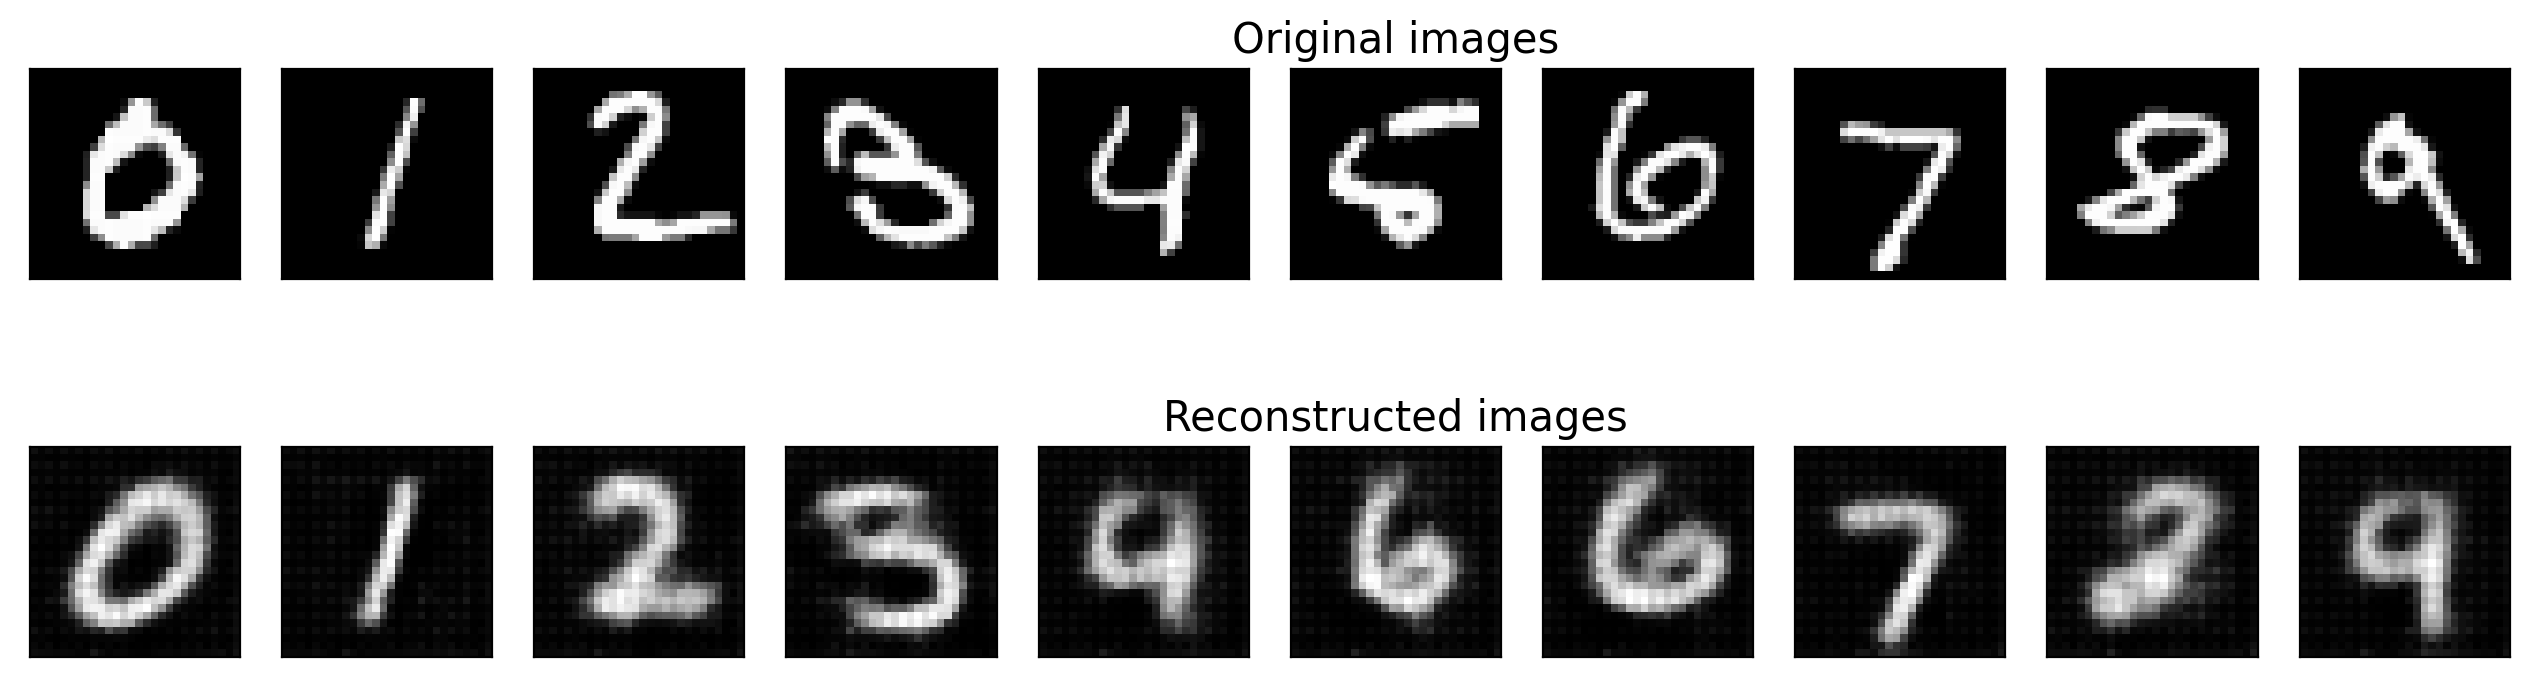


 EPOCH 7/10 	 train loss 32.542 	 val loss 32.190


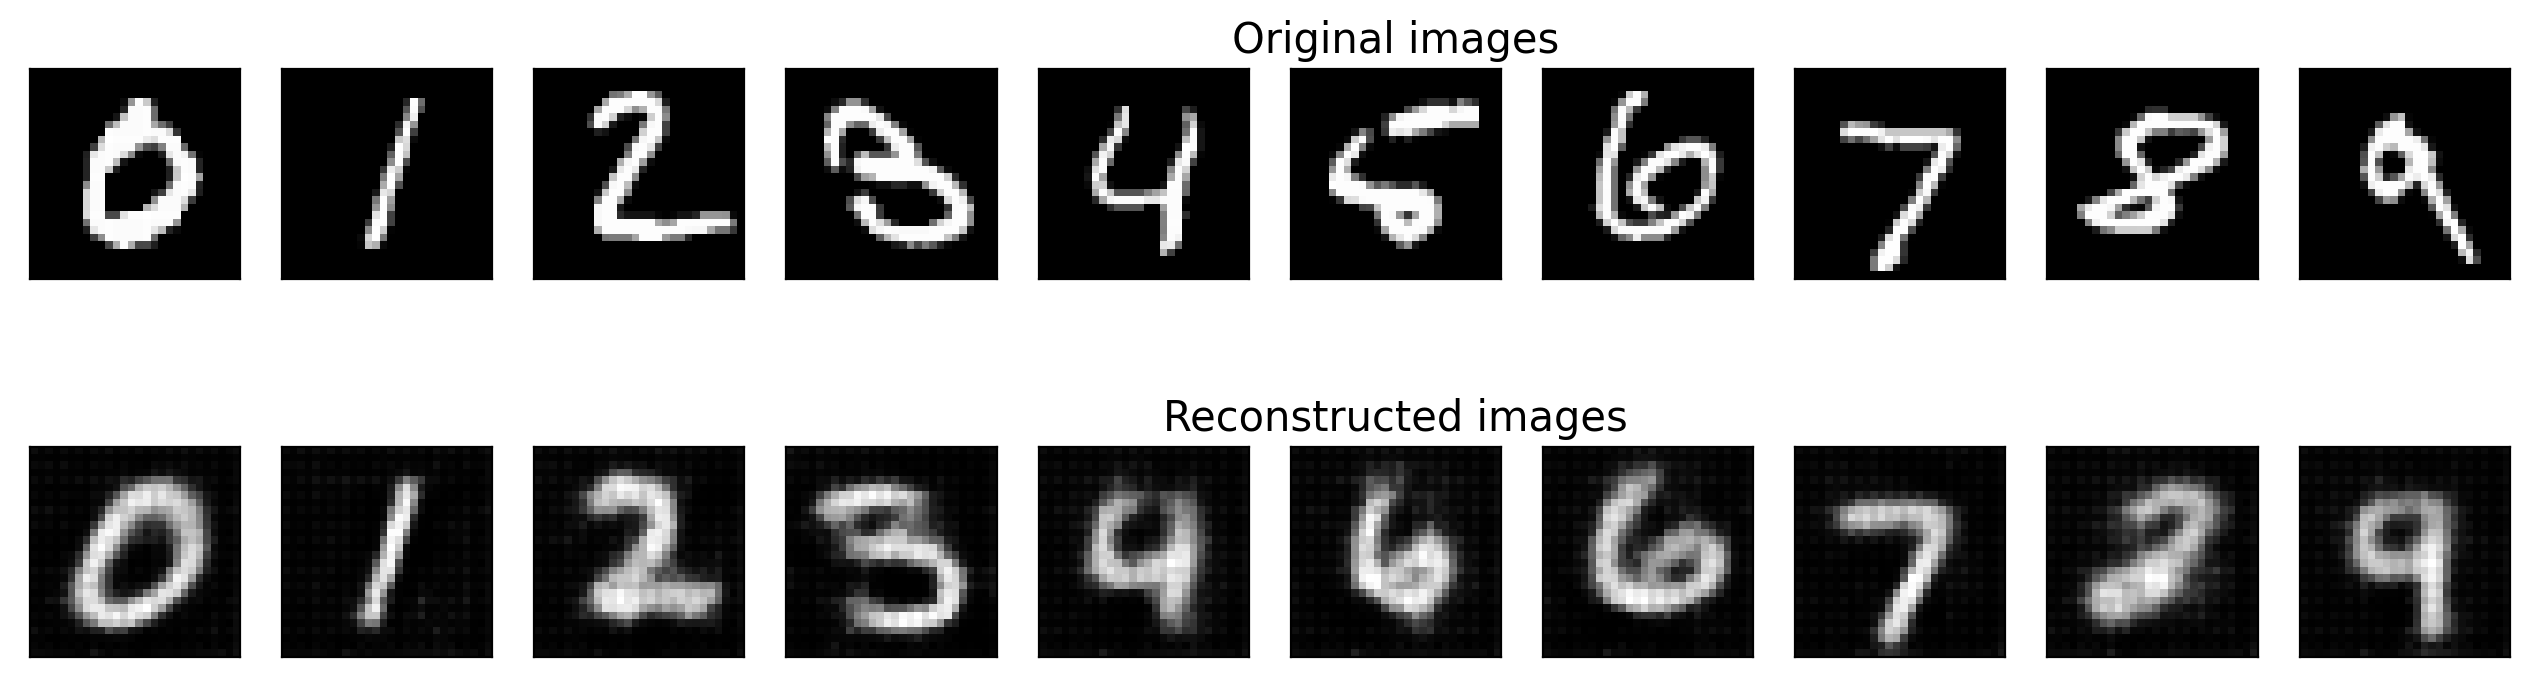


 EPOCH 8/10 	 train loss 31.811 	 val loss 31.667


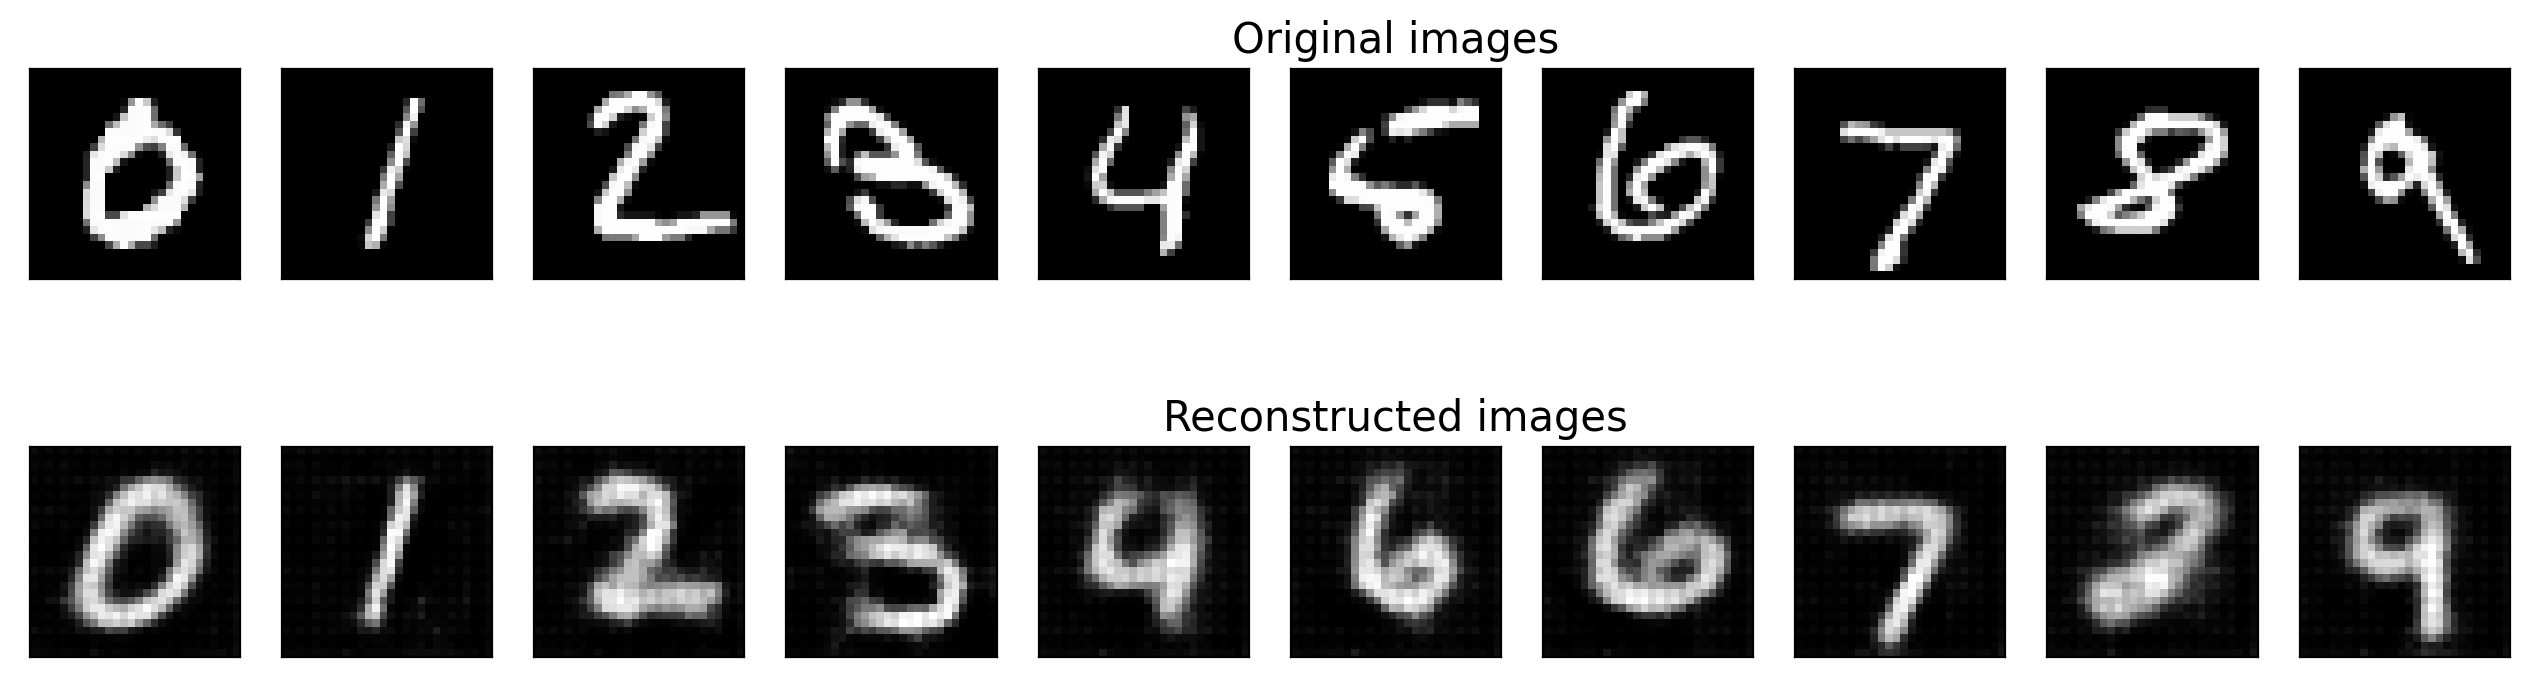


 EPOCH 9/10 	 train loss 31.291 	 val loss 31.186


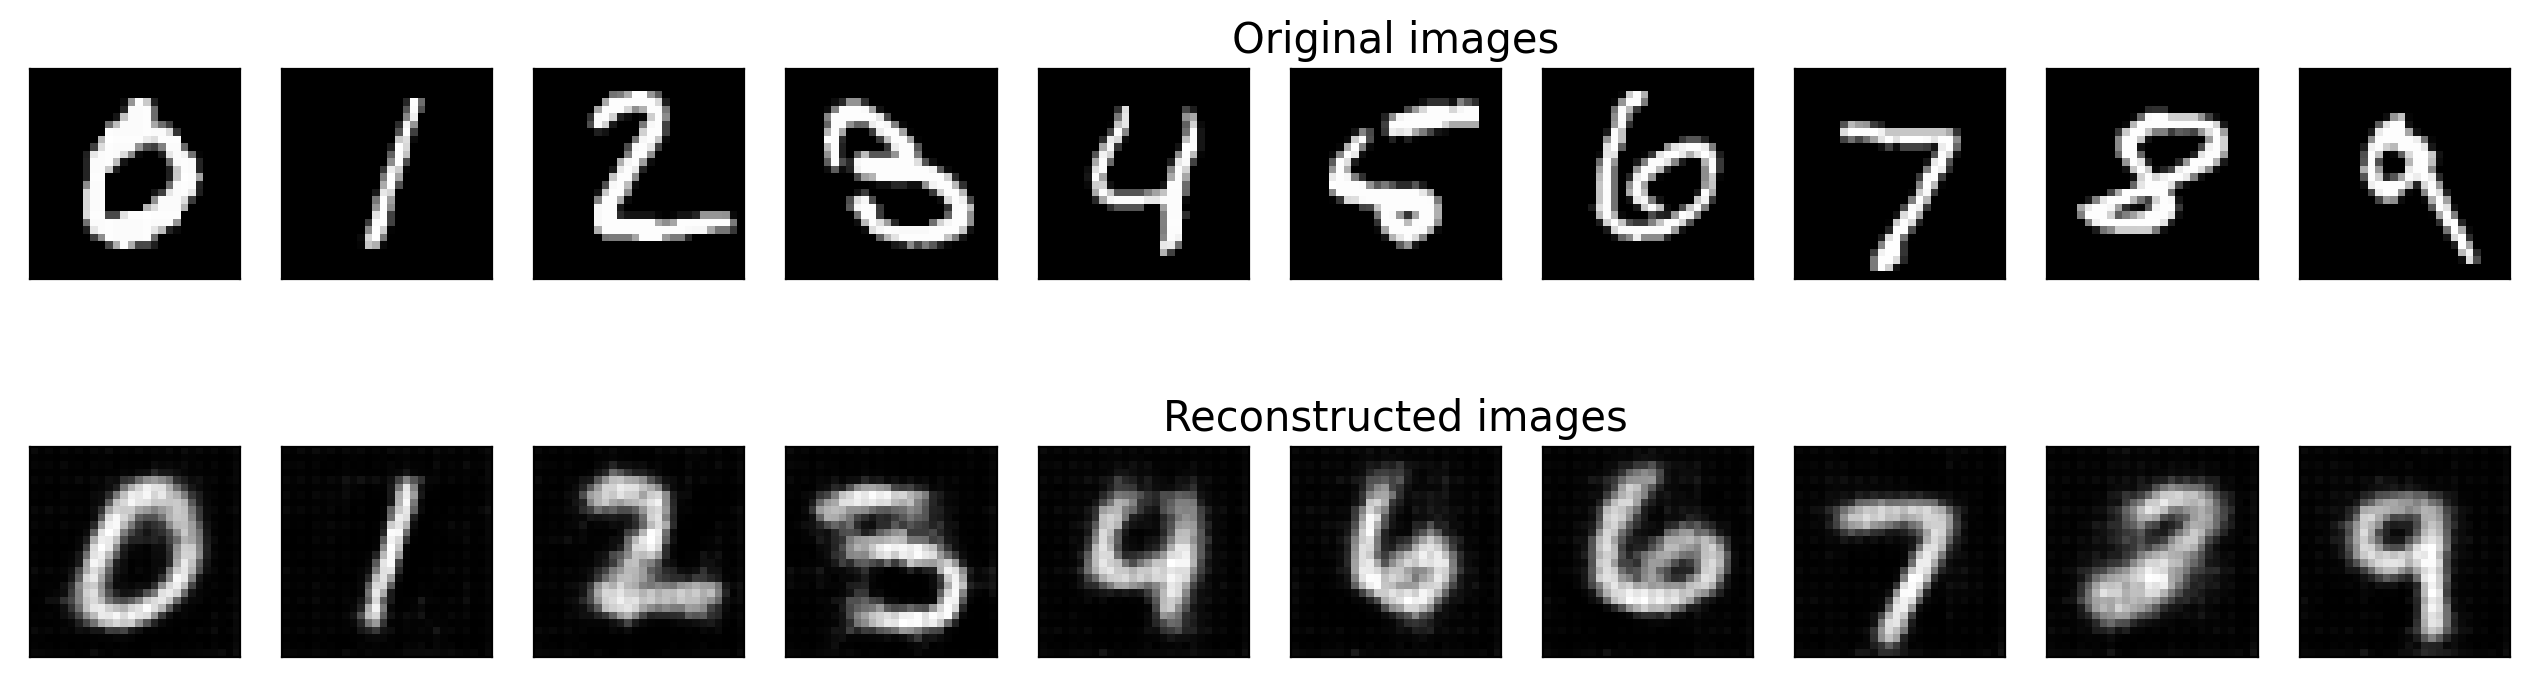


 EPOCH 10/10 	 train loss 30.882 	 val loss 30.915


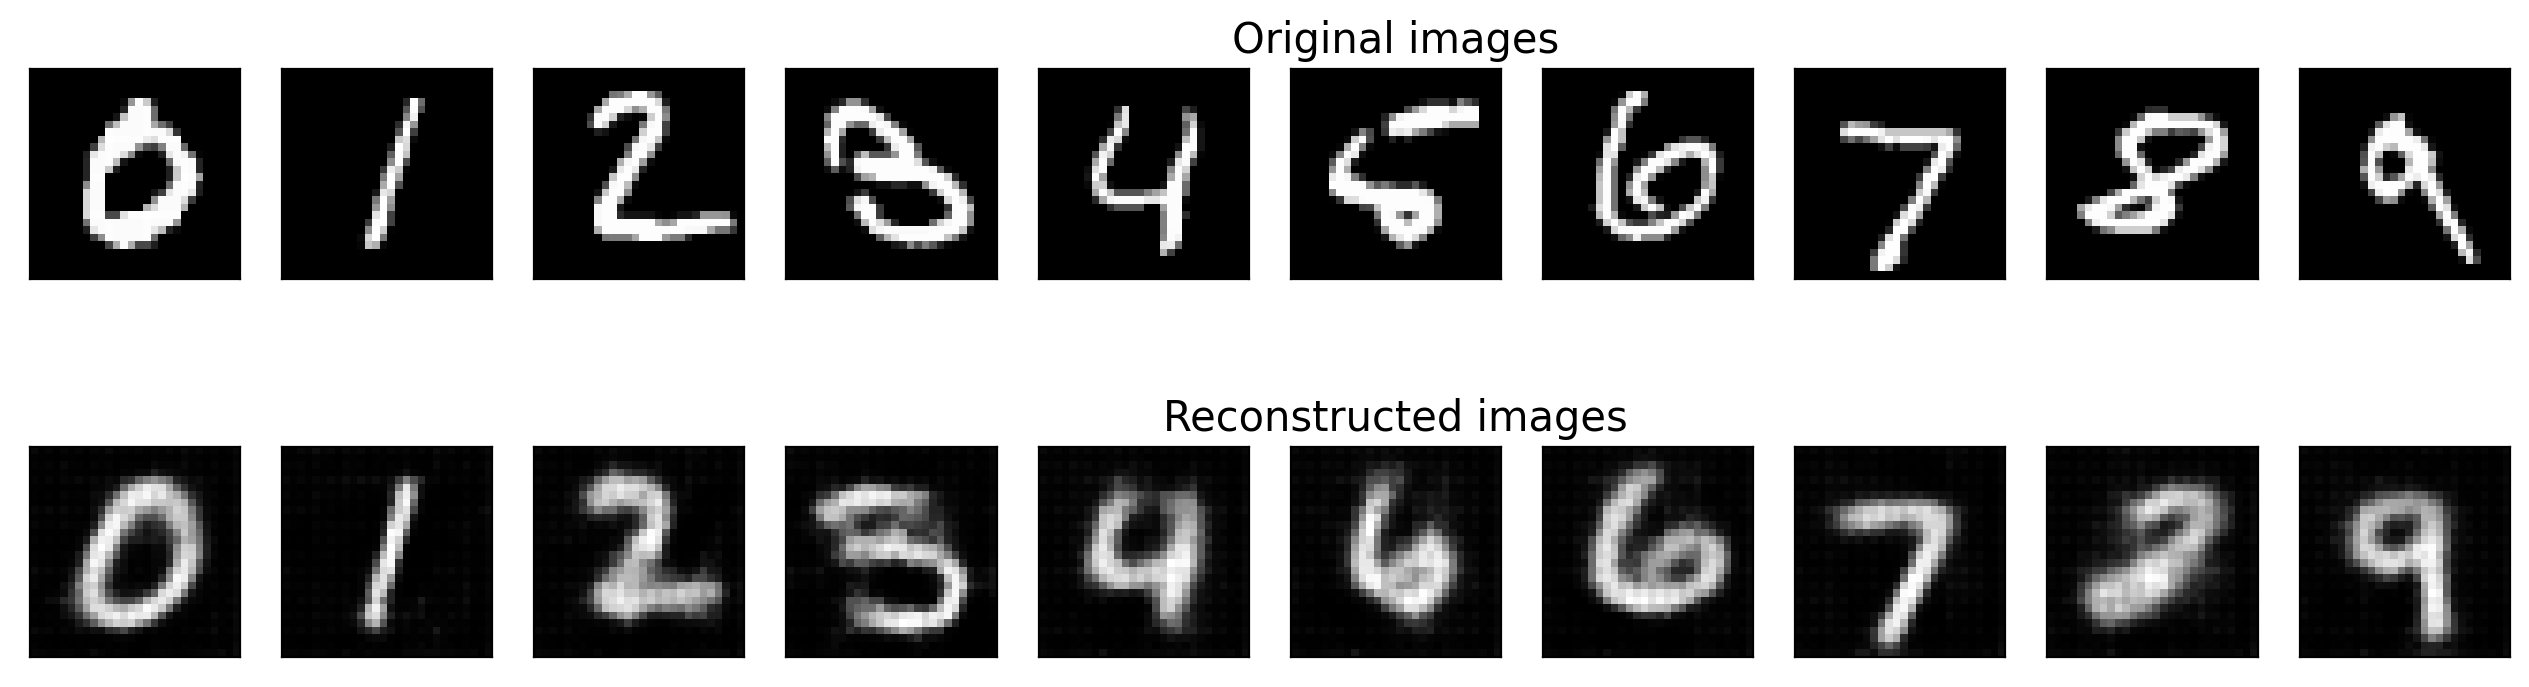

In [55]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    val_loss = test_epoch(vae,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(vae.encoder,vae.decoder,n=10)

Now, lets visualize what this looks like in the latent space. This tells us a lot of what we are learning. 

In [ ]:
def plot_reconstructed(autoencoder, r0=(-2, 2), r1=(-2, 2), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    
plot_reconstructed(vae)

<a name='section_18_7'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.7 Generating Bragg Scattering with Variational Autoencoders </h2>  



neural network to model this. The simplest way to build a neural network for this is to build a variational autoencoder. Let's go ahead and do that. For this, we will first focus on a single beam energy Additionally, we will try to predict the a few specific parameters

 * Beam Width
 * Beam Length
 * Energy deposited in last centimeter
 * Energy depsoited in the first centimeter
 
Let's go ahead and construct this guy

In [59]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

def createData(ixstep,ipstep,iestep,iystep):
    length=ixstep[:,-1]
    width =iystep[:,-1]
    efront=np.zeros(ixstep.shape[0])
    eback =np.zeros(ixstep.shape[0])
    for i0 in range(ixstep.shape[0]):
        efront[i0] = np.sum(iestep[i0,ixstep[i0] < 3])/3.
        eback[i0]  = np.sum(iestep[i0,ixstep[i0] > ixstep[i0,-1]-1])
    processed_data = np.vstack((length,width,efront,eback))
    trainset       = torch.tensor(processed_data).float()
    return trainset

indataset150=createData(xstep150,pstep150,estep150,ystep150)
indataset150=indataset150.T

indataset200=createData(xstep200,pstep200,estep200,ystep200)
indataset200=indataset200.T

indataset250=createData(xstep250,pstep250,estep250,ystep250)
indataset250=indataset250.T

indataset300=createData(xstep300,pstep300,estep300,ystep300)
indataset300=indataset300.T

indataset   = np.vstack((indataset150,indataset200,indataset250,indataset300))
print(indataset.shape)

(4000, 4)


In [60]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def nfeatures(self):
        return self.samples.shape[1]
    
    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y
    
dataset150=DataSet(samples=indataset150,labels=np.ones(indataset150.shape[0])*150)
dataset=DataSet(samples=indataset,labels=np.ones(indataset.shape[0])*150)

Now that we have constructed a simple dataset, we can go ahead and make a variational autoencoder to describe all this information. Since we are not taking images for the moment, we can do this with dense layers. 

In [61]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dims,latent_dims):  
        super(VariationalAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 10*input_dims)
        self.batch = nn.BatchNorm1d(10*input_dims)
        self.linear2 = nn.Linear(10*input_dims, 10*input_dims)
        self.linear3 = nn.Linear(10*input_dims, latent_dims)
        self.linear4 = nn.Linear(10*input_dims, latent_dims)

        #Now we need sample in phase space 
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 25*input_dims),
            nn.ReLU(True),
            nn.Linear(25*input_dims, 25*input_dims),
            nn.ReLU(True),
            nn.Linear(25*input_dims, input_dims),
        )

        
    def encoder(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.batch(self.linear2(x)))
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear3(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear4(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear 
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z
            
    def decoder(self, x):
        x = self.decoder_lin(x)
        return x
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
torch.manual_seed(0)
d = 2
vae = VariationalAutoEncoder(input_dims=dataset.nfeatures(),latent_dims=d)
lr = 1e-3 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
#valid_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [62]:
num_epochs = 5001

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    #val_loss = test_epoch(vae,valid_loader)
    if epoch % 500 == 0:
        print('EPOCH {}/{} \t train loss {:.3f} \t'.format(epoch + 1, num_epochs,train_loss))


EPOCH 1/5001 	 train loss 1447.889 	
EPOCH 501/5001 	 train loss 7.309 	
EPOCH 1001/5001 	 train loss 6.470 	
EPOCH 1501/5001 	 train loss 6.339 	
EPOCH 2001/5001 	 train loss 6.148 	
EPOCH 2501/5001 	 train loss 6.074 	
EPOCH 3001/5001 	 train loss 6.070 	
EPOCH 3501/5001 	 train loss 6.025 	
EPOCH 4001/5001 	 train loss 5.982 	
EPOCH 4501/5001 	 train loss 6.008 	
EPOCH 5001/5001 	 train loss 5.960 	


Now, we can generate our own events from the VAE. 

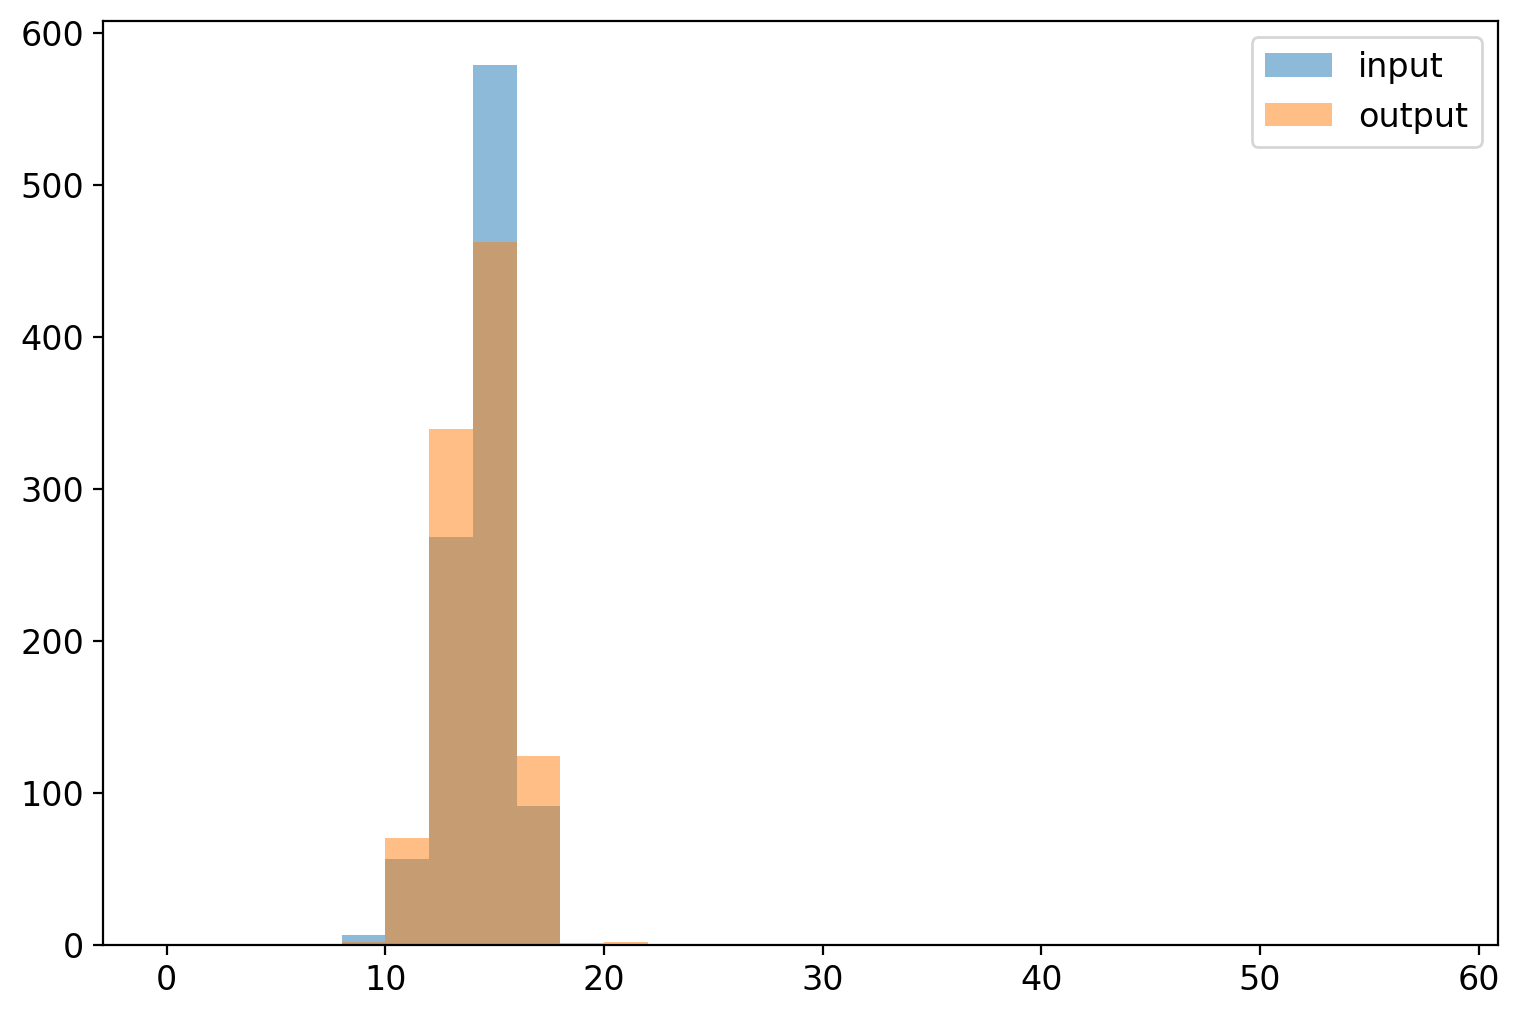

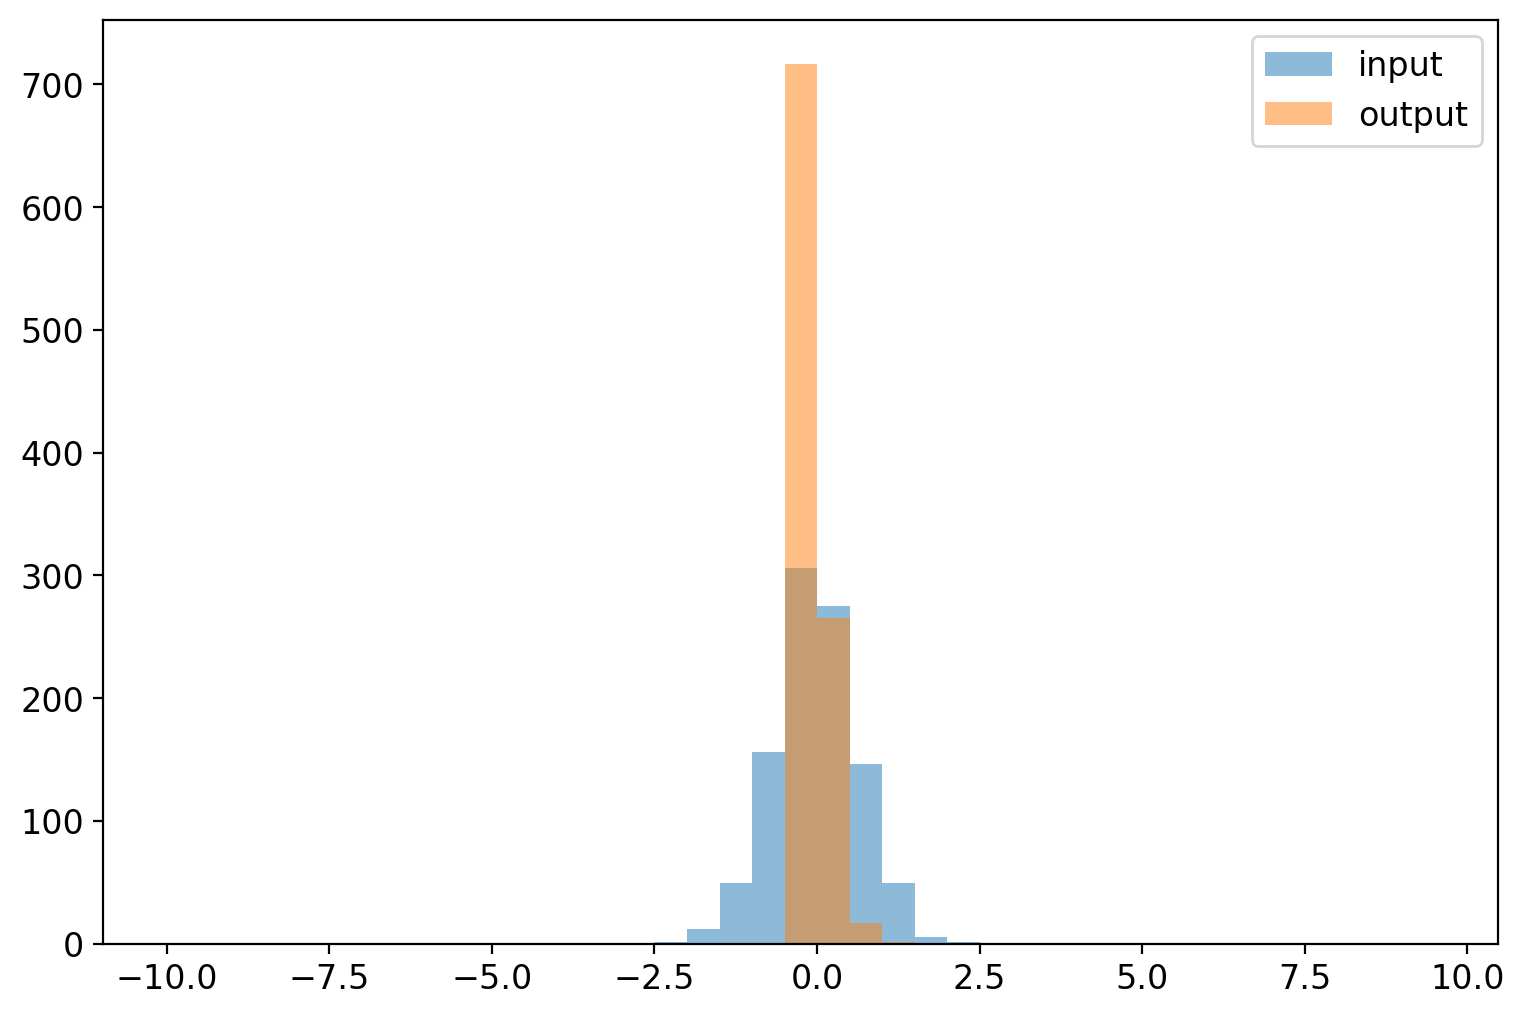

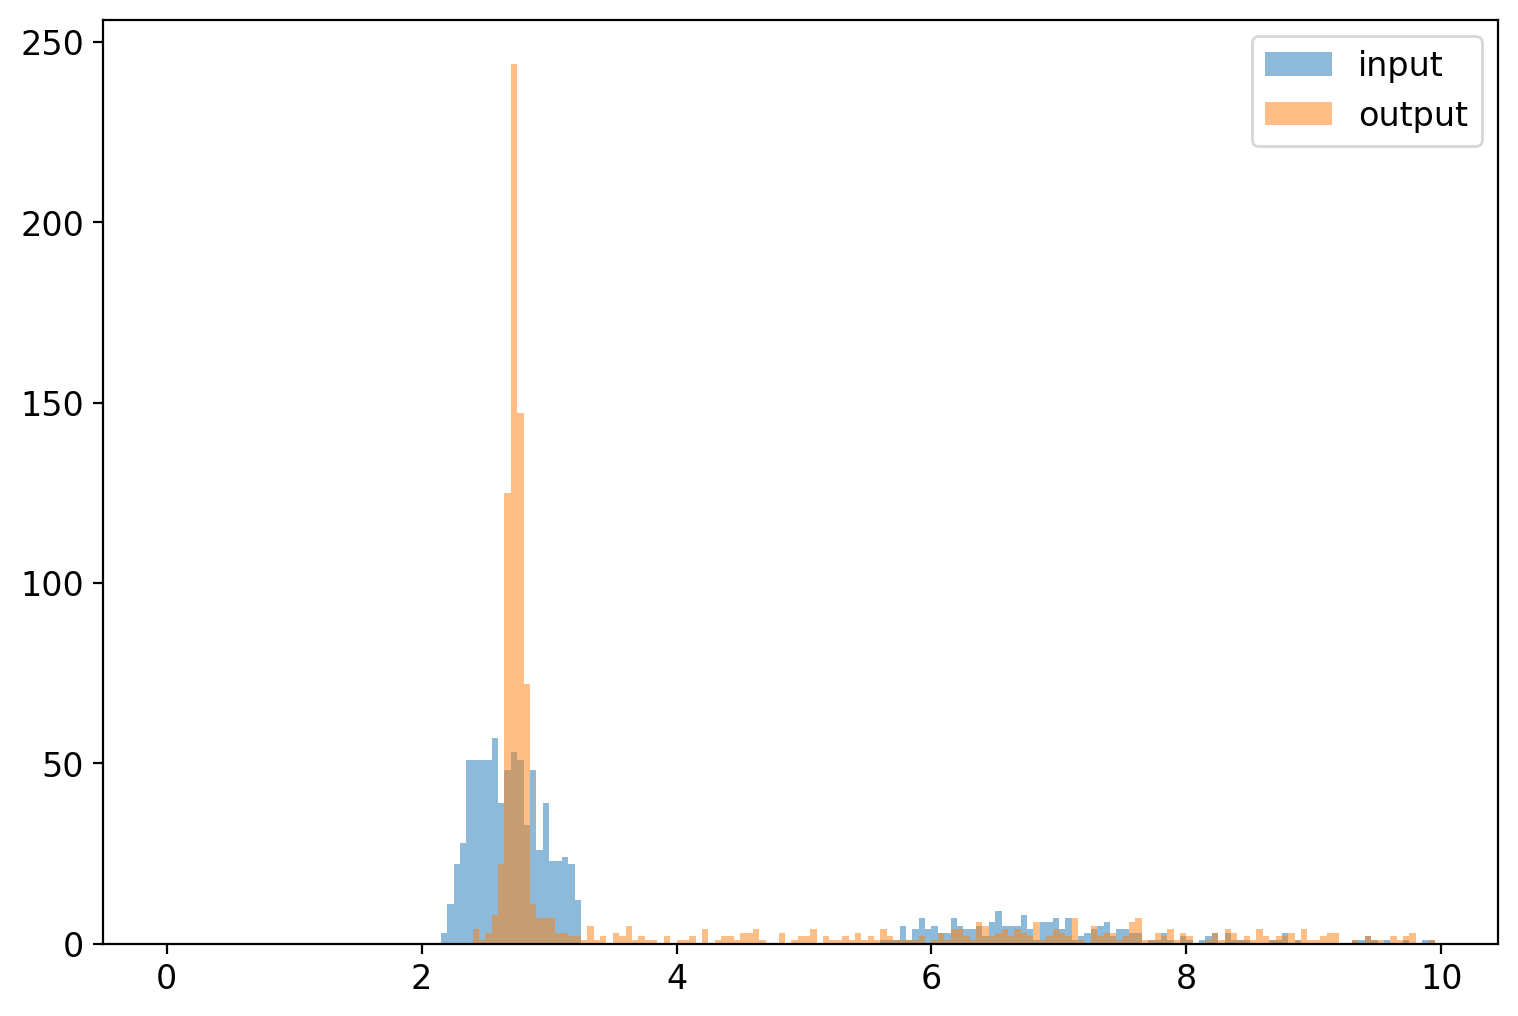

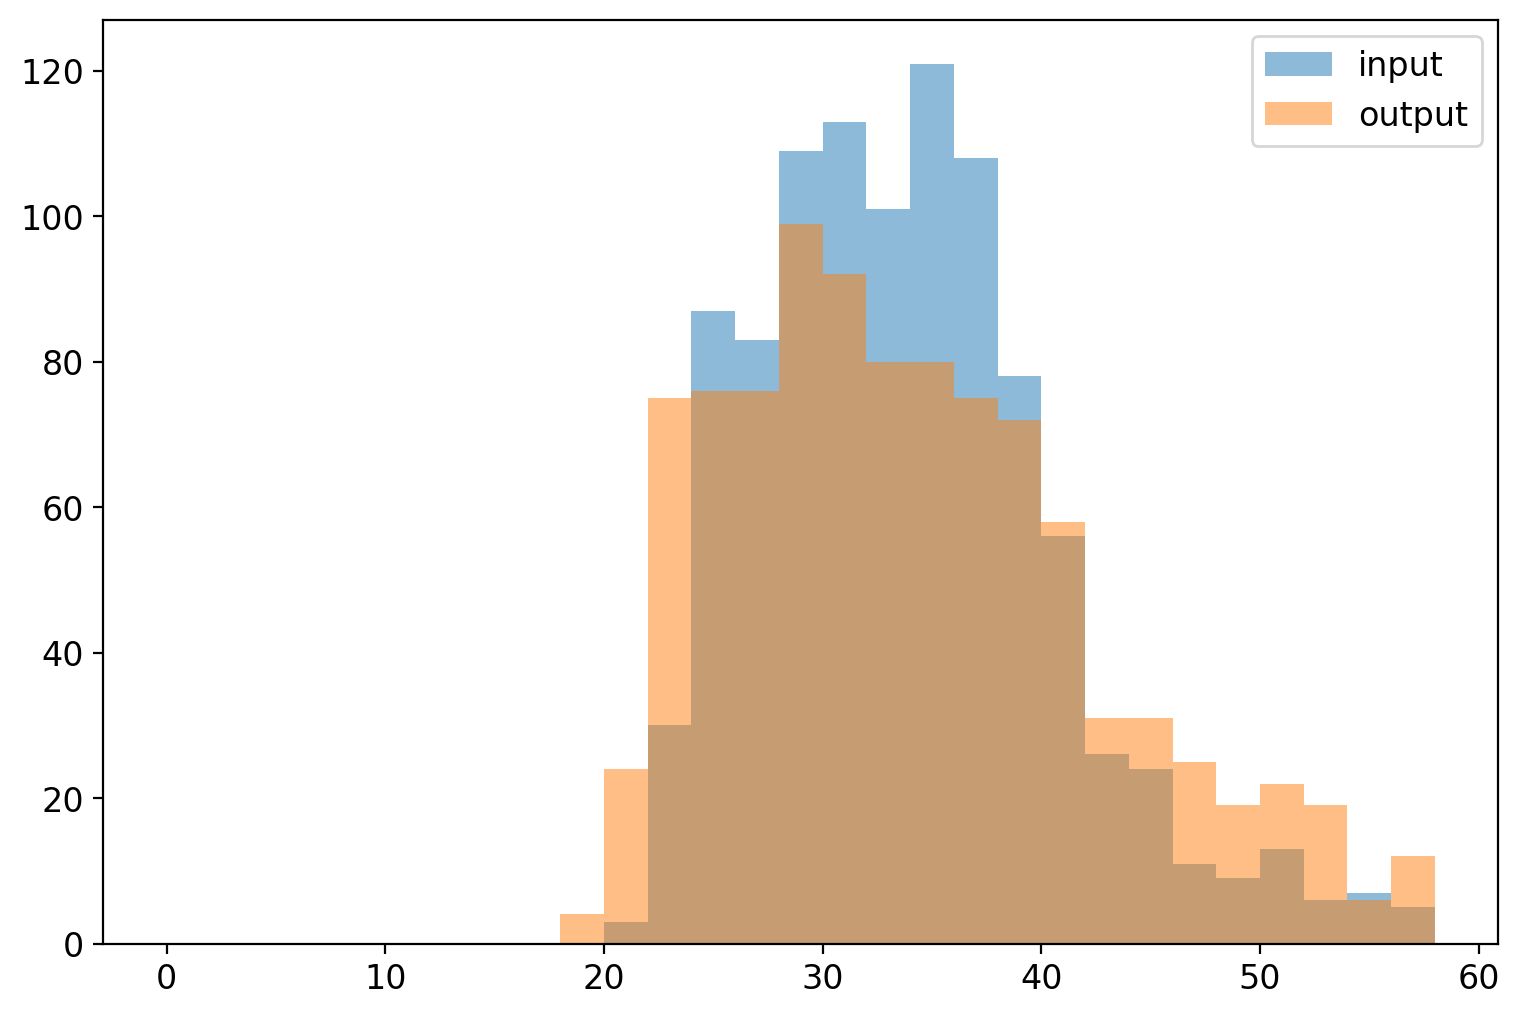

In [63]:
def plotVAEOutputs(iLatentDim,iDataSet):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    outputvars=vae.decoder(testlatent)

    xrange=np.arange(0,60,2)
    plt.hist(iDataSet[:,0],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,0].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(-10,10,0.5)
    plt.hist(iDataSet[:,1],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,1].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(0,10,0.05)
    plt.hist(iDataSet[:,2],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,2].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(iDataSet[:,3],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,3].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

plotVAEOutputs(d,indataset150)

Now that captured most of the high level features, we can naturally play around with the system and try to get get it better. 

### Q15.XX  

Train the above with 4 latent dimensions using just the 150 MeV dataset how good is the agreement? Why are you not surprised that 4 dimensions is so good? 

EPOCH 1/5001 	 train loss 1413.314 	
EPOCH 501/5001 	 train loss 6.950 	
EPOCH 1001/5001 	 train loss 6.789 	
EPOCH 1501/5001 	 train loss 6.715 	
EPOCH 2001/5001 	 train loss 6.722 	
EPOCH 2501/5001 	 train loss 6.763 	
EPOCH 3001/5001 	 train loss 6.815 	
EPOCH 3501/5001 	 train loss 6.533 	
EPOCH 4001/5001 	 train loss 6.578 	
EPOCH 4501/5001 	 train loss 6.698 	
EPOCH 5001/5001 	 train loss 6.545 	


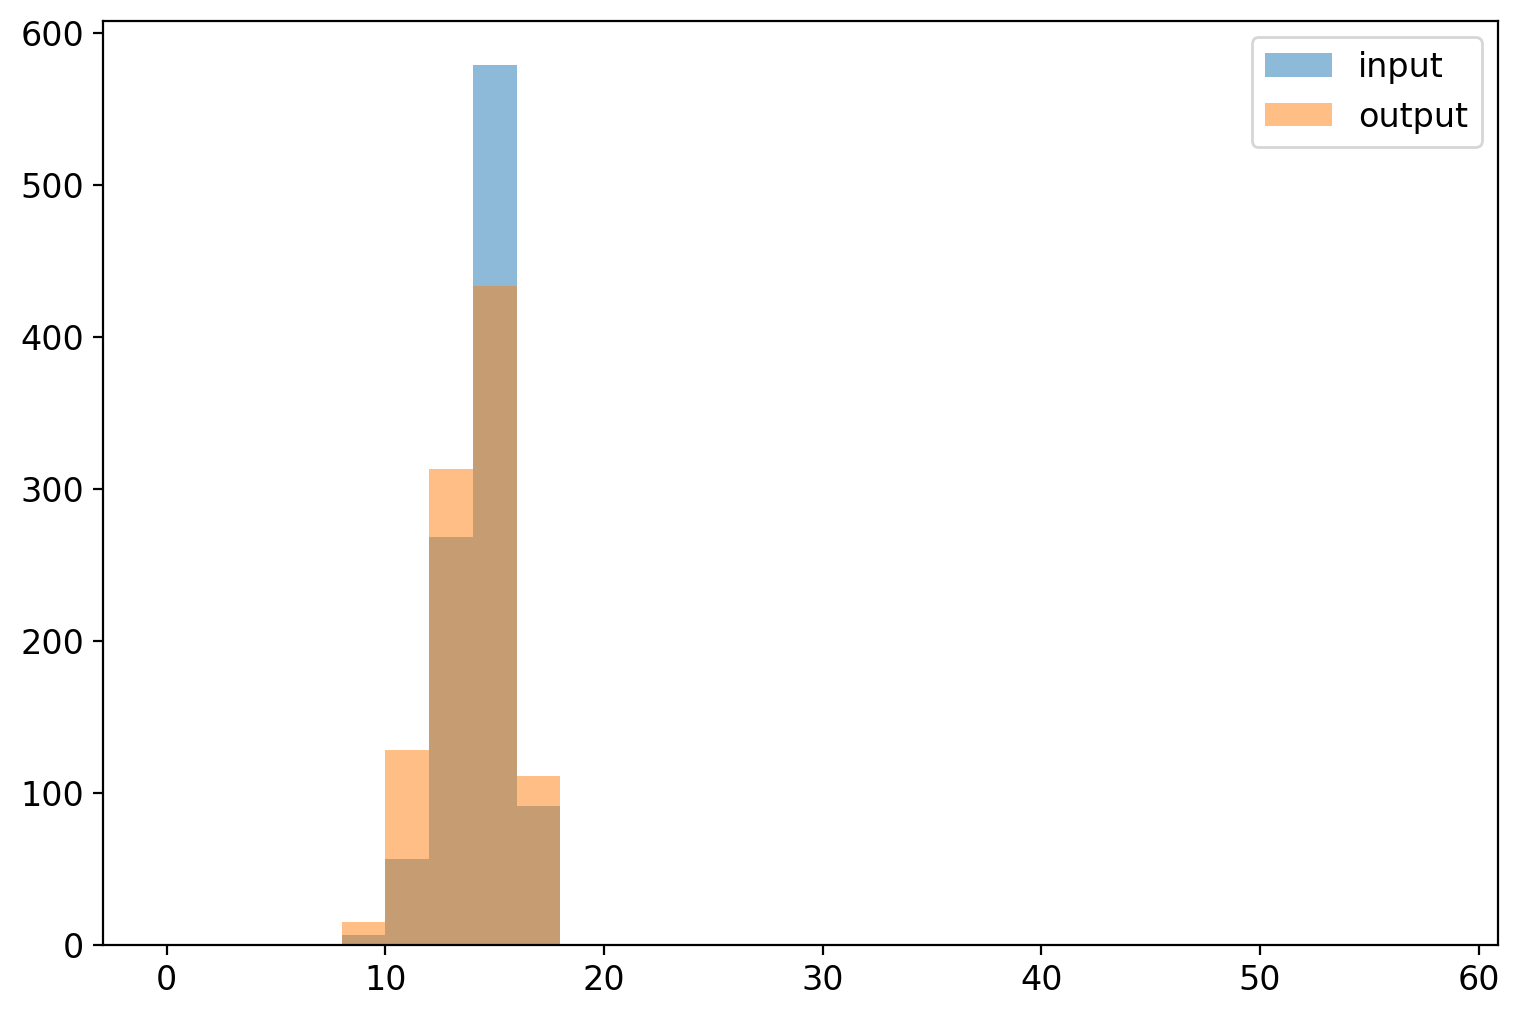

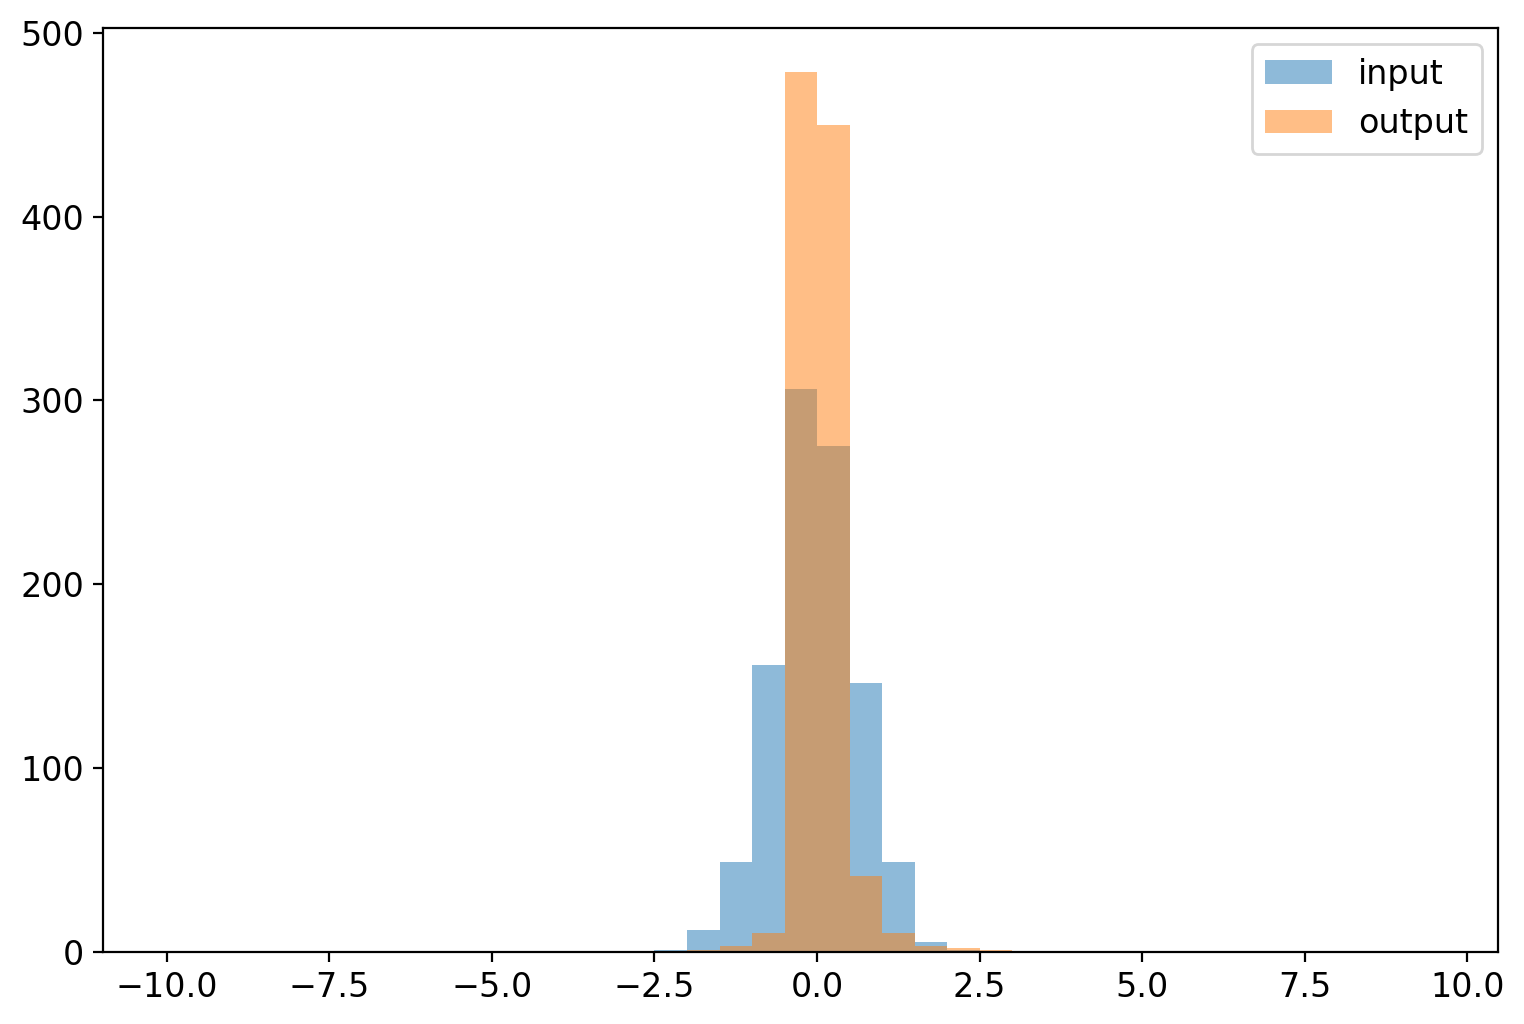

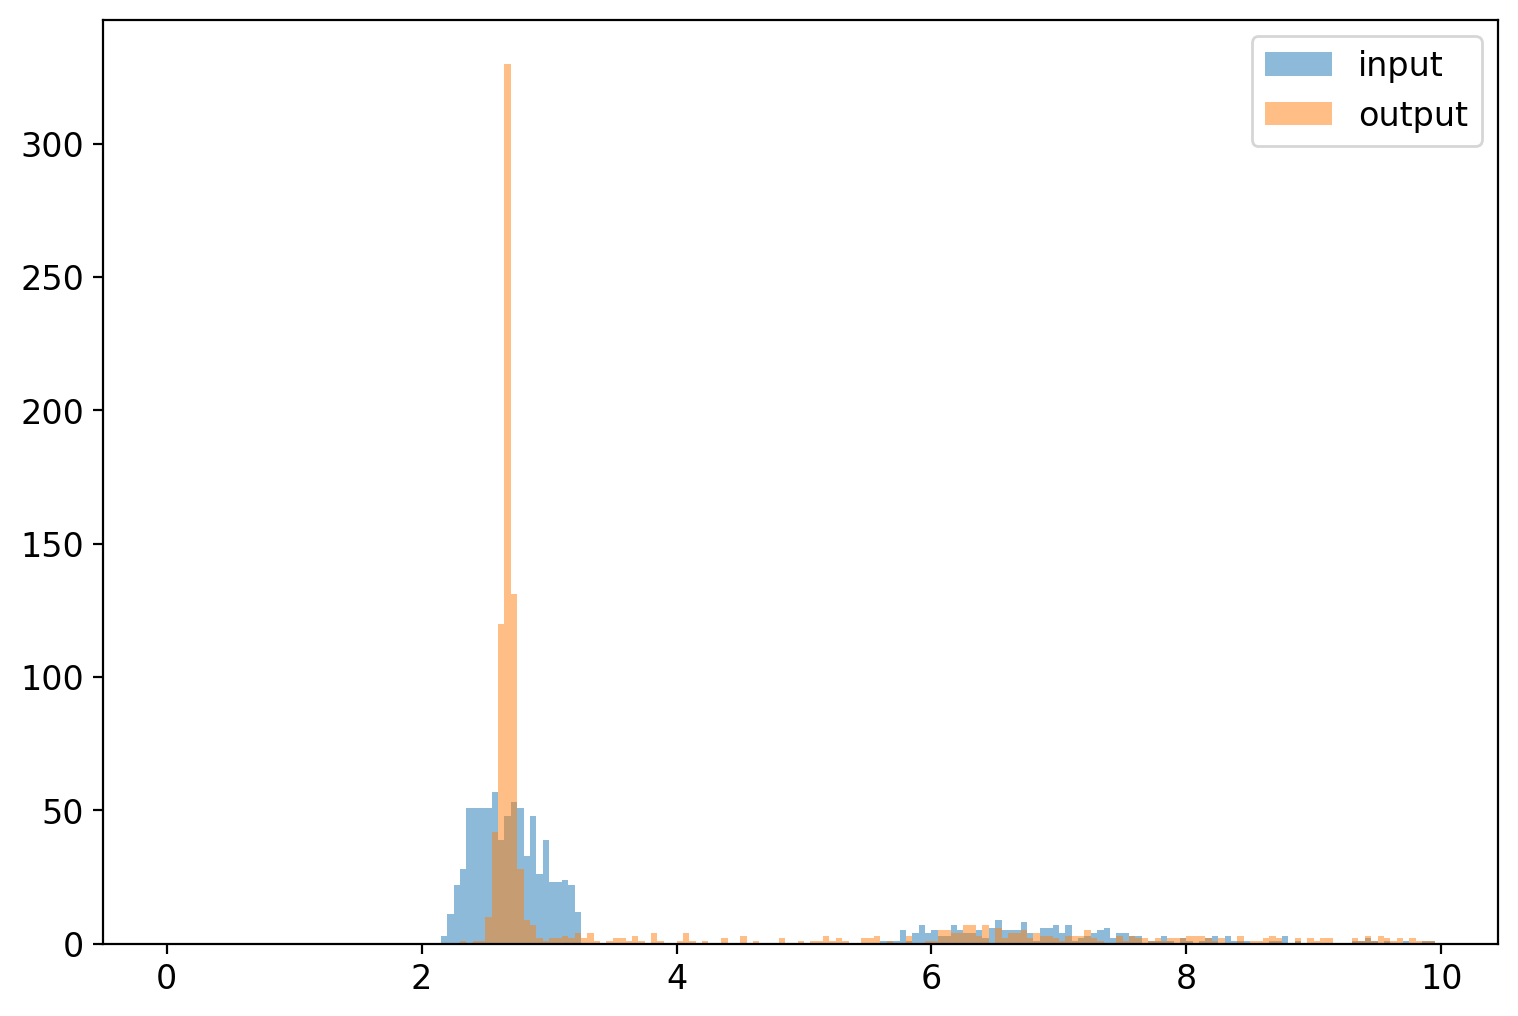

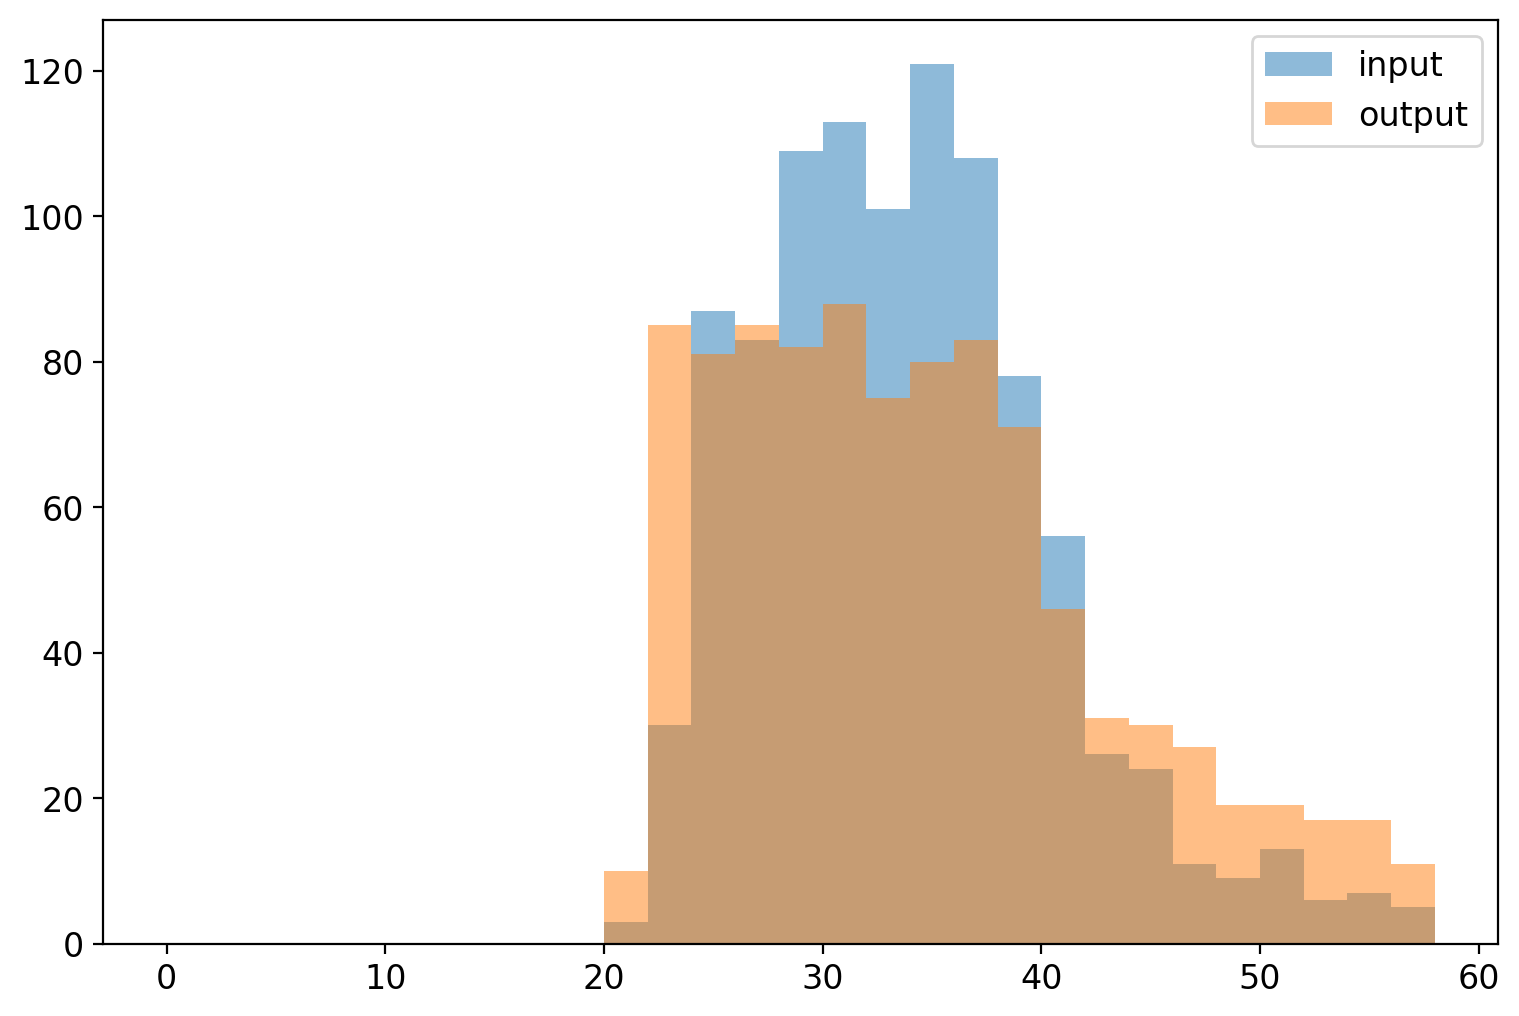

In [64]:
torch.manual_seed(0)
d = 4
vae = VariationalAutoEncoder(input_dims=dataset.nfeatures(),latent_dims=d)
lr = 1e-2 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
num_epochs = 5001

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    #val_loss = test_epoch(vae,valid_loader)
    if epoch % 500 == 0:
        print('EPOCH {}/{} \t train loss {:.3f} \t'.format(epoch + 1, num_epochs,train_loss))

plotVAEOutputs(d,indataset150)

<a name='section_18_7'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.8 Generating Full Bragg Scattering details </h2>  



Given the success of above, lets look at our events and see if we can try to generate a fully detailed event. Recall that we actually save the energy loss, x and y positions of each proton event. We can translate this to directly to an image by considering the Z-axis as the energy deposited. Lets go ahead and try to translate this to an image, and see what it looks like. 

In [110]:
def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now lets make a regular image 
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())  
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])  
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)  
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)


def makeImageDataSet(iE,ixstep,iestep,iystep):
    dataset=np.empty((0,1,28,28))
    for pX,pE,pY in zip(ixstep,iestep,iystep):
        xbin = np.arange(-1,57, 2)
        ybin = np.arange(-3.625, 3.625, 0.25)
        H, xedges, yedges = np.histogram2d(pX.flatten(), pY.flatten(), bins=(xbin, ybin),weights=pE.flatten())  
        #H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())  
        #plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])  
        #plt.show()
        H = np.reshape(H.T,(1,1,28,28))
        dataset = np.vstack((dataset,H))
    print(dataset.shape)
    Tdataset = torch.tensor(dataset).float()
    datasetout=DataSet(samples=Tdataset,labels=np.ones(dataset.shape[0])*iE)
    return datasetout,dataset
image150,dimage150=makeImageDataSet(1.50,xstep150,estep150,ystep150)
image200,dimage200=makeImageDataSet(2.00,xstep200,estep200,ystep200)
image250,dimage250=makeImageDataSet(2.50,xstep250,estep250,ystep250)
image300,dimage300=makeImageDataSet(3.00,xstep300,estep300,ystep300)

ValueError: x and y must have the same length.

Now from this lets go ahead and make a VAE that describes our dataset. We can exploit the VAE architecture used above, just slightly tweaked. 

In [66]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        #Now we need sample in phase space 
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )


    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear 
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

            
    def decoder(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
torch.manual_seed(0)
d = 4
vae = VariationalAutoEncoder(latent_dims=d)
lr = 1e-2 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(image150, batch_size=500)

In [67]:
def plot_ae_outputs(idataset,ivae,n=10):
    plt.figure(figsize=(16,4.5))
    t_idx = np.random.randint(10,size=10)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = idataset[t_idx[i]][0].unsqueeze(0)
      vae.eval()
      #encoder.eval()
      #decoder.eval()
      with torch.no_grad():
         rec_img  = vae.decoder(vae.encoder(img))
      plt.imshow(img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy())#, cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  
    


 EPOCH 1/2500 	 train loss 4171.676 	 val loss 0.000


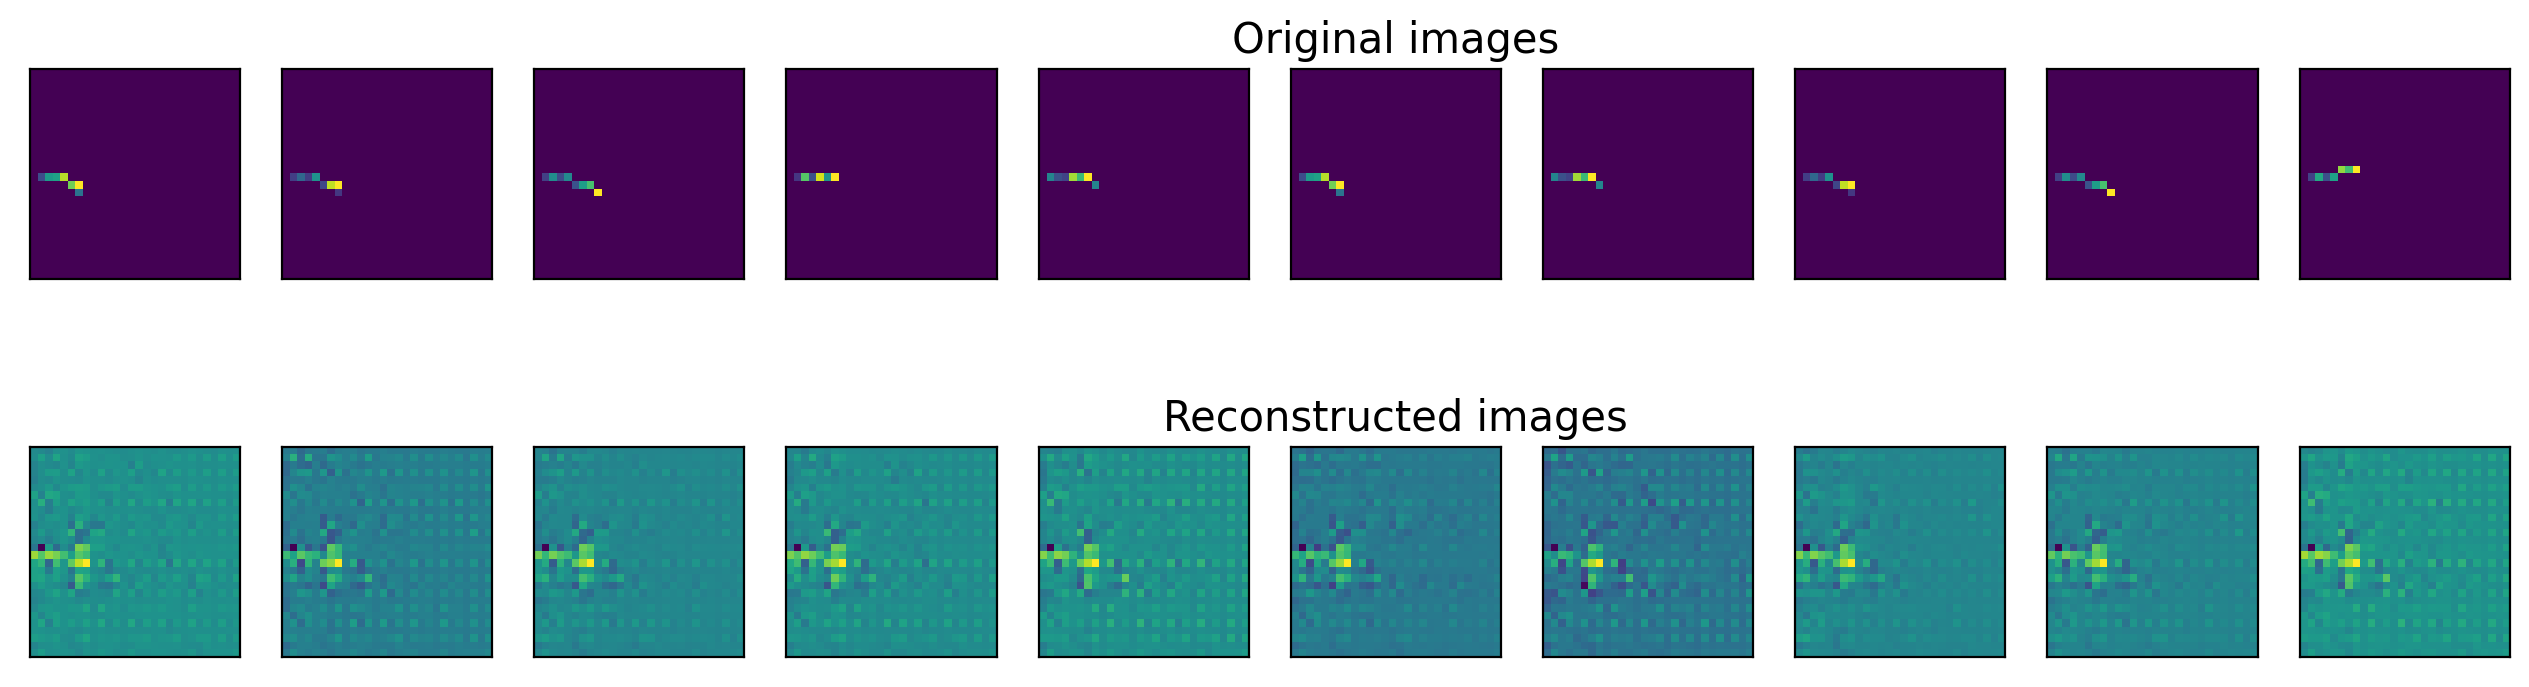


 EPOCH 501/2500 	 train loss 77.345 	 val loss 0.000


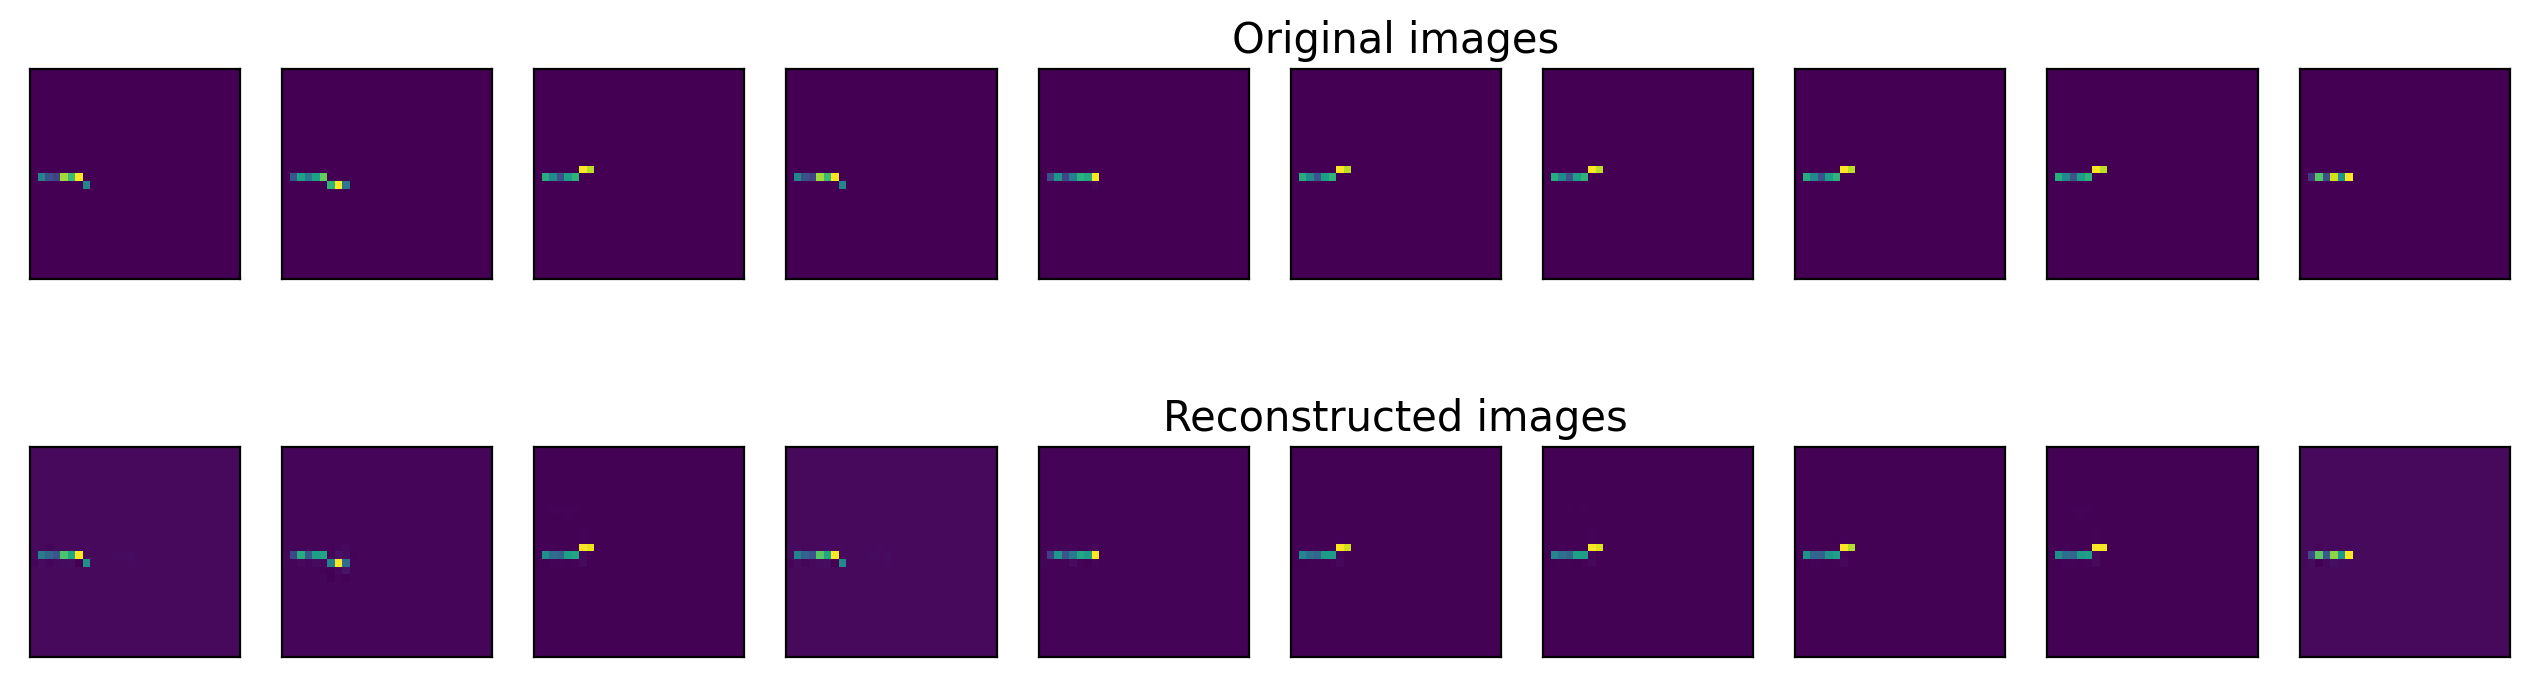


 EPOCH 1001/2500 	 train loss 58.166 	 val loss 0.000


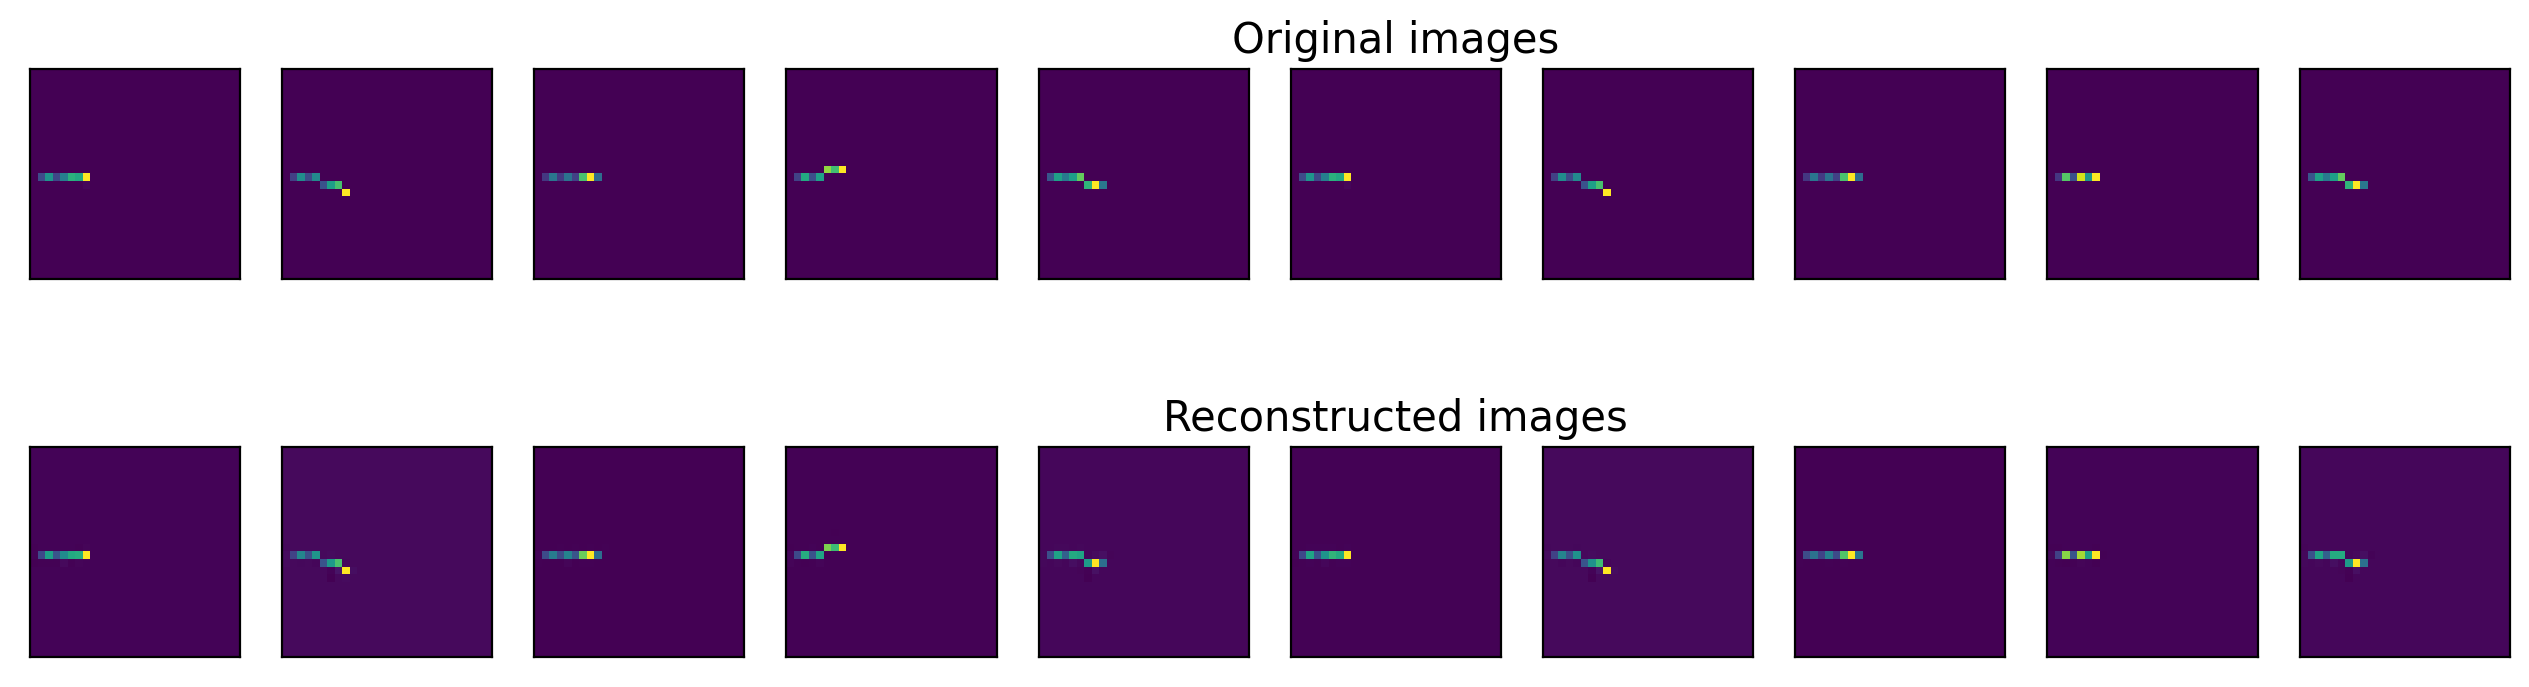


 EPOCH 1501/2500 	 train loss 45.325 	 val loss 0.000


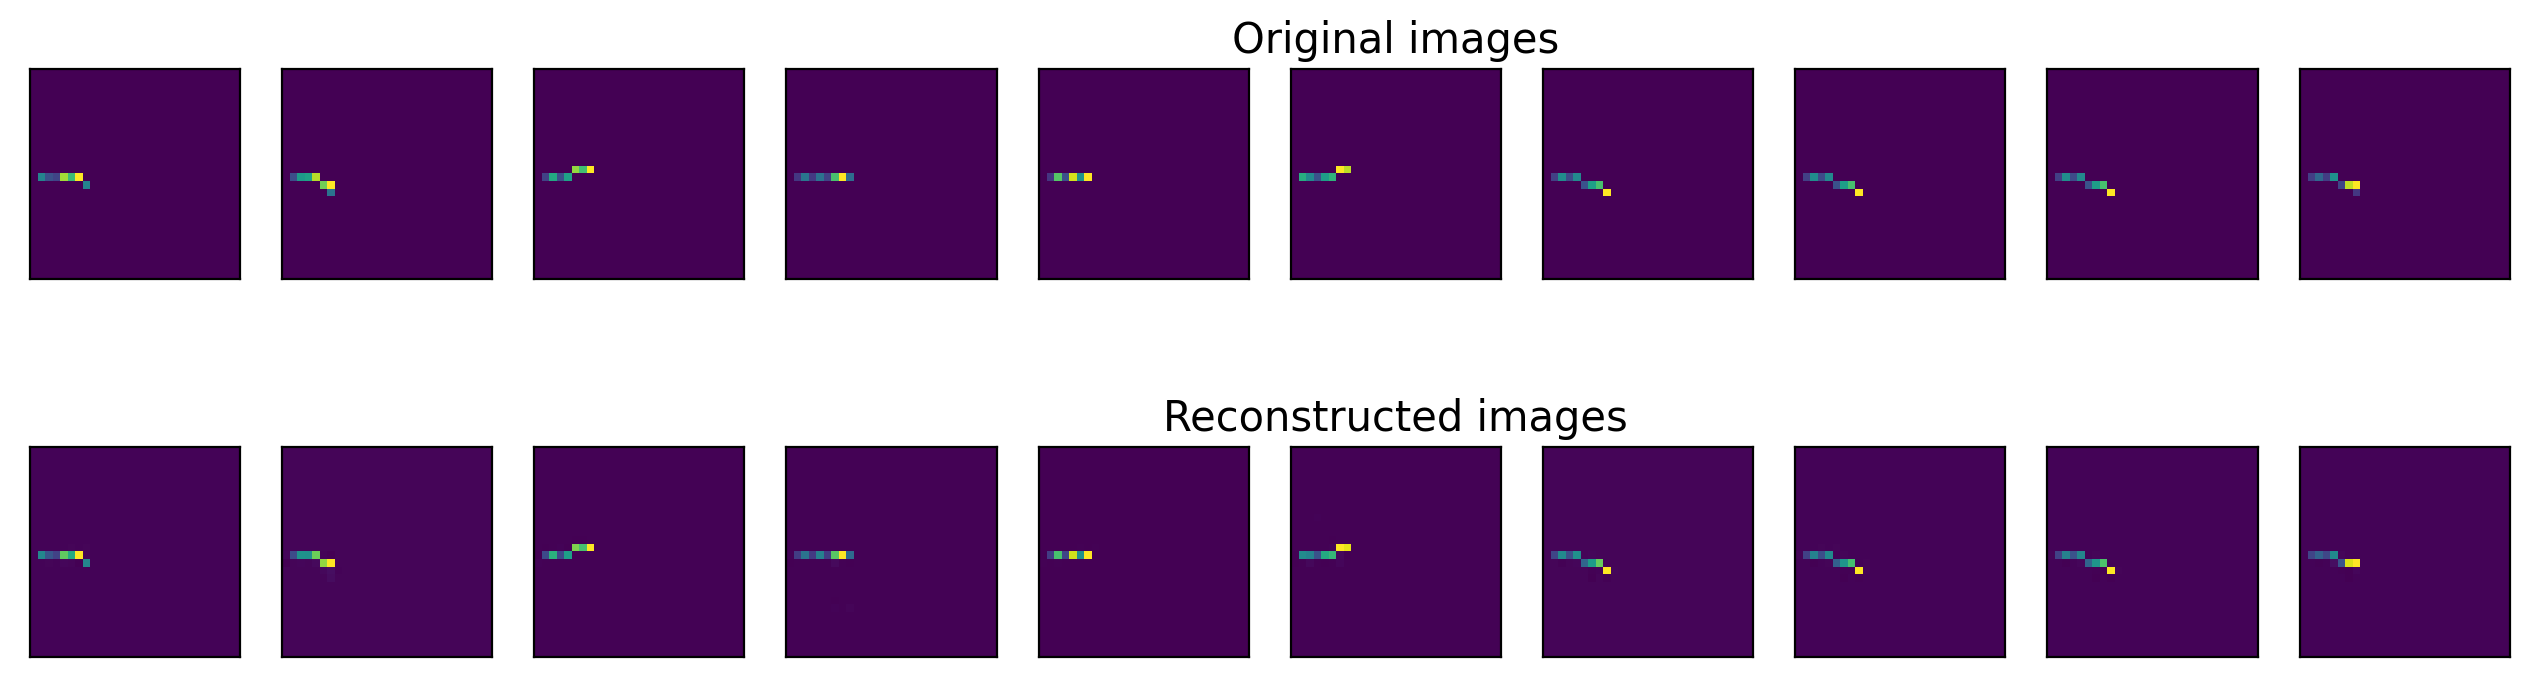


 EPOCH 2001/2500 	 train loss 43.261 	 val loss 0.000


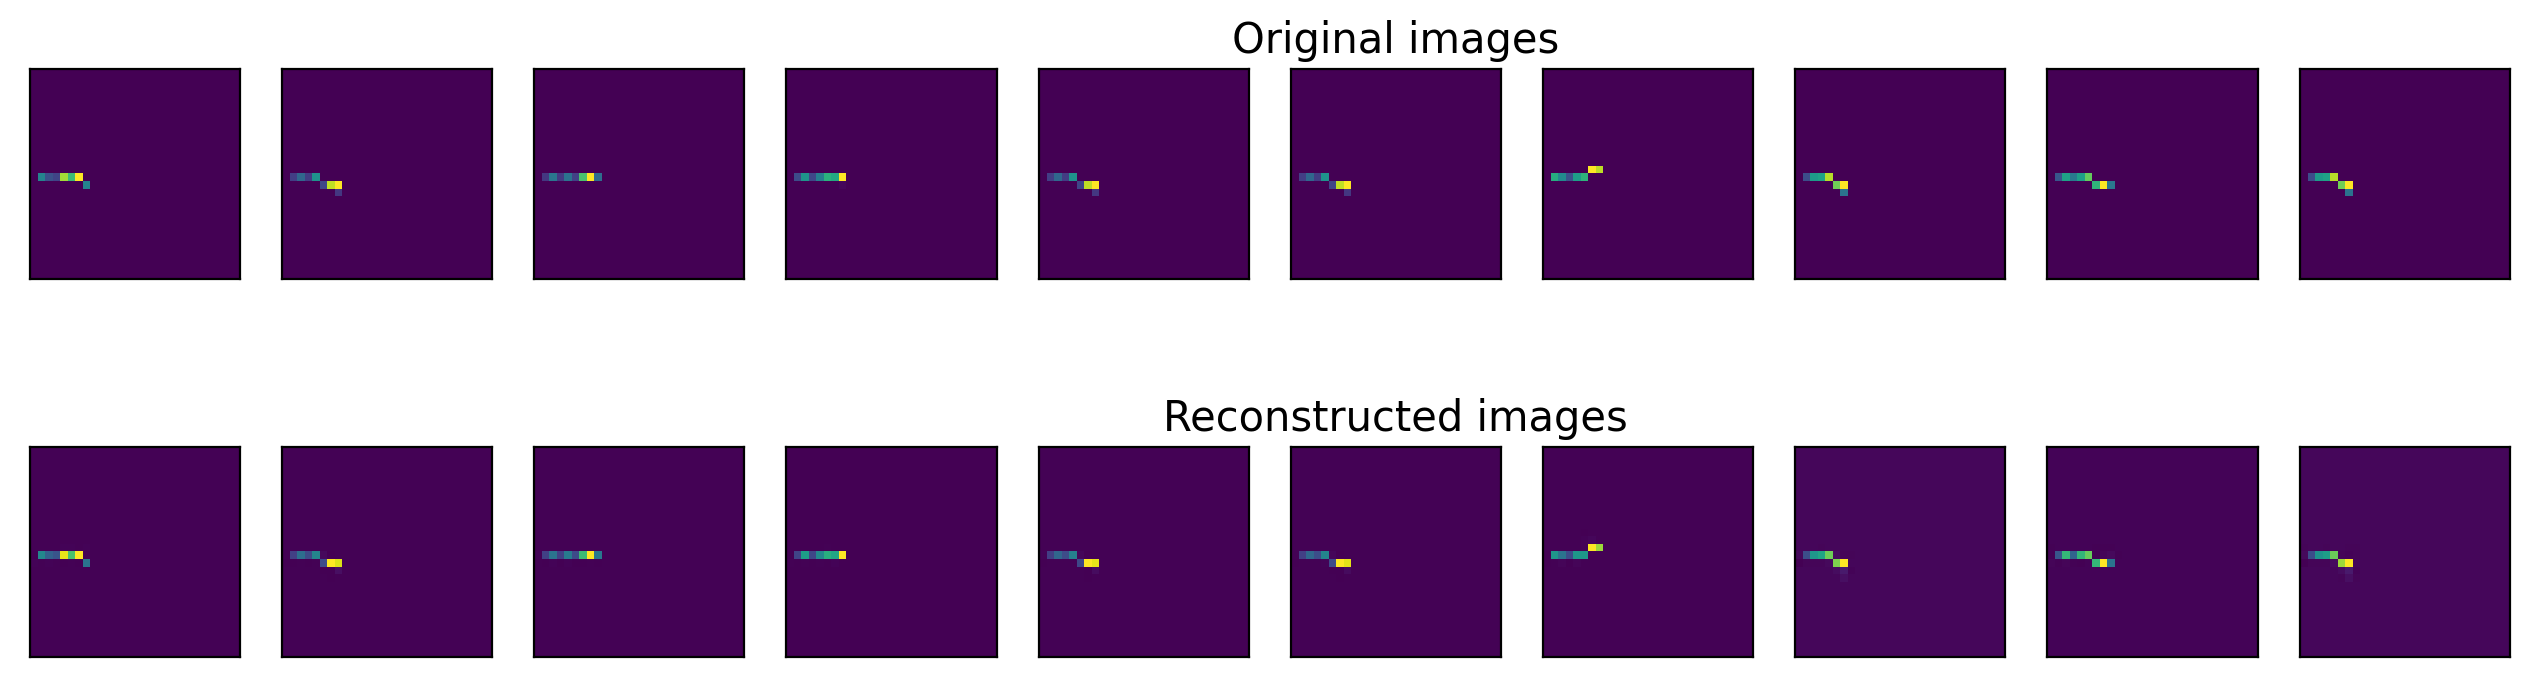

In [68]:
num_epochs = 2500

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    val_loss=0
    if epoch % 500 == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(image150,vae,n=10)

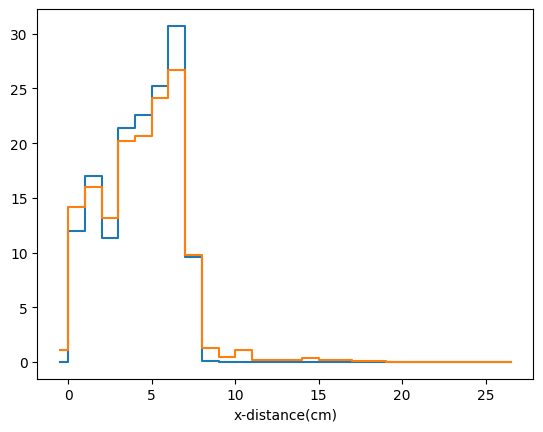

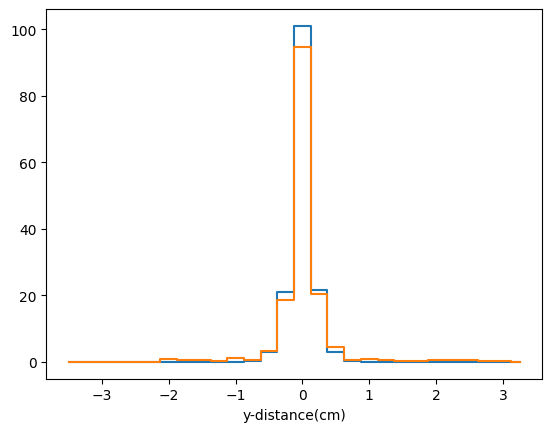

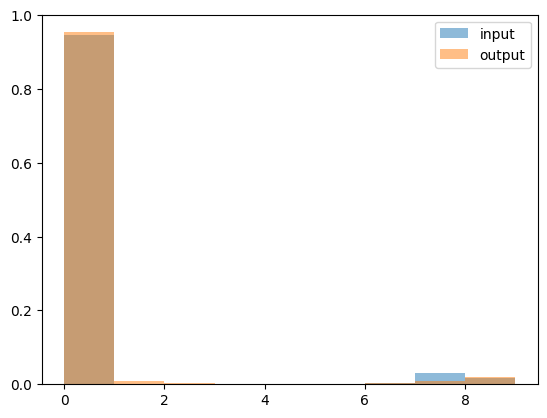

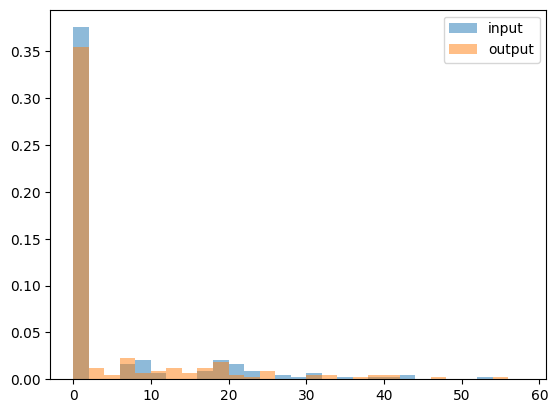

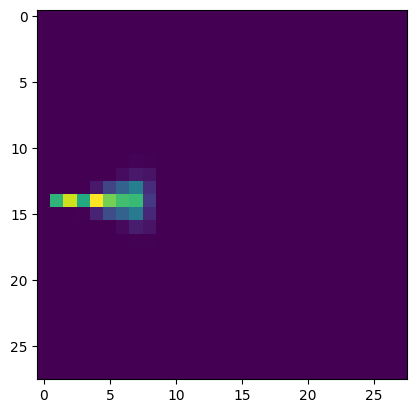

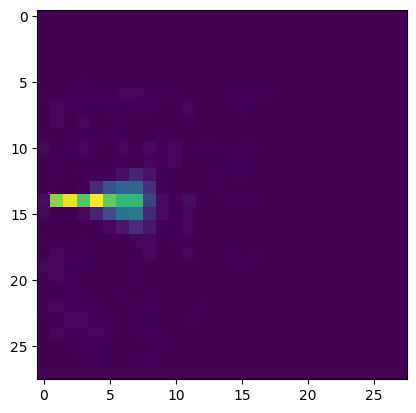

In [365]:
def plotVAEImageOutputs(iLatentDim,iDataSet):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    rec_img  = vae.decoder(testlatent)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('x-distance(cm)')
    plt.show()
    

    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,10,1)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[12:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[12:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()
    
    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

#dimage150_avg = np.mean(dimage150,axis=0)
#plt.imshow(dimage150_avg[0])
#plt.show()
#dimage150_tmp = np.mean(dimage150,axis=0)
#plt.imshow(dimage150[0][0])
#plt.show()
#test=np.mean(np.sum(dimage150,axis=3),axis=0)
plotVAEImageOutputs(d,dimage150)
torch.save(vae.state_dict(), 'vae_150.pt')

<a name='section_18_7'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L18.9 Conditional VAEs allowing for energy based generation </h2>  





Now that we have created a basica VAE that captures most of the features that our Monte Carlo Simulation does, lets go ahead and now train for all of our beam energies. 

Training with all of the beam energies is a bit trickier, because we would like to embed our knowledge of the energy into the VAE so that we can decode our setup with the knowledge of the beam energy. We can think of this as
our decorder $d(x)$ now needs to be conditional on the beam energy. We can write this as: 

$$
d\left(x|E\right) = f_{NN}\left(\mathcal{N}(\vec{x}|\vec{\sigma}),E\right)
$$

Where $f_{NN}$ is our neural network, which now takes in the sampled distribution, and the energy. The scheme here is that our we are adding Energy to our latent space, to modify the sample sampling. 

In [379]:
class CondVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(CondVariationalAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1  = nn.Linear(3*3*32, 64)
        self.linear1a = nn.Linear(64, 8)
        self.linear1b = nn.Linear(9,  8)
        self.linear2 = nn.Linear(8, latent_dims)
        self.linear3 = nn.Linear(8, latent_dims)

        #Now we need sample in phase space 
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims+1, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )


    def encoder(self, x, c):
        x = F.relu(self.conv1(x))
        #x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear1a(x))
        x = torch.hstack((x,c))
        x = F.relu(self.linear1b(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear 
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

            
    def decoder(self, x, c):
        x = torch.hstack((x,c))
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

        
    def forward(self, x, c):
        z = self.encoder(x, c)
        return self.decoder(z, c)
    
torch.manual_seed(0)
d = 4
vae = CondVariationalAutoEncoder(latent_dims=d)
lr = 1e-2 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
from torch.utils.data import ConcatDataset
megeimage=ConcatDataset([image150, image200,image250,image300])
train_loader = torch.utils.data.DataLoader(megeimage, batch_size=500)


 EPOCH 1/2500 	 train loss 4557.511 	 val loss 0.000


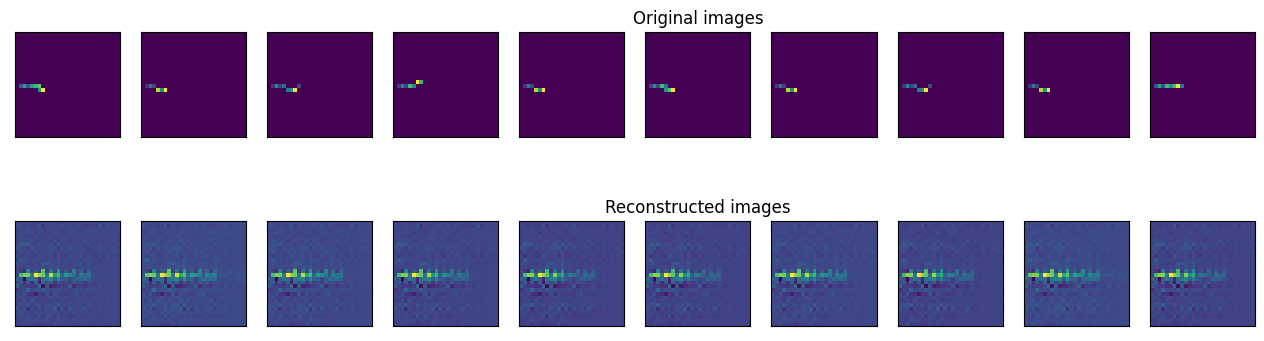


 EPOCH 501/2500 	 train loss 1605.357 	 val loss 0.000


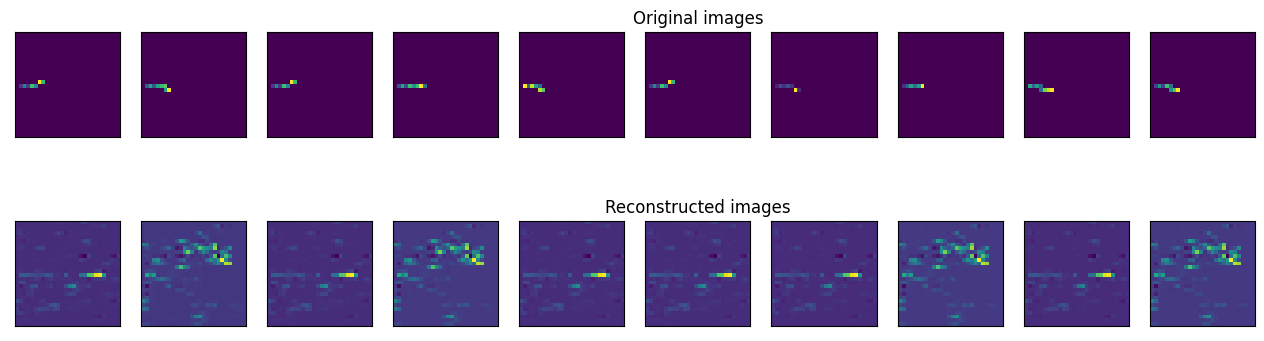


 EPOCH 1001/2500 	 train loss 1472.318 	 val loss 0.000


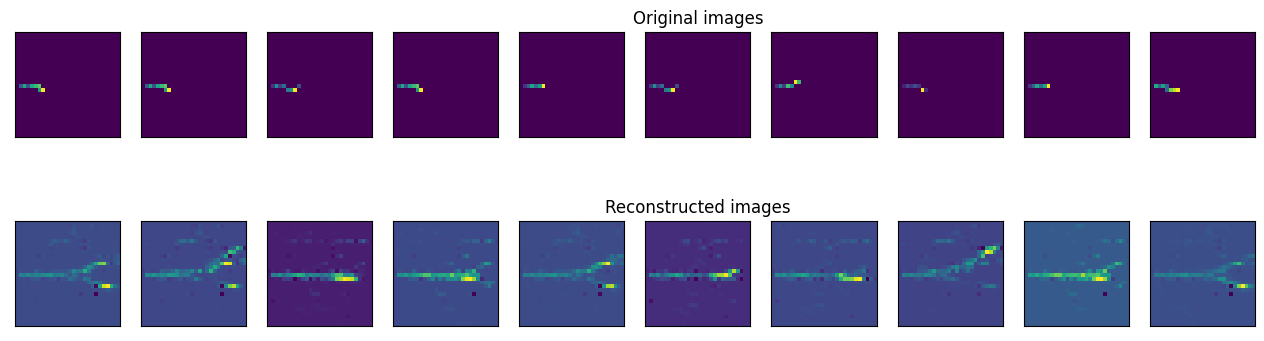


 EPOCH 1501/2500 	 train loss 1307.216 	 val loss 0.000


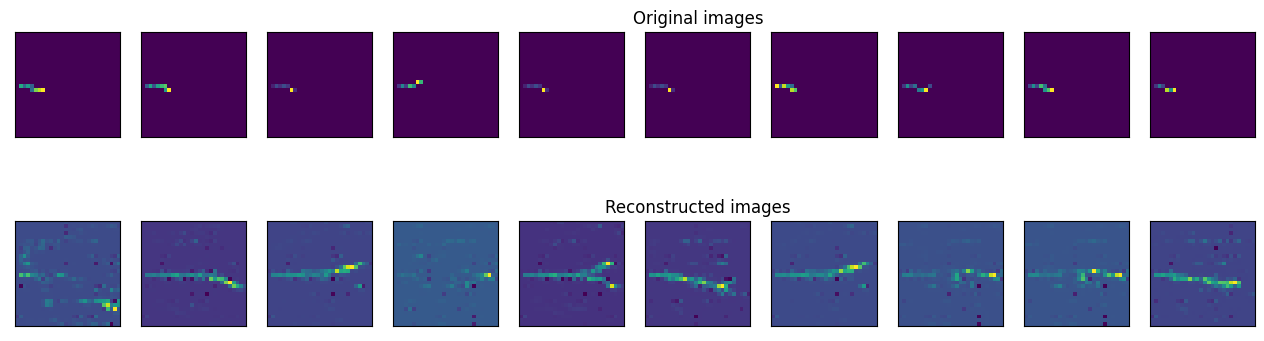


 EPOCH 2001/2500 	 train loss 1301.875 	 val loss 0.000


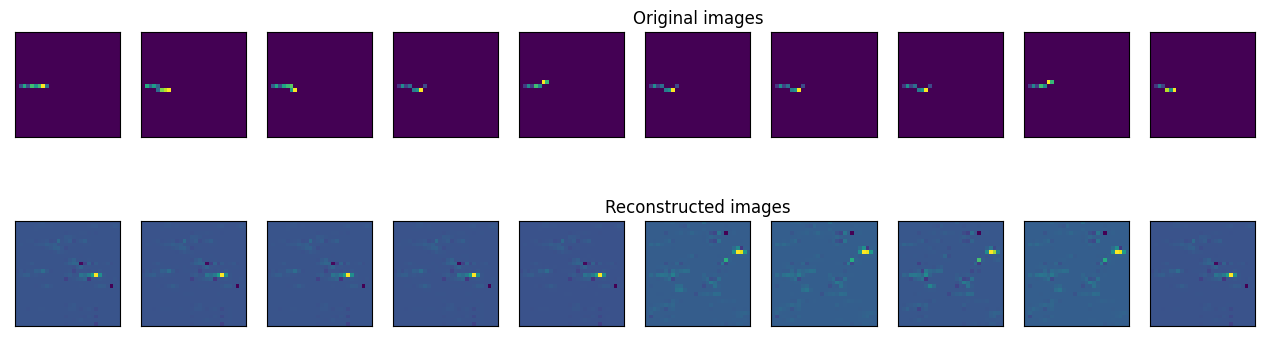

In [380]:
def plot_ae_outputs(idataset,ivae,n=10):
    plt.figure(figsize=(16,4.5))
    t_idx = np.random.randint(10,size=10)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = idataset[t_idx[i]][0].unsqueeze(0)
      vae.eval()
      #encoder.eval()
      #decoder.eval()
      npones=np.ones((1,1))*150
      beam=torch.tensor(npones).float()
      with torch.no_grad():
         rec_img  = vae.decoder(vae.encoder(img,beam),beam)
      plt.imshow(img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy())#, cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, c in dataloader: 
        # Move tensor to the proper device
        c=c.reshape(len(c),1).float()
        x_hat = vae(x,c)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

num_epochs = 2500

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    val_loss=0
    if epoch % 500 == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(image150,vae,n=10)

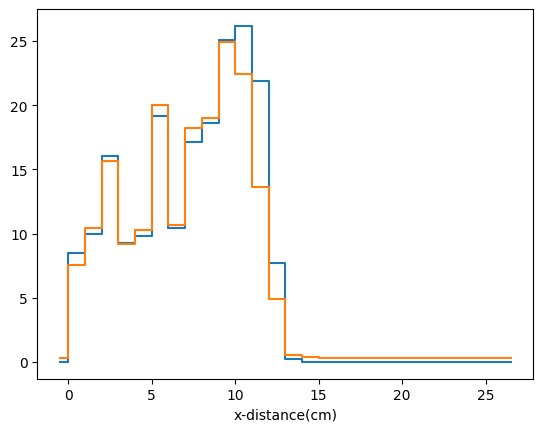

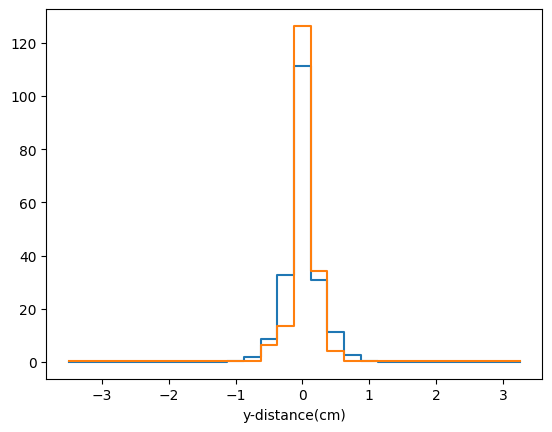

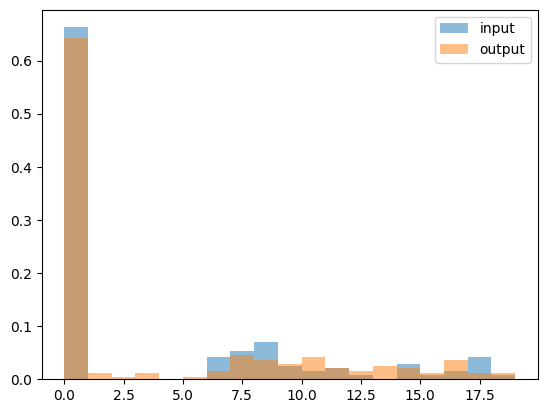

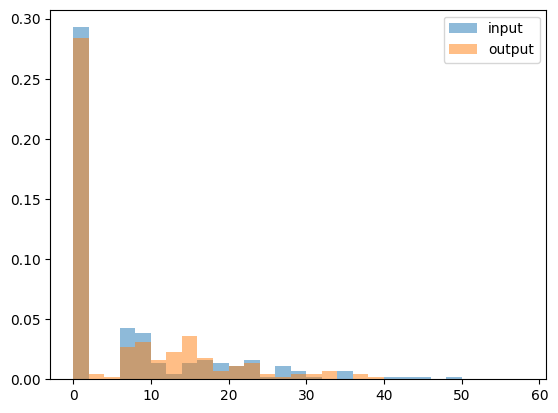

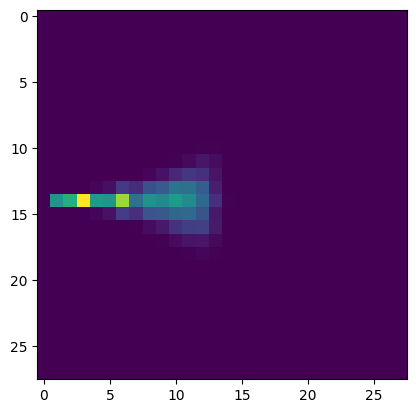

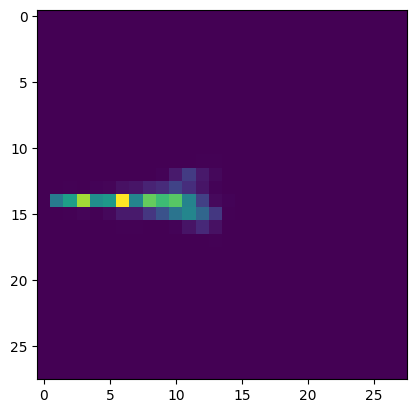

In [386]:
def plotCondVAEImageOutputs(iE,iLatentDim,iDataSet):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    beamenergy = torch.ones(iDataSet.shape[0],1)*iE
    rec_img  = vae.decoder(testlatent,beamenergy)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('x-distance(cm)')
    plt.show()
    

    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,20,1)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[12:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[12:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()
    
    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

plotCondVAEImageOutputs(2.00,d,dimage200) 
torch.save(vae.state_dict(), 'cvae_test.pt')

## Normalizing Flows :  more Expressive model 

## Auxiliary info

1.6448536269514722


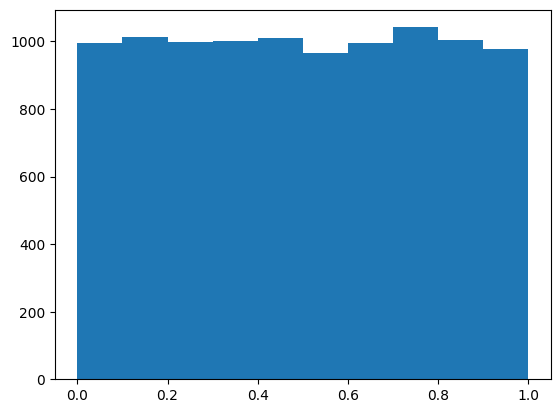

In [208]:
import scipy
print(scipy.stats.norm.ppf(0.95))

sample=np.random.normal(0,1,10000)
pval=scipy.stats.norm.cdf(sample)
plt.hist(pval)
plt.show()

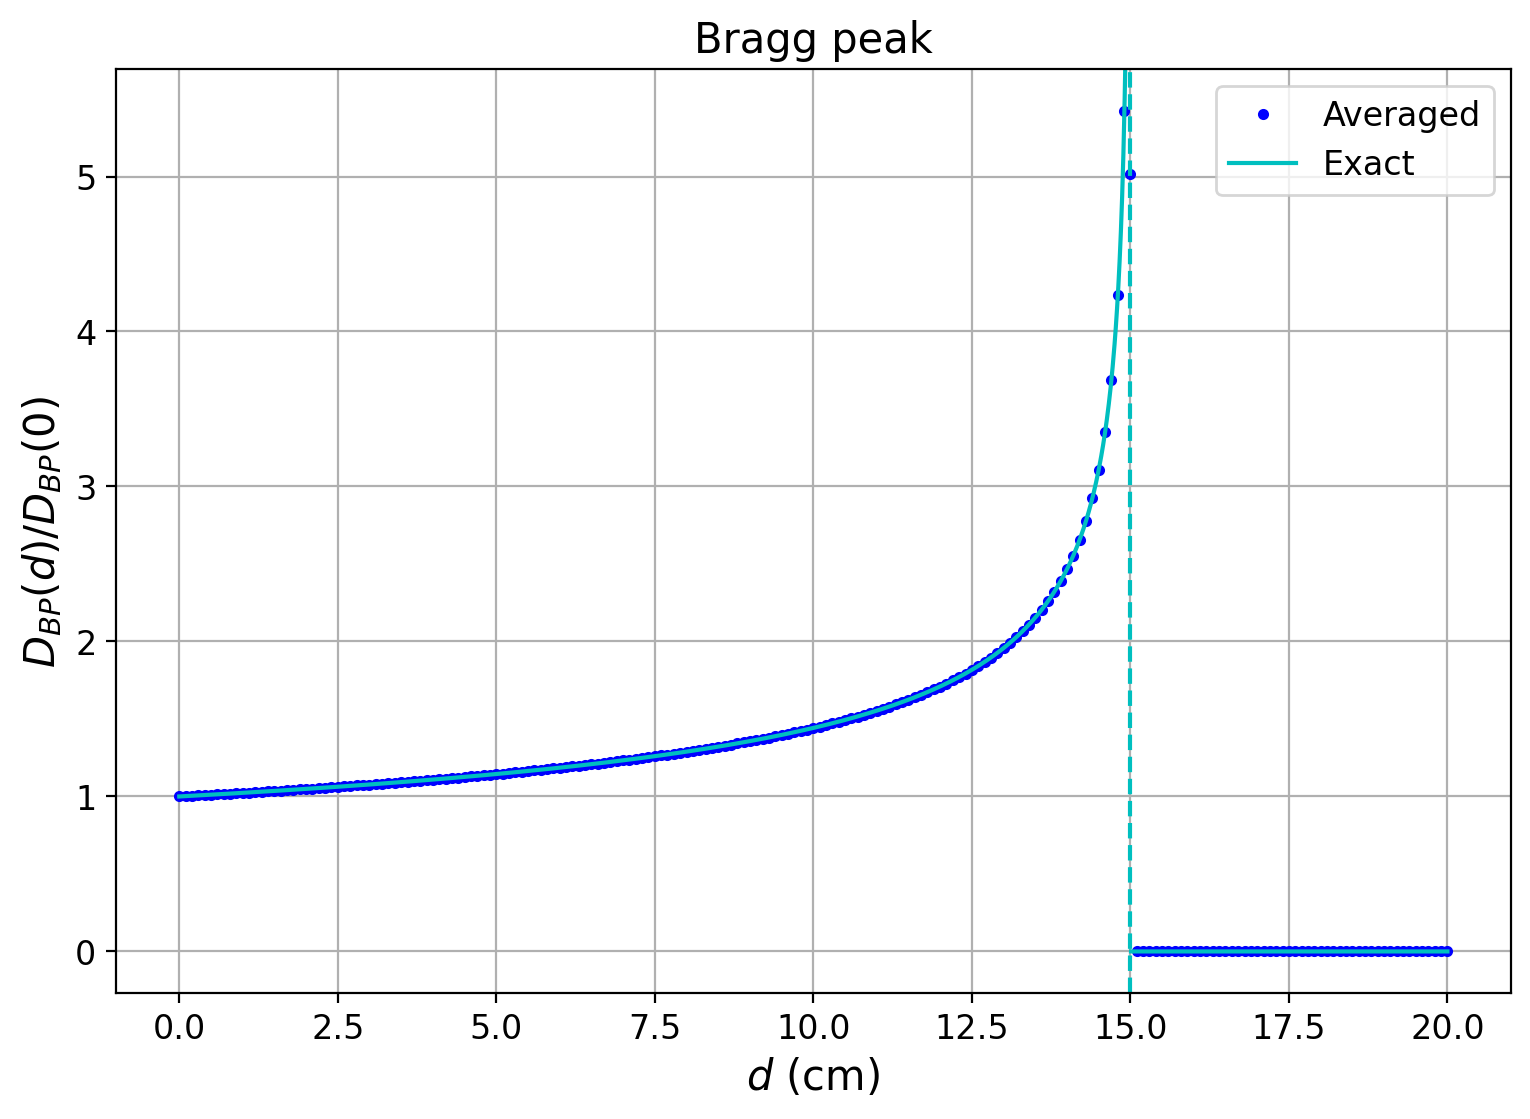

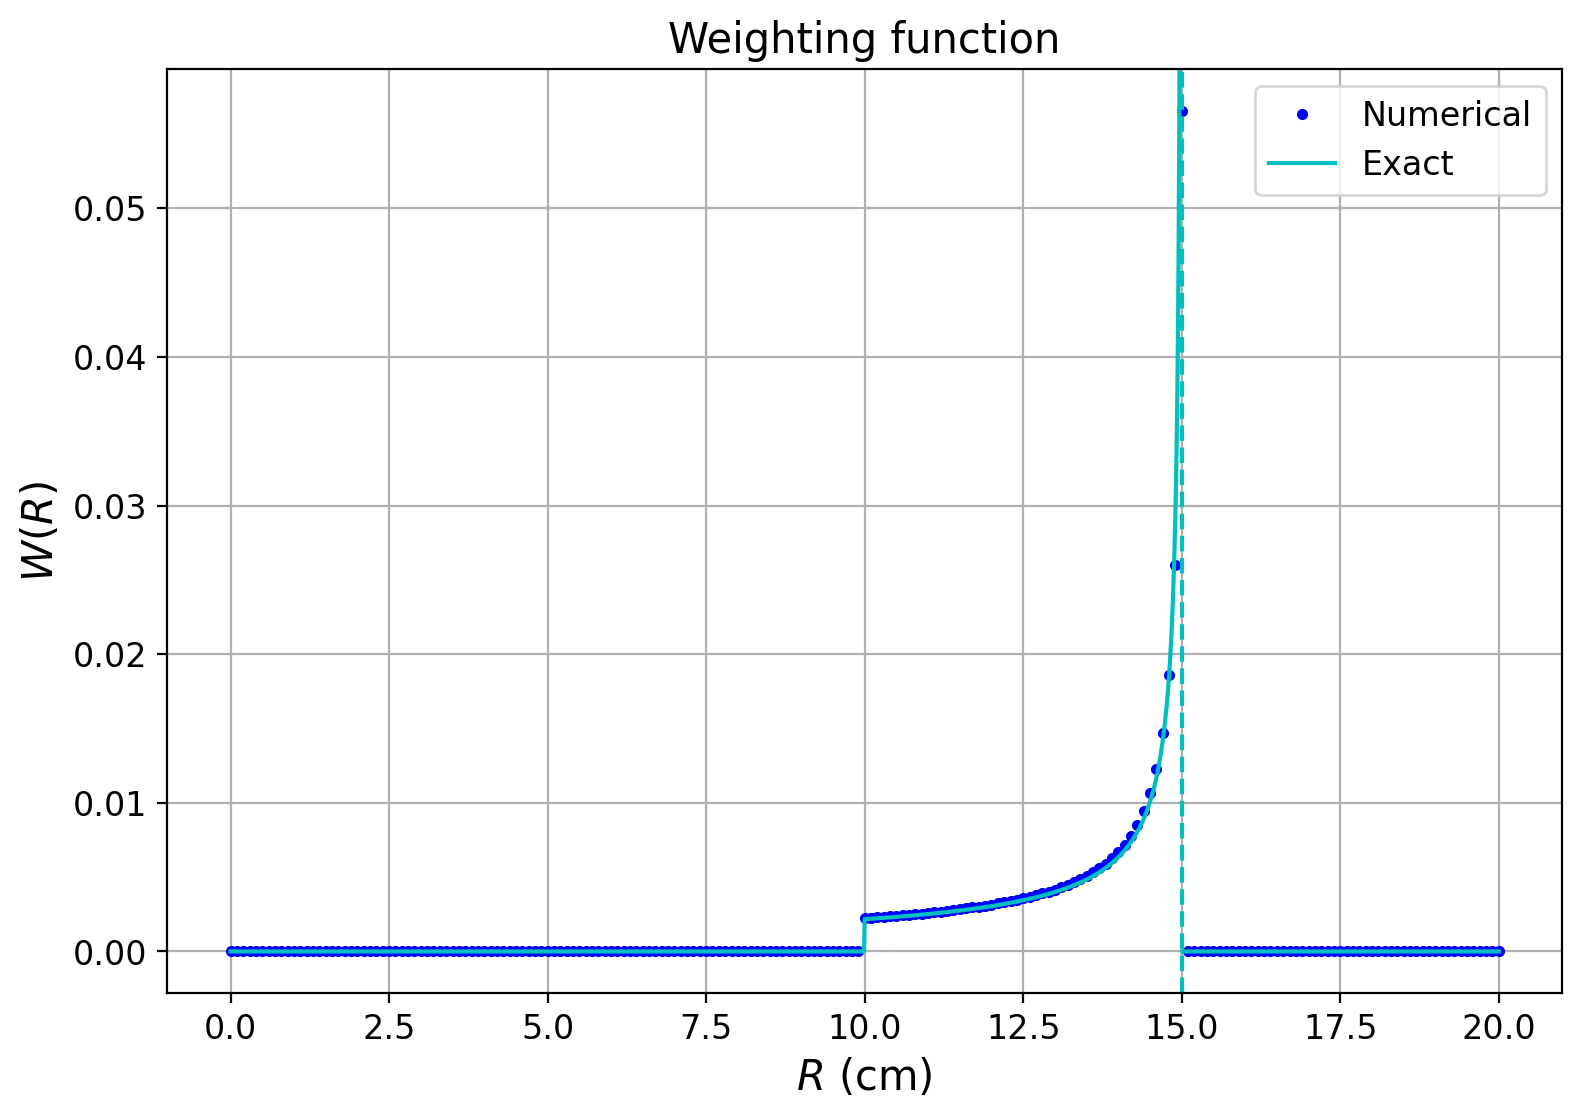

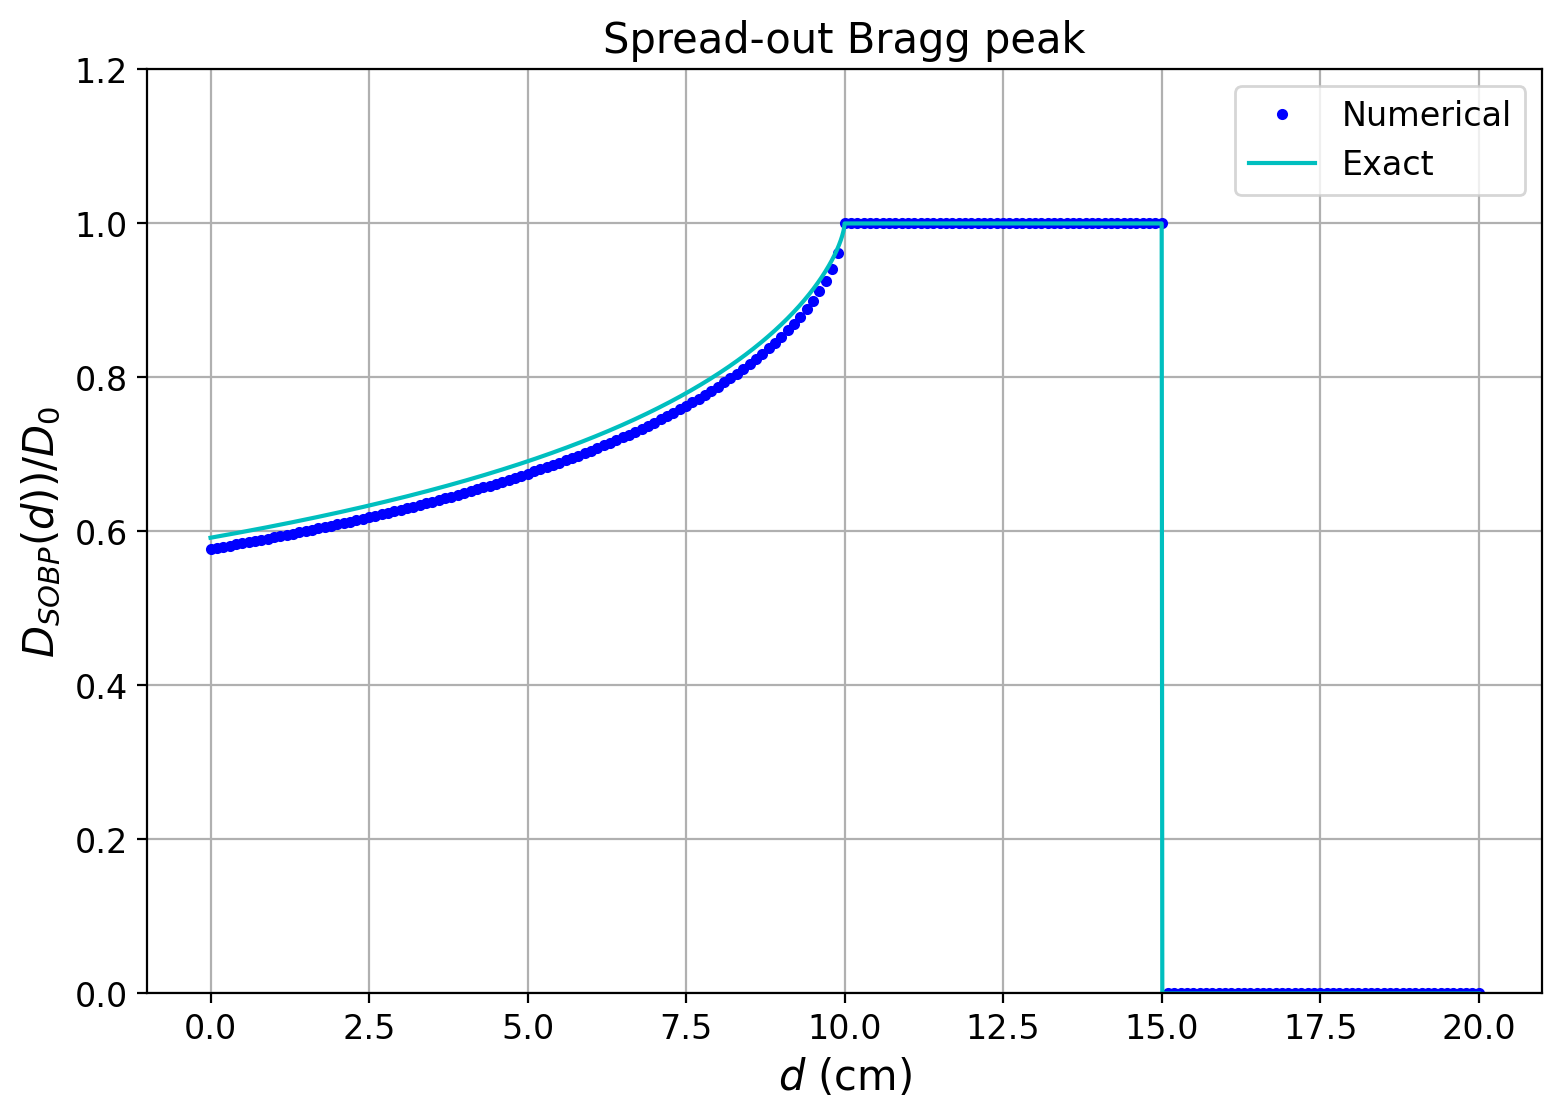

In [34]:
"""Script which calculates the required weighting of individual Bragg peaks a to generate spread-out Bragg peak (SOBP).
A numerical solution is compared to an exact one from Bortfeld & Schlegel, "An analytical approximation of depth-
dose distributions for therapeutic proton beams", Phys. Med. Biol. 41 (1996), 1331-1339. """

import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt

alpha = 1.9e-3      # Empirical constant (Bortfeld & Schlegel (1996), Eq. (1))
p = 1.5             # Empirical exponent
D0 = 1.0            # Desired dose in the spread-out Bragg peak (SOBP)

da = 10.0           # Shallowest part of dose interval (in cm)
db = 15.0           # Deepest part of dose interval (in cm)

# Shorthand for oft-used expressions
a = alpha**(1.0/p)
q = 1.0 - 1.0/p

# Stopping power S = -dE/dd, mirrored about the y-axis and shifted by db (Bortfeld & Schlegel (1996), Eq. (A5))
def g(d):
    return np.piecewise(d,[d<0,d>0],[0,lambda d: 1.0/(p*a*d**q)])

def Bragg_peak(R,d):
    return g(R-d)

# Numerically computes the average of a function "func" on the interval [d0,d1]
def average(func,d0,d1):
    integral,_ = integrate.quad(func,d0,d1)/(d1-d0)
    return integral

# For a function defined for x>0, given an array x of grid values, returns an array of average
# function values on intervals [x[n]-dx/2, x[n]+dx/2], where x[n] is a grid value and dx the grid spacing
def impulse(func,x):
    h = np.zeros(len(x))
    dx = x[1] - x[0]
    h[0] = average(func, 0, 0.5*dx)
    for n in range(1,N):
        h[n] = average(func, x[n]-0.5*dx, x[n]+0.5*dx)
    return h

def W(R):
    return np.piecewise(R,[(da<=R) & (R<db)],[lambda R: D0*p*np.sin(np.pi/p)*a/(np.pi*(db-R)**(1.0/p)), 0])

# Performs the reverse of the transforms defined in Eq. (A3) of Bortfeld & Schlegel (1996)
def back_transform(w,da,db,x):
    N = len(x)
    dx = x[1] - x[0]
    Na = int(da/dx)
    Nb = int(db/dx)
    w = w[:Nb+1]
    w_reverse = w[::-1]
    return np.concatenate((np.zeros(Na), w_reverse[Na:Nb+1], np.zeros(N-Nb-1)))

# Part of the exact solution of the spread-out Bragg peak for p = 1.5 (Bortfeld & Schlegel (1996), Eq. (6))
def SOBP_buildup(d,da,db,D0):
    r = (da - d)/(db - da)
    r_hat = r**(1.0/3.0)
    return D0*(0.75+np.sqrt(3)/(4*np.pi)*np.log((1+r_hat)**2/(1-r_hat+r_hat**2))-3.0/(2.0*np.pi)*np.arctan((2*r_hat-1)/np.sqrt(3)))

# Full piecewise-defined analytical solution for the SOBP with p = 1.5 (Bortfeld & Schlegel (1996), Eq. (6))
def SOBP_analytic(d,da,db,D0):
    return np.piecewise(d,[(0<=d) & (d<da),(da<=d) & (d<=db)],[lambda d: SOBP_buildup(d,da,db,D0), D0, 0])

# Add grid and legend to plots
def add_grid_legend():
    plt.grid('on')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc = 'best')

# Definition of the depth grid
N = 201                         # Number of grid points
dmax = 20.0                     # Maximum depth up to which to generate model output
d = np.linspace(0,dmax,N)       # Depth grid
dd = d[1] - d[0]                # Depth grid spacing
Na = int(da/dd)                 # Grid point index corresponding to d = da
Nb = int(db/dd)                 # Grid point index corresponding to d = db

g_avs = impulse(g,d)            # Impulse response function (with averaging applied to remove singularity)

M = N                           # Length of inverse filter response w(R)
d_w = np.arange(M)*dd           # Depth grid for w(R)
Nd = M + N - 1                  # Number of output samples needed to obtain the inverse filter response of the required length

yd = D0*np.ones(Nd)             # Heaviside step function of length Nd

# Perform deconvolution of the step function with the averaged impulse response
w, remainder = signal.deconvolve(yd,g_avs)
w /= dd                        # Divide by grid spacing to obtain an approxiamtion of the continuous-valued weighting function

w2 = back_transform(w,da,db,d)

# Obtain the spread-out Bragg peak by deconvolution (cf. Bortfeld & Schlegel (1996), Eq. (B1))
SOBP = dd * signal.convolve(w2,g_avs[::-1])
SOBP = SOBP[N-1:]               # Remove boundary effects at the beginning of the convolution output

# Figure 1: Illustration of the Bragg peak
plt.figure(1)
Ncont = 2001                        # More finely spaced, 'continuous' grid for plotting exact solution
dcont = np.linspace(0,dmax,Ncont)
dx_cont = dcont[1] - dcont[0]

gx = Bragg_peak(db,dcont)           # Exact Bragg peak (Bortfeld & Schlegel, Eq. (3))
gx /= gx[0]                         # Normalize by value at d = 0
gx[int(db/dx_cont)] = np.nan                 # Set to not-a-number at the singularity at d = db

gn = impulse(lambda d: Bragg_peak(db,d),d)      # Discretized Bragg peak in which the singularity at d = db is removed by averaging
gn /= gn[0]                                     # Normalized by value at d = 0

plt.plot(d,gn,'b.',label='Averaged')
ymin,ymax = plt.gca().get_ylim()                # Record auto-scaled axis limits for the discrete (averaged) Bragg peak only
plt.plot(dcont,gx,'c',label='Exact')
plt.axvline(x=db,color='c',linestyle='--')
plt.title("Bragg peak")
plt.xlabel('$d$ (cm)')
plt.ylabel(r'$D_{BP}\left( d \right)/D_{BP}\left( 0 \right)$')
plt.gca().set_ylim(ymin,ymax)
add_grid_legend()

# Figure 2: Weighting function
plt.figure(2)
wx = W(dcont)           # Exact weighting function (Bortfeld & Schlegel (1996), Eq. (4))
wx[int(db/dx_cont)] = np.nan
plt.plot(d,w2,'b.',label='Numerical')
ymin,ymax = plt.gca().get_ylim()                # Record auto-scaled axis limits
plt.plot(dcont,wx,'c',label='Exact')
plt.axvline(x=db,color='c',linestyle='--')
plt.xlabel('$R$ (cm)')
plt.ylabel(r'$W\left(R\right)$')
plt.title('Weighting function')
plt.gca().set_ylim(ymin,ymax)
add_grid_legend()

# Figure 3: Spread-out Bragg peak
plt.figure(3)
plt.plot(d,SOBP,'b.',label='Numerical')
plt.plot(dcont,SOBP_analytic(dcont,da,db,D0),'c',label='Exact')
plt.xlabel('$d$ (cm)')
plt.ylabel('$D_{SOBP}(d))/D_0$')
plt.title('Spread-out Bragg peak')
plt.ylim([0,1.2*D0])
add_grid_legend()

plt.show()

In [ ]:
#https://www.kaggle.com/code/augeropendata/the-heitler-model/notebook